In [4]:
import awkward as ak
import numpy as np
import time
# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep


In [42]:
%load_ext autoreload
%autoreload 2

from plugins import *
from triggerProcessor import *
from dask.distributed import Client

In [2]:
in_year = 2016
data_bool = False
processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
datastring = "JetHT" if processor.data == True else "QCDsim"
filename = "datasets_UL_NANOAOD.json" if processor.data == True else "fileset_QCD.json"
result = runCoffeaJob(processor, jsonFile = filename, casa = True, dask = True, testing = False, year = processor.year, data = processor.data)
util.save(result, 'coffeaOutput/triggerAssignment_{}_{}_{}_NewHist.coffea'.format(datastring, processor.year, processor.trigger))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
UL16
Running on coffea casa


/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


{'tls://lauren-2emeryl-2ehay-40cern-2ech.dask-worker.cmsaf-prod.flatiron.hollandhpc.org:8788': ['global.lock', 'purge.lock', 'GluonJetMass', 'worker-ivs9jdhu', 'worker-ivs9jdhu.dirlock']}
<Client: 'tls://192.168.161.72:8786' processes=0 threads=0, memory=0 B>


OSError: XRootD error: [FATAL] Hand shake failed
in file root://xcache//store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/4987CE9D-0605-5741-B25C-B1A2A9996085.root

In [90]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous
from scipy.special import erf, erfinv

def fit_function(x, b, c):
    # y = a+0.5*(1-a)*(1+erf((x-b)/c))
    y = 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    return y
#### define custom error function using scipy.stats rv_continuous --> will automatically inherit MLE fit
class cust_erf(rv_continuous):
    def _pdf(self, x, b, c):
        # return a+0.5*(1-a)*(1+erf((x-b)/c))
        return 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    #### use rv_continuous scale and loc to compute x->(x-loc)/scale
fit_func = cust_erf(name='erf')
print("rv_cont fit function: ", fit_func)

#### params are b,c
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    x0 = [np.min(x), np.min(x)/5]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    b, c, loc, scale = fit_func.fit(data, *popt, floc = 0., fscale = 1.0)
    print("Basic fit results: ", popt)
    print("MLE results: ", [b, c, loc, scale])
    return b, c, popt

import matplotlib.pyplot as plt
plt.style.use([hep.style.CMS, hep.style.firamath])
import hist 
from plugins import checkdir
def plot_turnOn(result, HLT):
    hist_trigEff = result['hist_trigEff_ptCut']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path for path in list(hist_trigEff.project("HLT_cat").axes[0])]
    dataset = hist_trigEff[{"HLT_cat":slice(0,hist.overflow-1,sum)}].axes[0][0]
    os_path = 'plots/triggerStudies'+ dataset + 'Testing/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path)
        print("dataset: ", dataset)
        # print("trigeffvalues for path: ", hist_trigEff[{"HLT_cat":path}])
        #### numerator is number of events that belong to trigger path below and have pt > current trigger thresh
        numerator = hist_trigEff[{"HLT_cat":path}].values()[0]
        #### denominator is number of events in trigger below
        denominator = hist_trigRef[{"HLT_cat":path}].values()[0]
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        efficiency = num / denom
        pt_centers = hist_trigEff.axes['pt'].centers[denominator > 0]
        
        print("Length of efficiency:", len(efficiency))
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist_trigEff[{"HLT_cat":path}].plot1d(ax=ax)
        hist_trigRef[{"HLT_cat":path}].plot1d(ax=ax)
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            ### only fit points after trigger threshold
            eff_turnon_id = np.min(np.argwhere(trigThresh[i] <= pt_centers))
            b_mle, c_mle, popt = fit_trigEff(pt_centers[eff_turnon_id+1:-1], efficiency[eff_turnon_id+1:-1])
            # b_mle, c_mle, popt = fit_trigEff(pt_centers, efficiency)
            xpts = np.linspace(0, 2400, 2400)
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            b, c = popt
            # to_pt = c*erfinv((2*0.99-1-a)/(1-a))+b
            to_pt = (np.sqrt(2)*c*erfinv(2*0.99-1)) + b
            to_pt_mle = (np.sqrt(2)*c_mle*erfinv(2*0.98-1)) + b_mle
            turnOnPts[path] = to_pt
            ax.scatter(hist_trigEff.axes['pt'].centers[denominator > 0], efficiency, label = 'HLT_' + path)
            # ax.plot(xpts, 0.5*(1+erf((xpts-trigThresh[i])/trigThresh[i-1])), label = "Test")
            ax.plot(xpts, fit_function(xpts, *popt), label = "Curve fit; to_pt = %.f"%to_pt)
            ax.plot(xpts, fit_function(xpts, b_mle, c_mle), label = "MLE fit; to_pt = %.f"%to_pt_mle)
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_' + path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
    hist_pt.plot1d(ax=ax)
    # hist_trigEff.plot1d(ax=ax, overlay = "HLT_cat", stack = True)
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_xlim([180., 3200.])
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts
    

rv_cont fit function:  <__main__.cust_erf object at 0x7fb5489fce80>


In [91]:
# ### Now have to convert ratio plot/fitter into a function that runs over the histograms
# ### or can cutflow all the values that go into the ratio plots and make values/1D histograms
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/DiJet_2016_QCDsim_Testing_PFJet_result.coffea')
# print(result['hist_trigEff'].sum('HLT_cat').sum('pt').values())
# turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
# print(turnOnPts_ptCut)
# print(turnOnPts)

HLT_paths: ['AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
Path =  AK8PFJet60
dataset:  JetHT2016
Length of efficiency: 22


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Basic fit results:  [-361.41769816  208.55281178]
MLE results:  [-361.4176981584152, 208.55281177957878, 0.0, 1.0]
Path =  AK8PFJet80
dataset:  JetHT2016
Length of efficiency: 33


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Basic fit results:  [-352.35445733  231.65689954]
MLE results:  [-352.35445733273616, 231.65689953583805, 0.0, 1.0]
Path =  AK8PFJet140
dataset:  JetHT2016
Length of efficiency: 38
Basic fit results:  [103.18234116  76.86818224]
MLE results:  [0.08800521560653551, 0.09728761872140868, 0.0, 1.0]
Path =  AK8PFJet200
dataset:  JetHT2016
Length of efficiency: 52
Basic fit results:  [224.05580508  39.06284189]
MLE results:  [5.719869022868806e-13, 76.05047029508401, 0.0, 1.0]
Path =  AK8PFJet260
dataset:  JetHT2016
Length of efficiency: 64
Basic fit results:  [277.50915638  52.78242329]
MLE results:  [0.03516707913665611, 0.03829902380845773, 0.0, 1.0]
Path =  AK8PFJet320
dataset:  JetHT2016
Length of efficiency: 88
Basic fit results:  [347.72473576  46.02572565]
MLE results:  [8.752713095475893e-18, 0.06214093596697319, 0.0, 1.0]
Path =  AK8PFJet400
dataset:  JetHT2016
Length of efficiency: 91
Basic fit results:  [419.913468    64.23124198]
MLE results:  [2.0250467969162855e-13, 125.050199

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Basic fit results:  [528.2464842   64.98713794]
MLE results:  [0.17406878405762022, 0.0030700996614083653, 0.0, 1.0]
{'AK8PFJet60': 123.74869215024762, 'AK8PFJet80': 186.56007840935342, 'AK8PFJet140': 282.00447348652773, 'AK8PFJet200': 314.92956425770416, 'AK8PFJet260': 400.2994345896792, 'AK8PFJet320': 454.7965847657287, 'AK8PFJet400': 569.3376812308528, 'AK8PFJet450': 625.8112613298829, 'AK8PFJet500': 679.4291743756459}


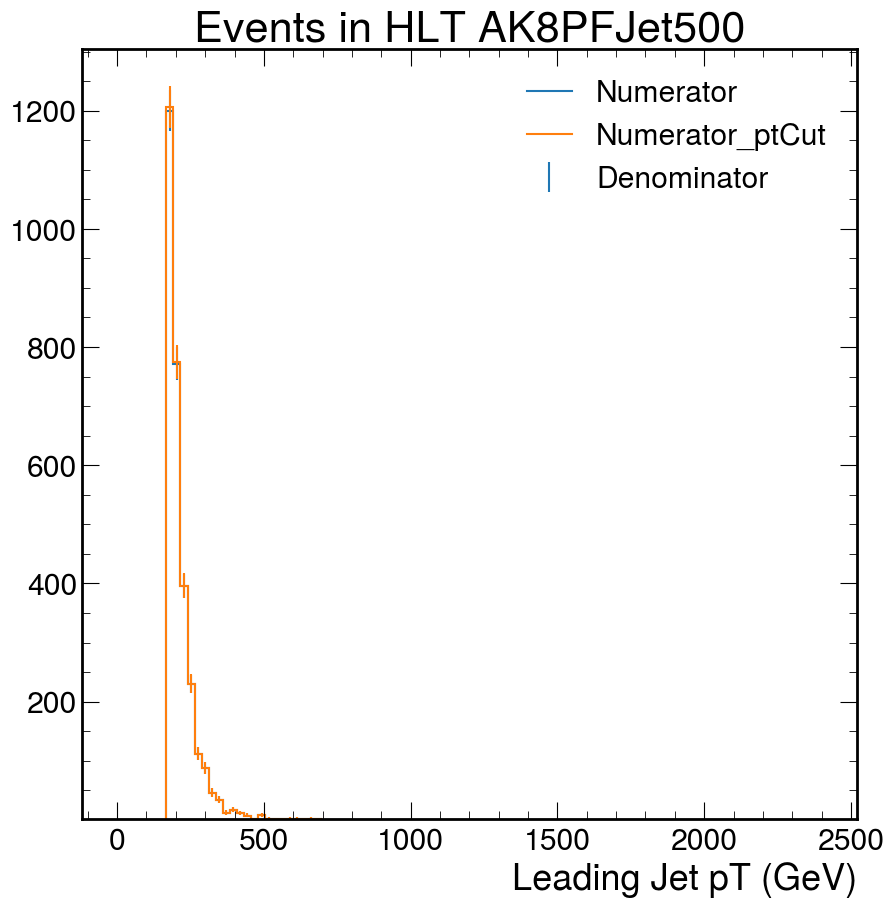

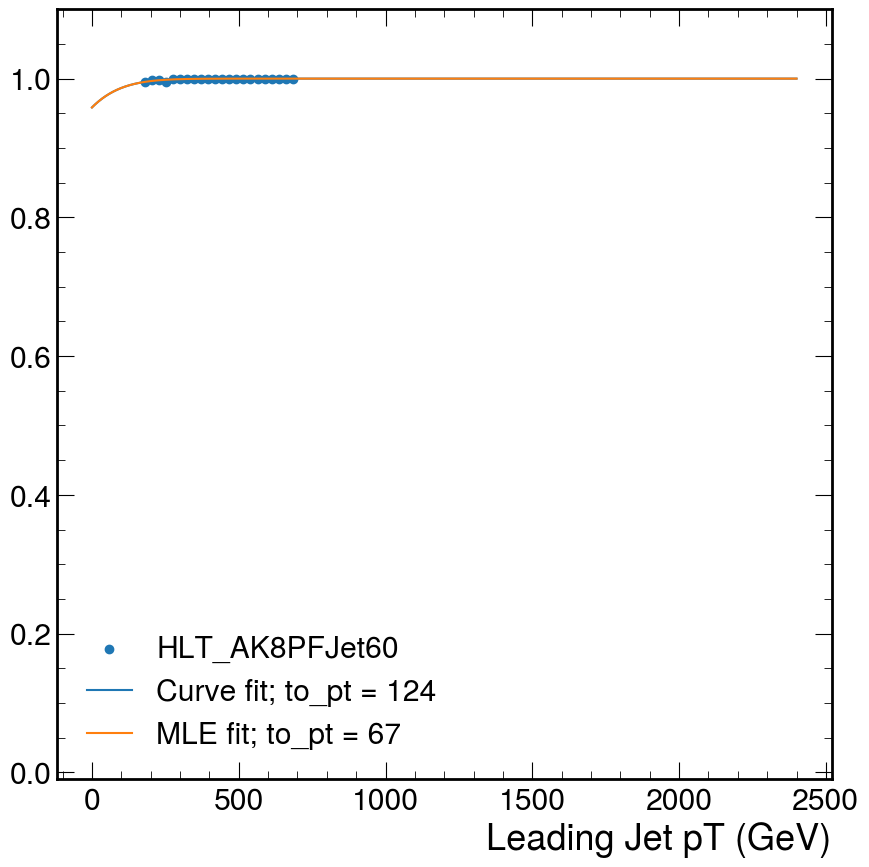

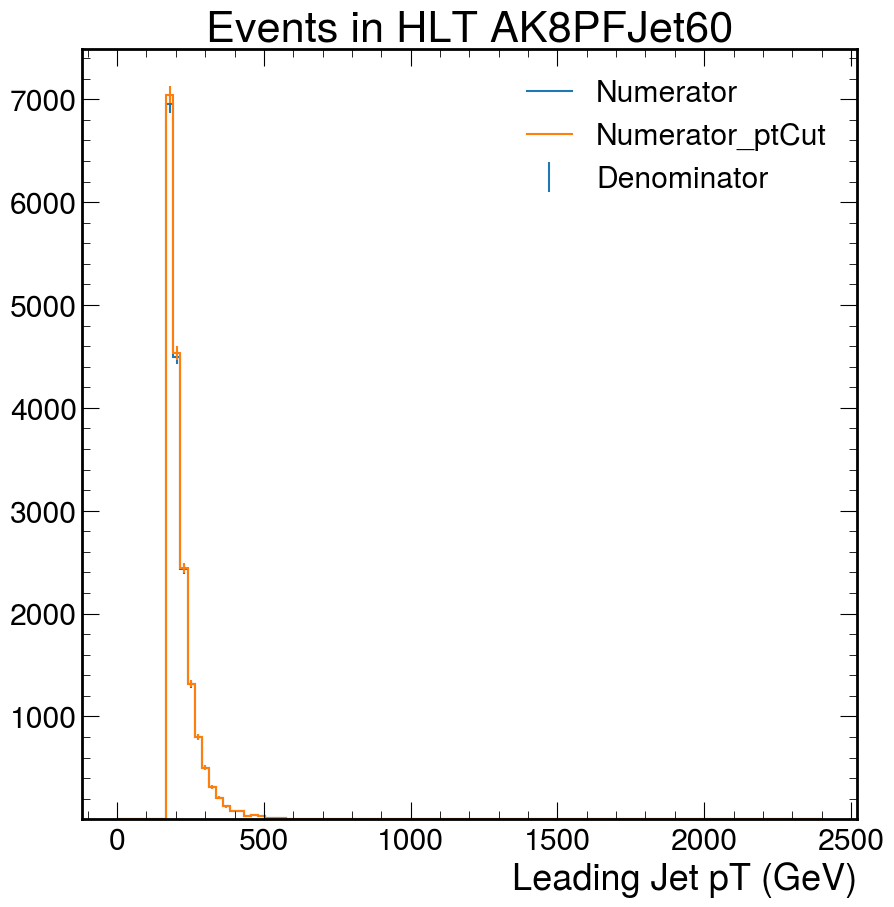

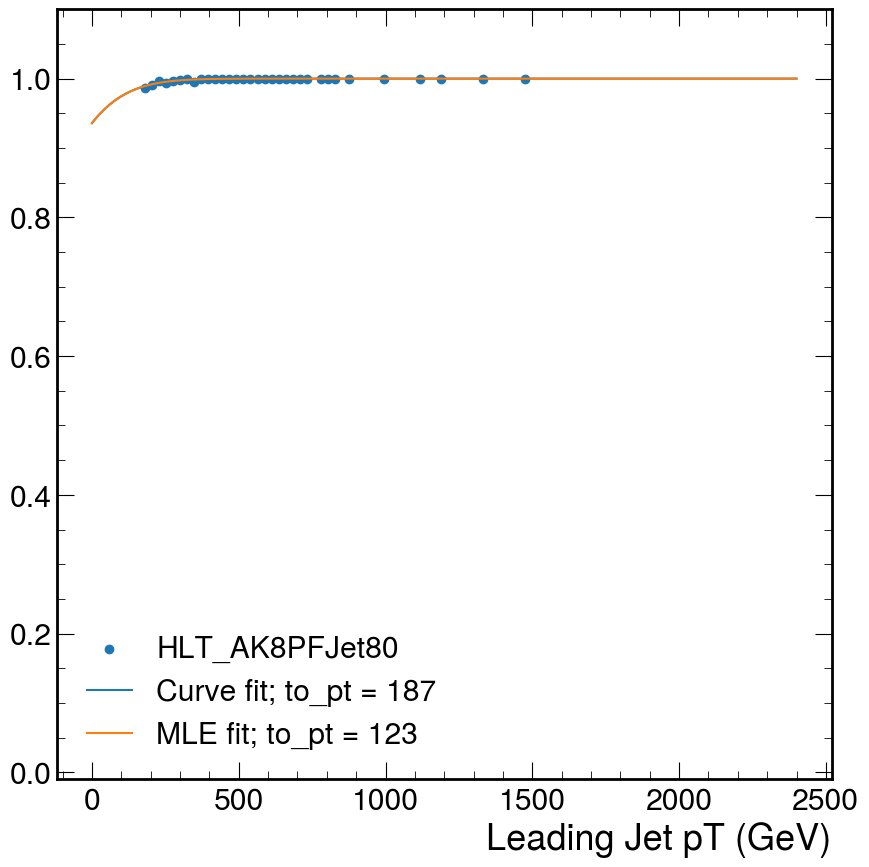

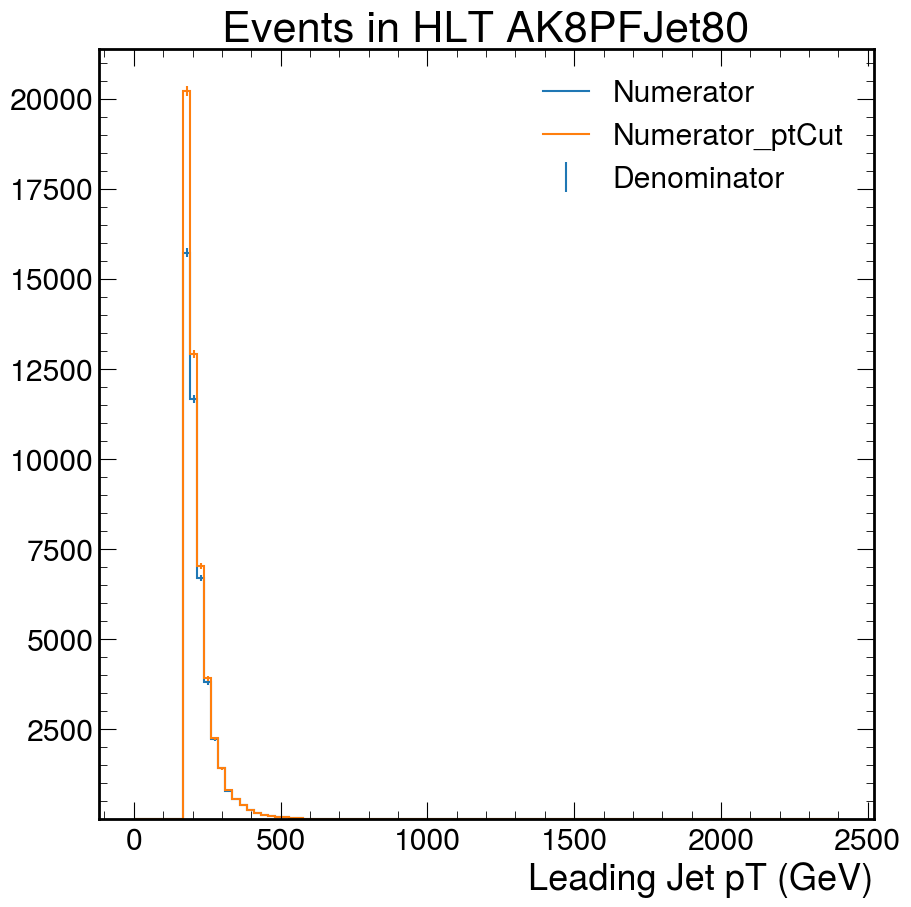

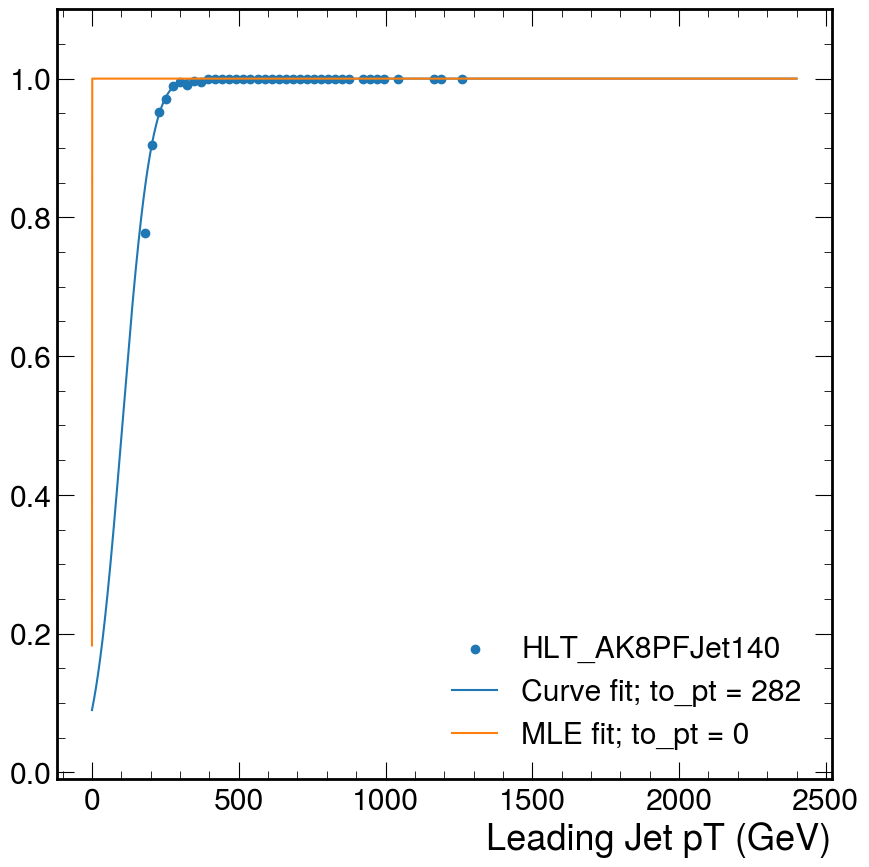

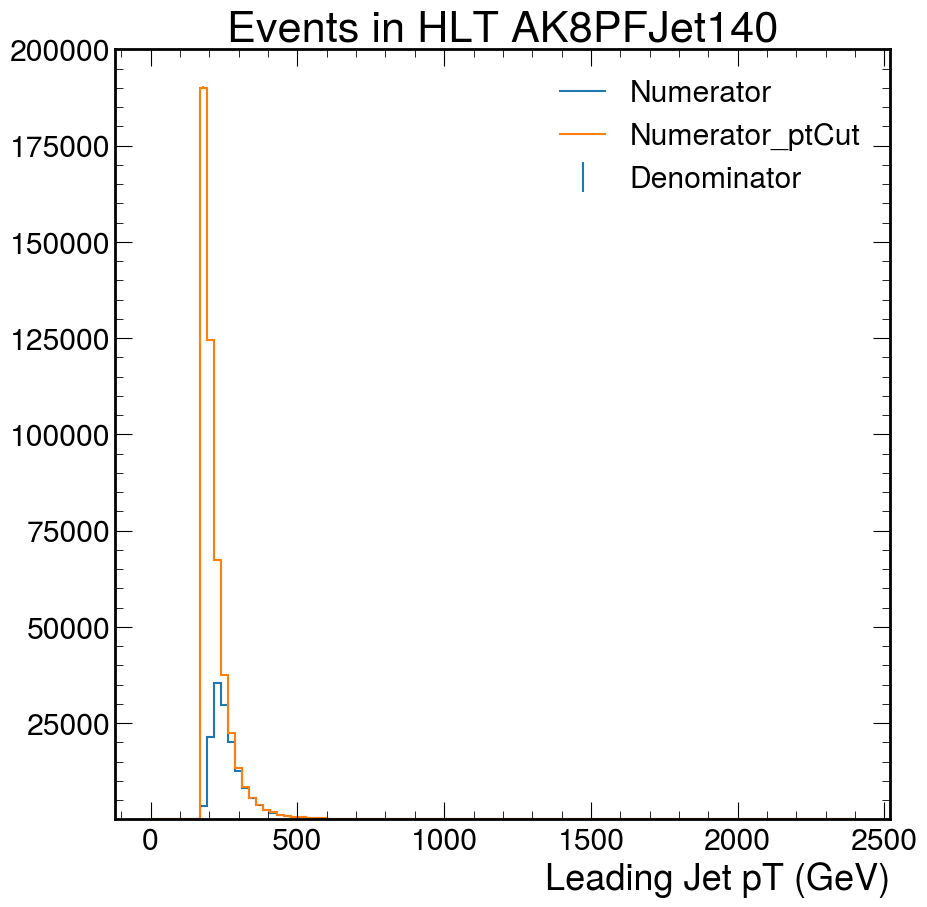

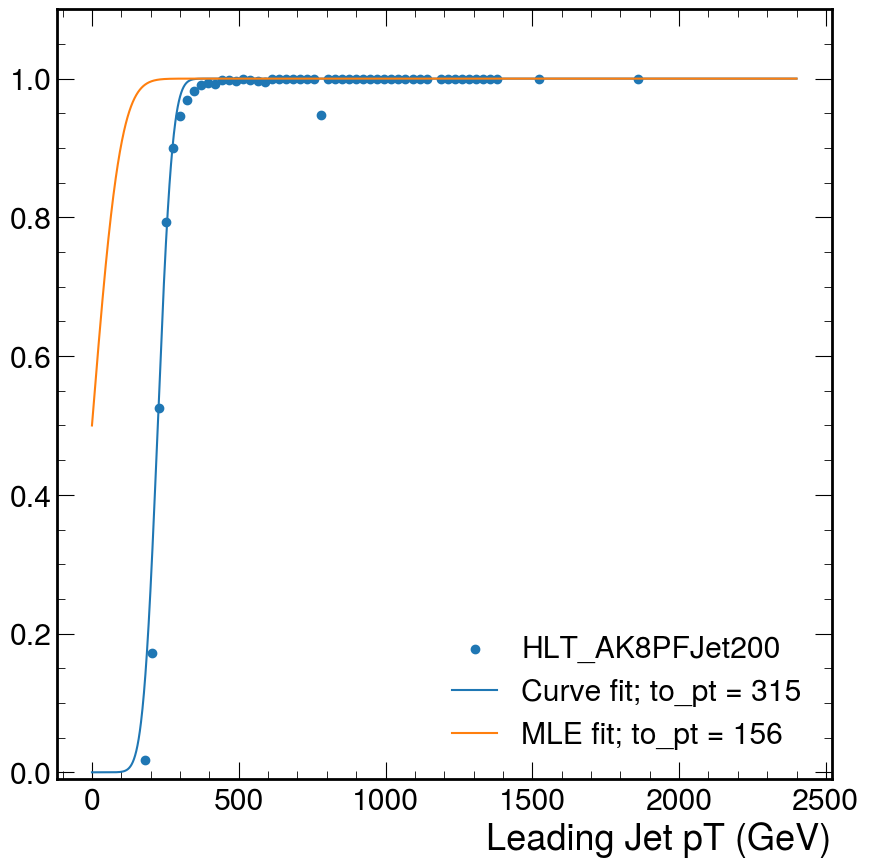

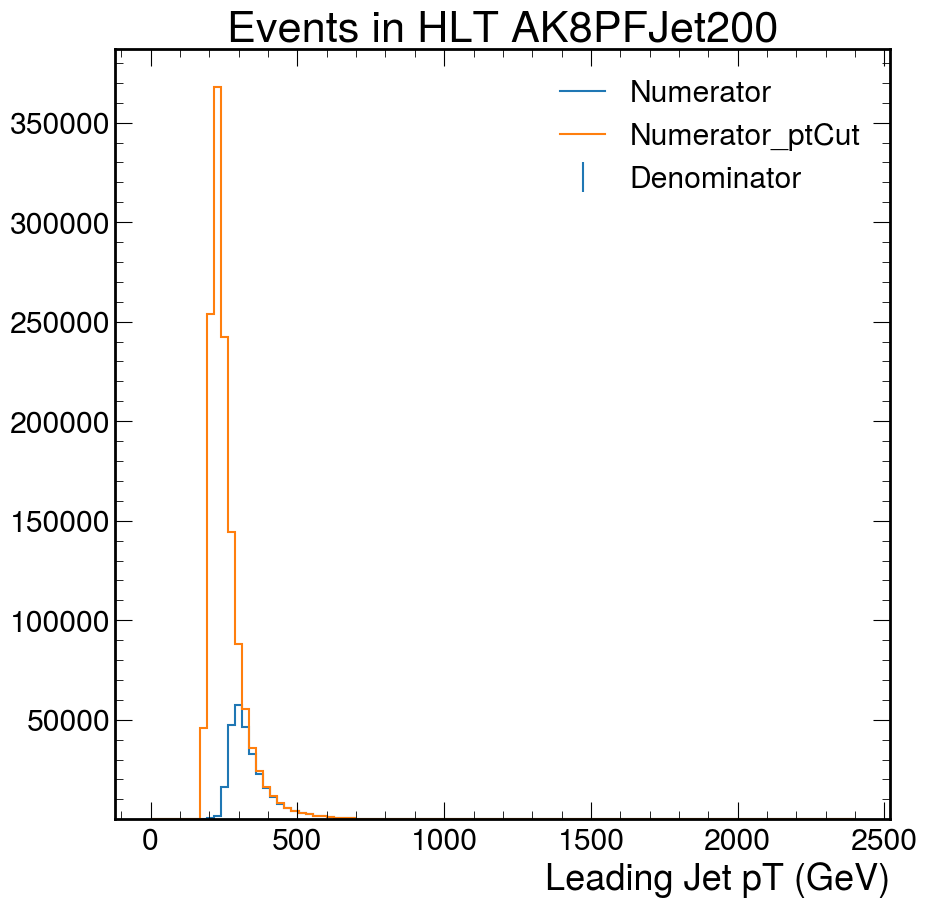

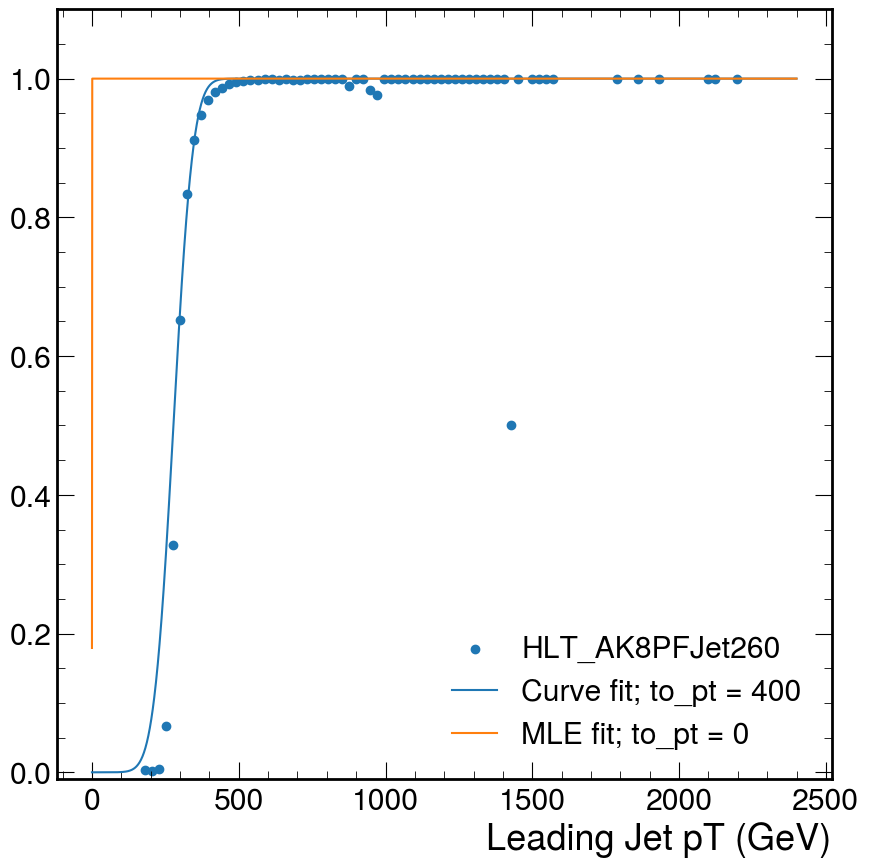

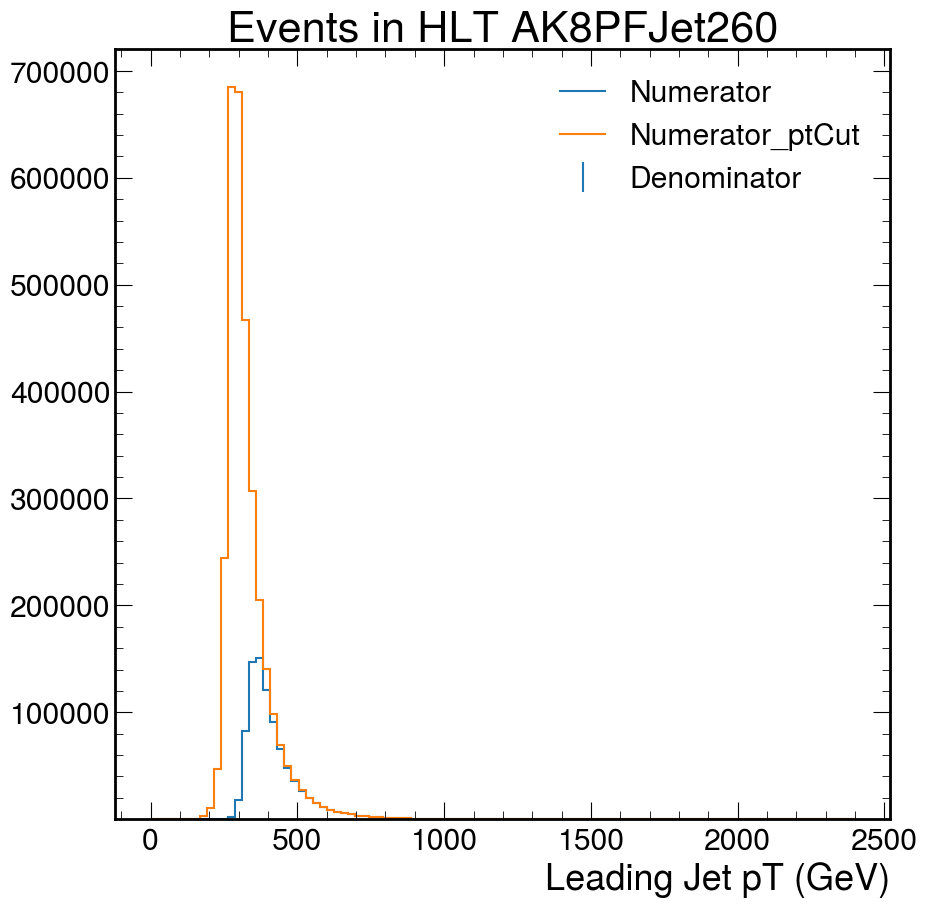

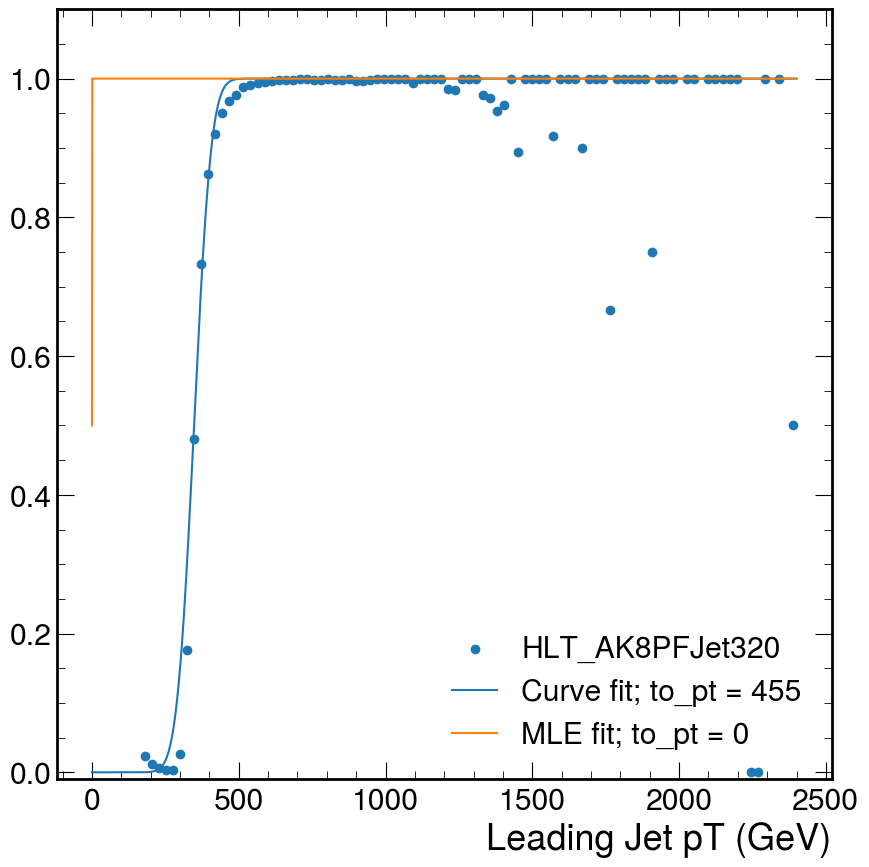

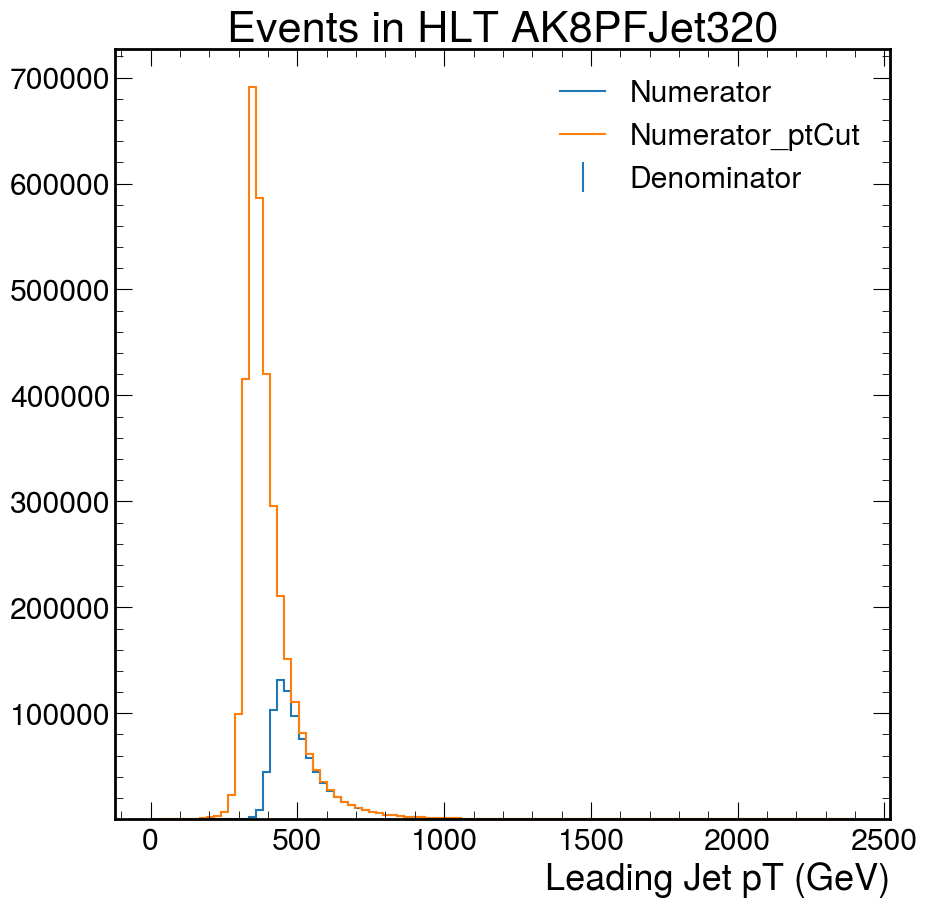

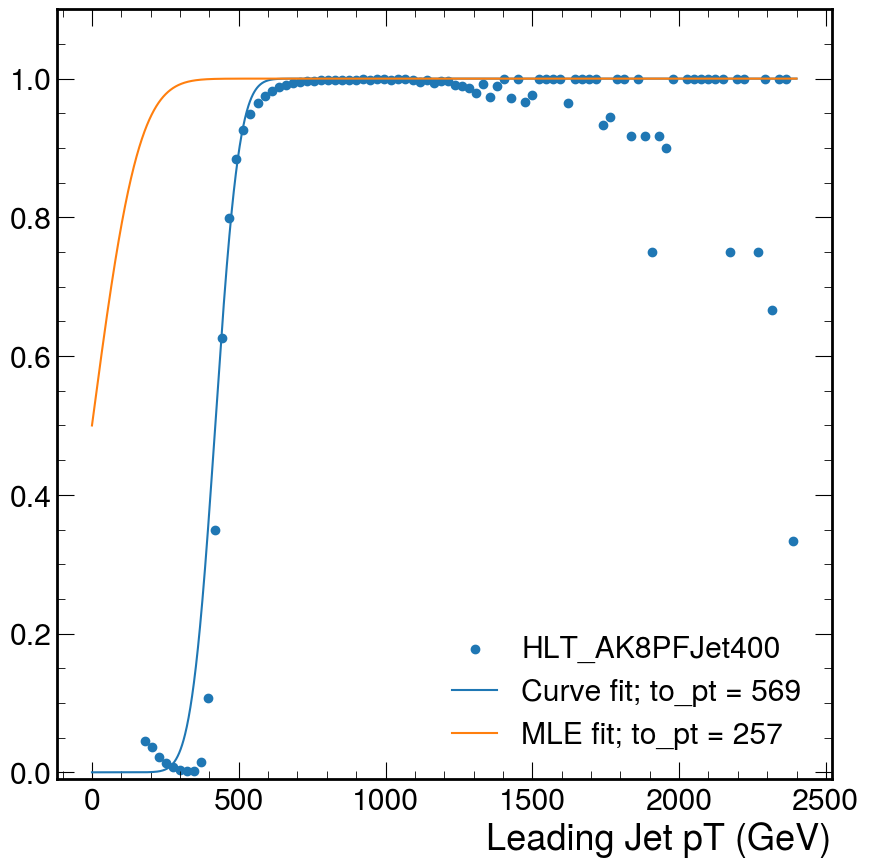

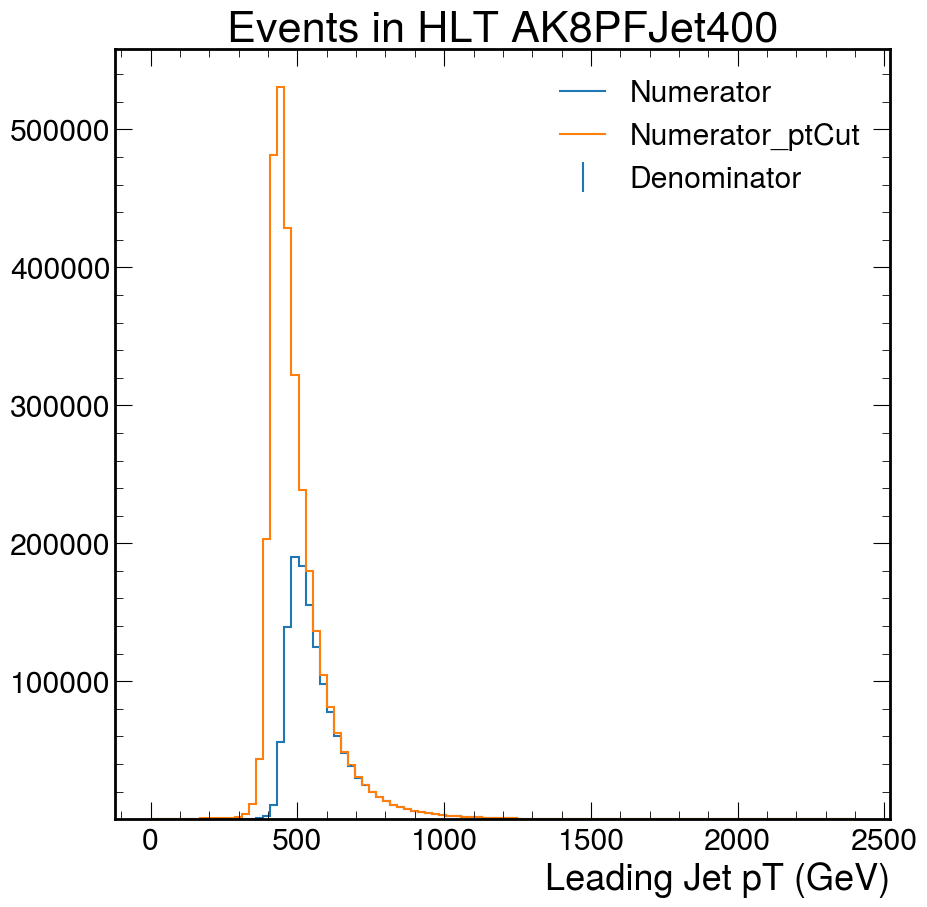

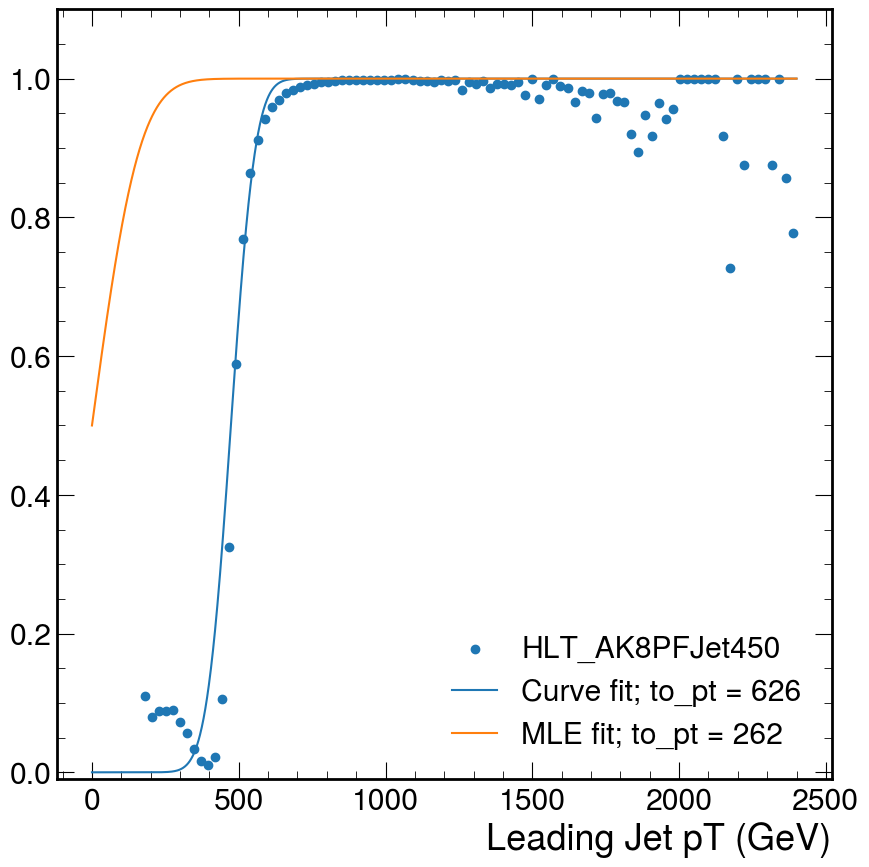

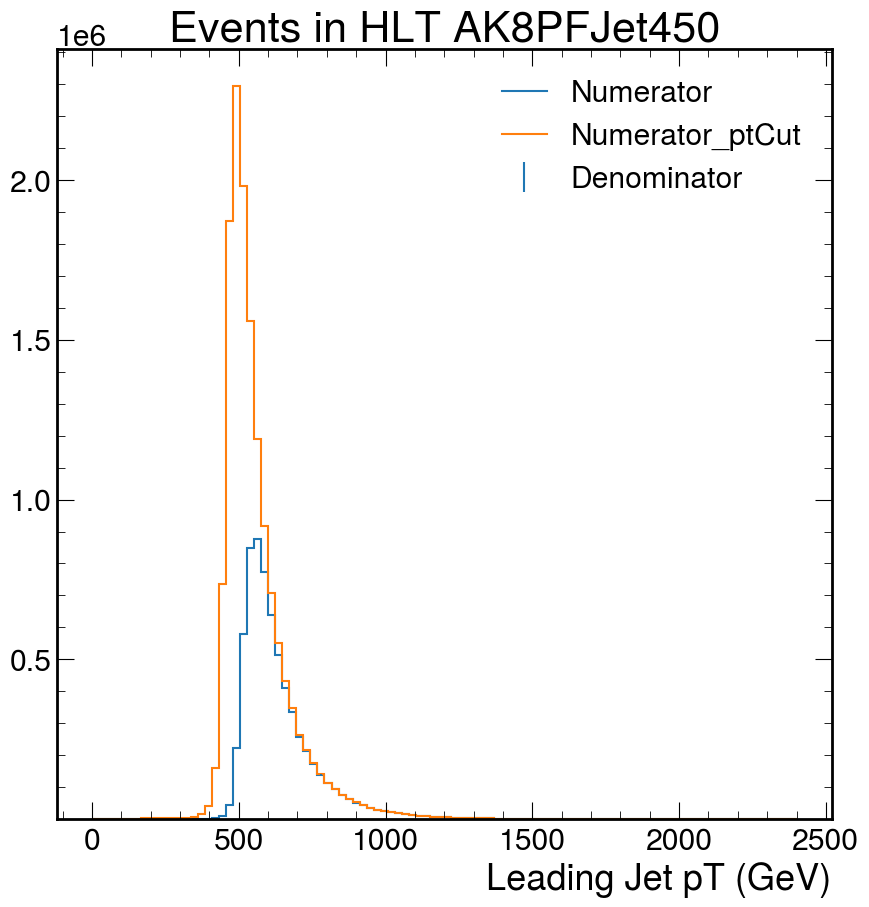

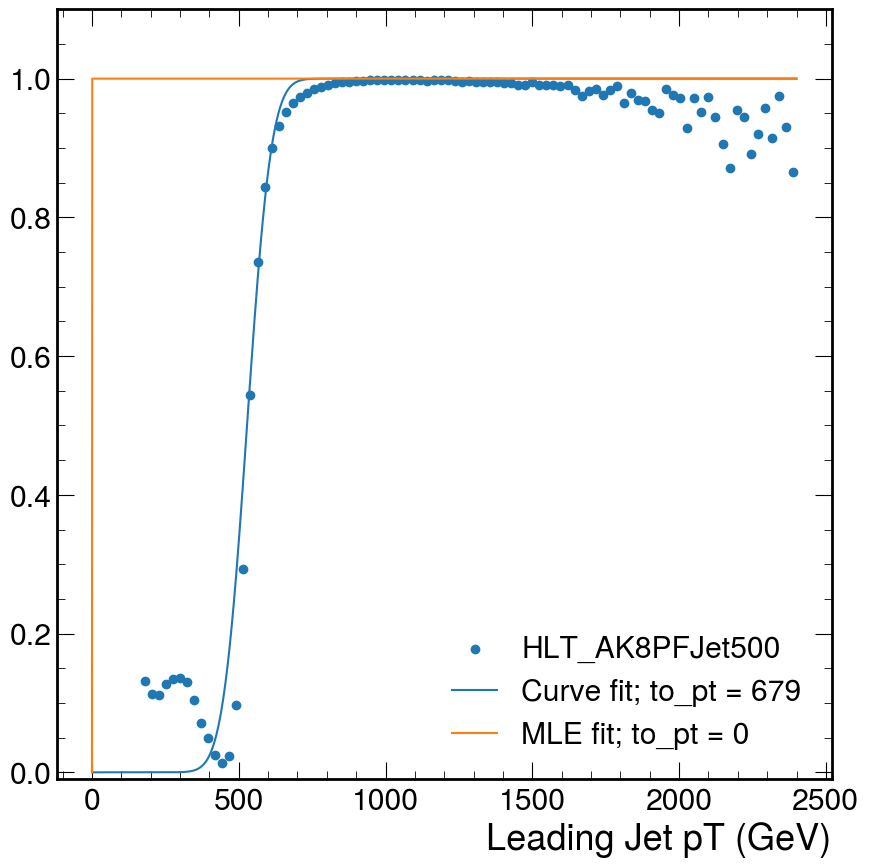

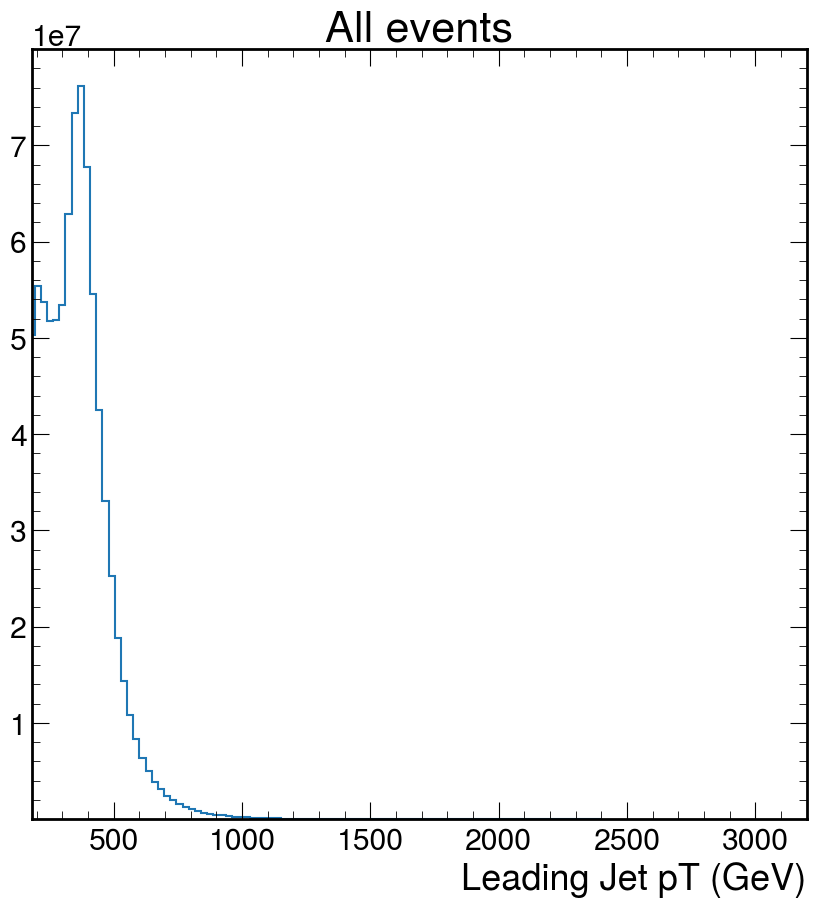

In [92]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_JetHT_2016_AK8PFJet_NewHist.coffea')
turnOnPts = plot_turnOn(result, HLT)
print(turnOnPts)

In [54]:
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/triggerAssignment_QCDsim_2017_AK8PFJet_NewHist.coffea')
# turnOnPts = plot_turnOn(result, HLT)
# print(turnOnPts)

HLT_paths: ['AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
Path =  AK8PFJet60
dataset:  QCDsim2016
Length of efficiency: 95
Basic fit results:  [ 7.22959081e-07 -4.18129997e+02  2.91108056e+02]
Path =  AK8PFJet80
dataset:  QCDsim2016
Length of efficiency: 95
Basic fit results:  [ 1.43745495e-06 -2.88769071e+02  2.53084105e+02]
Path =  AK8PFJet140
dataset:  QCDsim2016
Length of efficiency: 95
Basic fit results:  [2.74999711e-06 3.59638956e+01 1.43093402e+02]
Path =  AK8PFJet200
dataset:  QCDsim2016
Length of efficiency: 95
Basic fit results:  [-1.67225429e-04  2.03466869e+02  7.17470752e+01]
Path =  AK8PFJet260
dataset:  QCDsim2016
Length of efficiency: 95
Basic fit results:  [-3.24395835e-04  2.63300951e+02  6.94262291e+01]
Path =  AK8PFJet320
dataset:  QCDsim2016
Length of efficiency: 95
Basic fit results:  [-1.73731055e-04  3.07412324e+02  9.60213179e+01]
Path =  AK8PFJet400
dataset:  QCDsim2016
Len

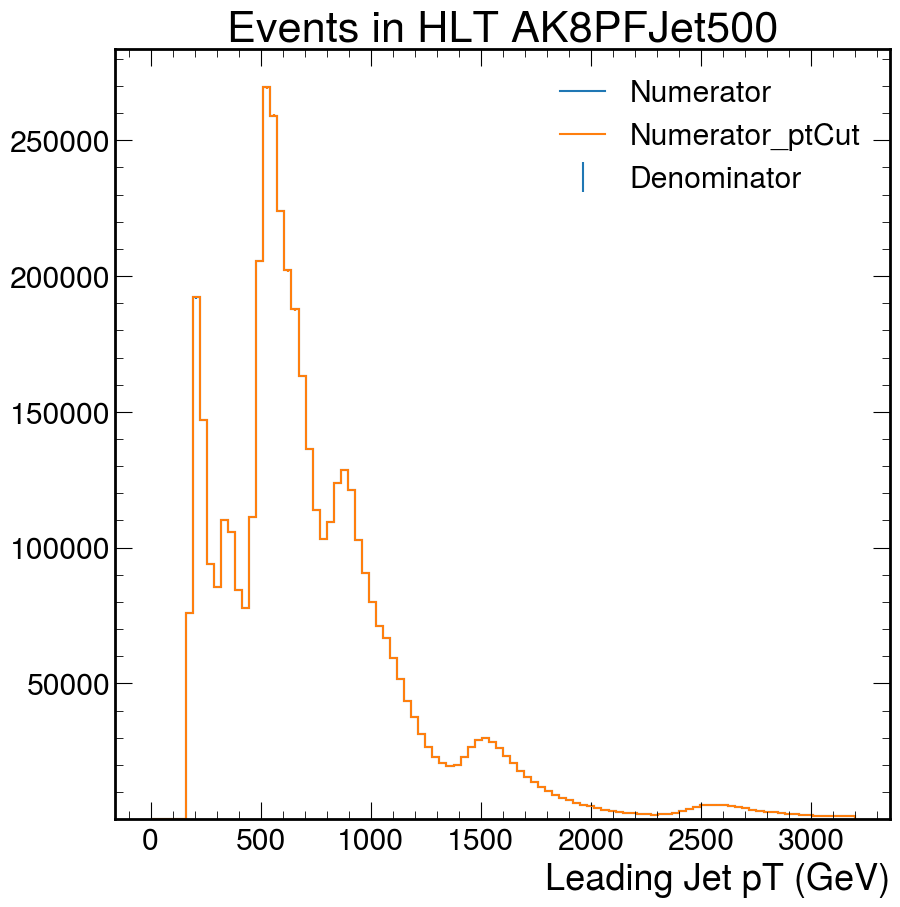

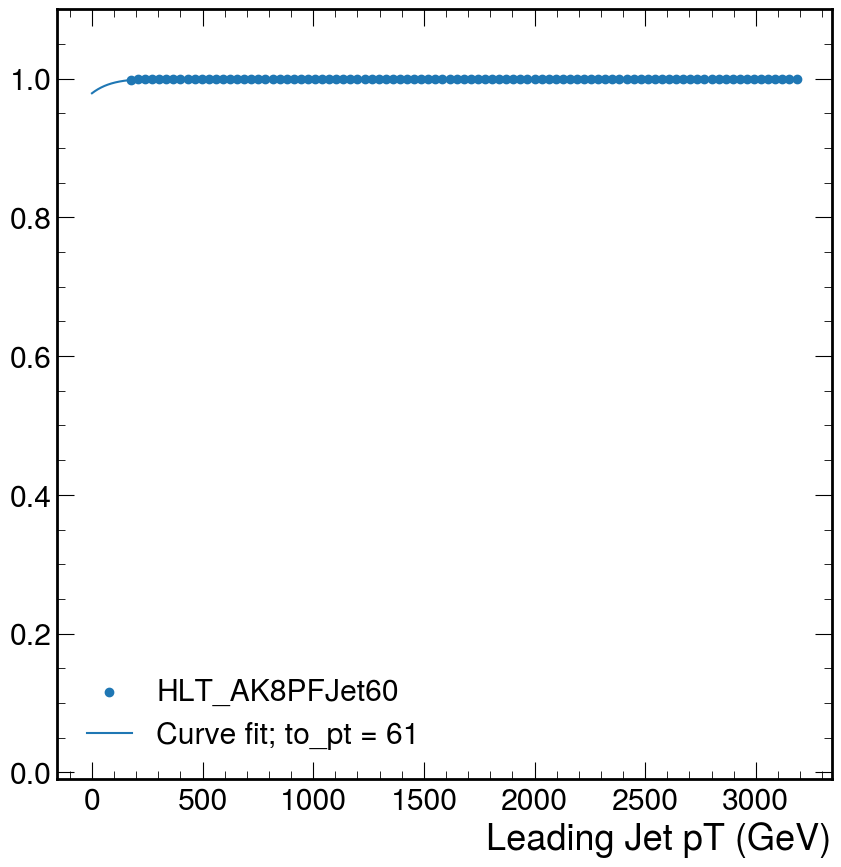

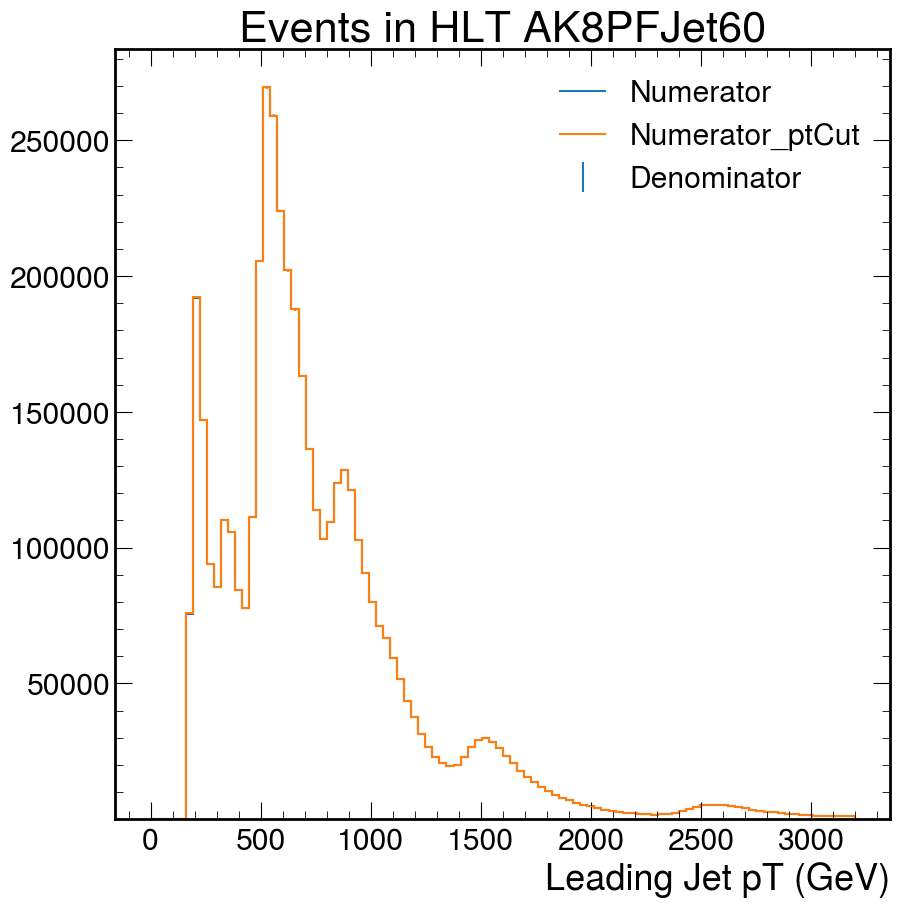

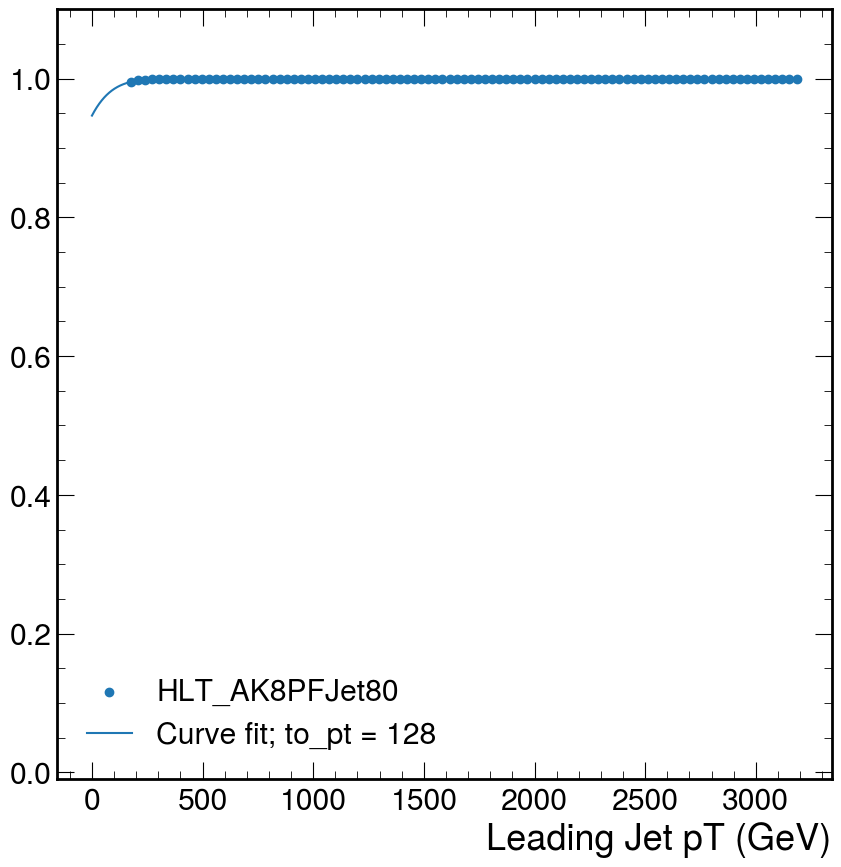

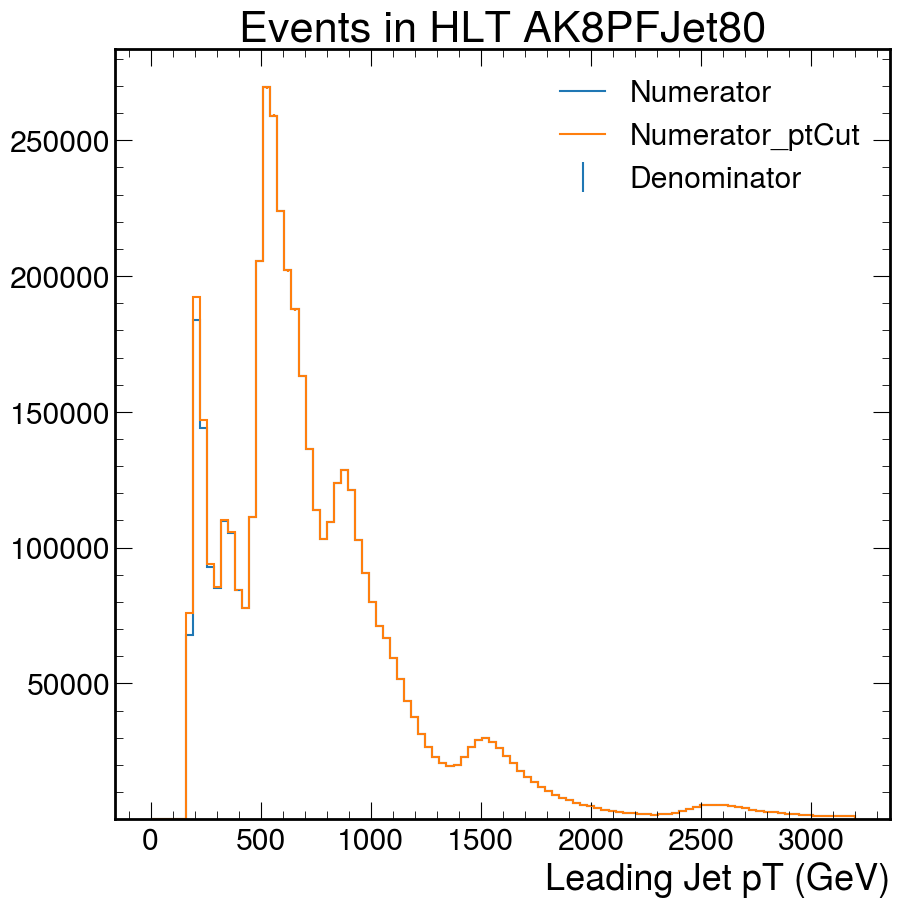

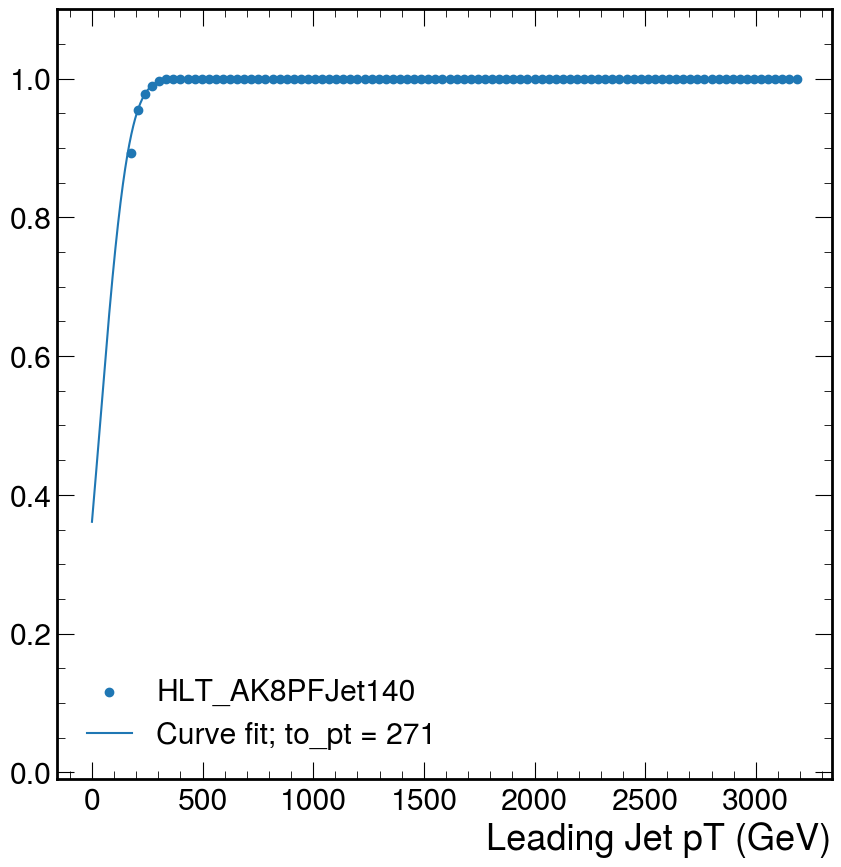

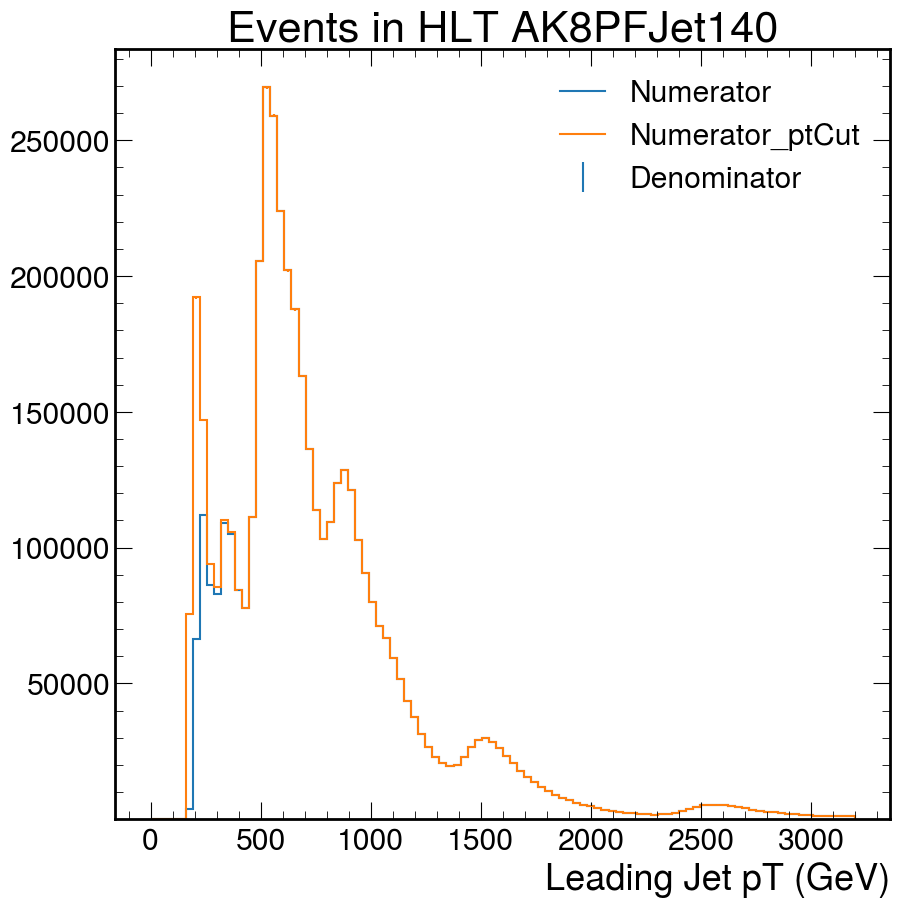

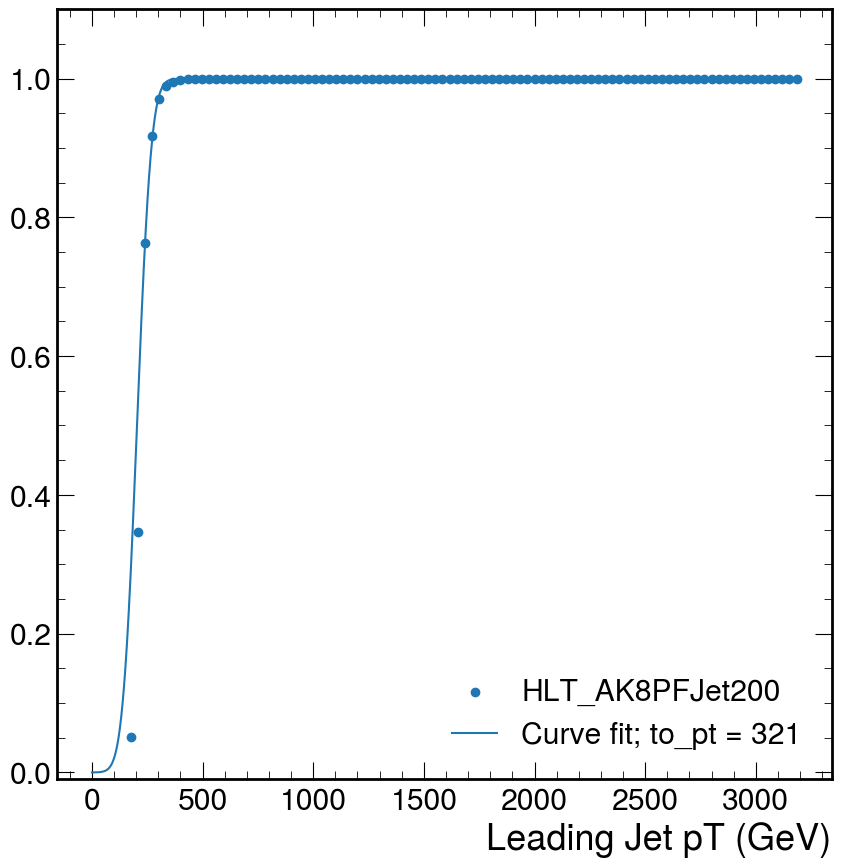

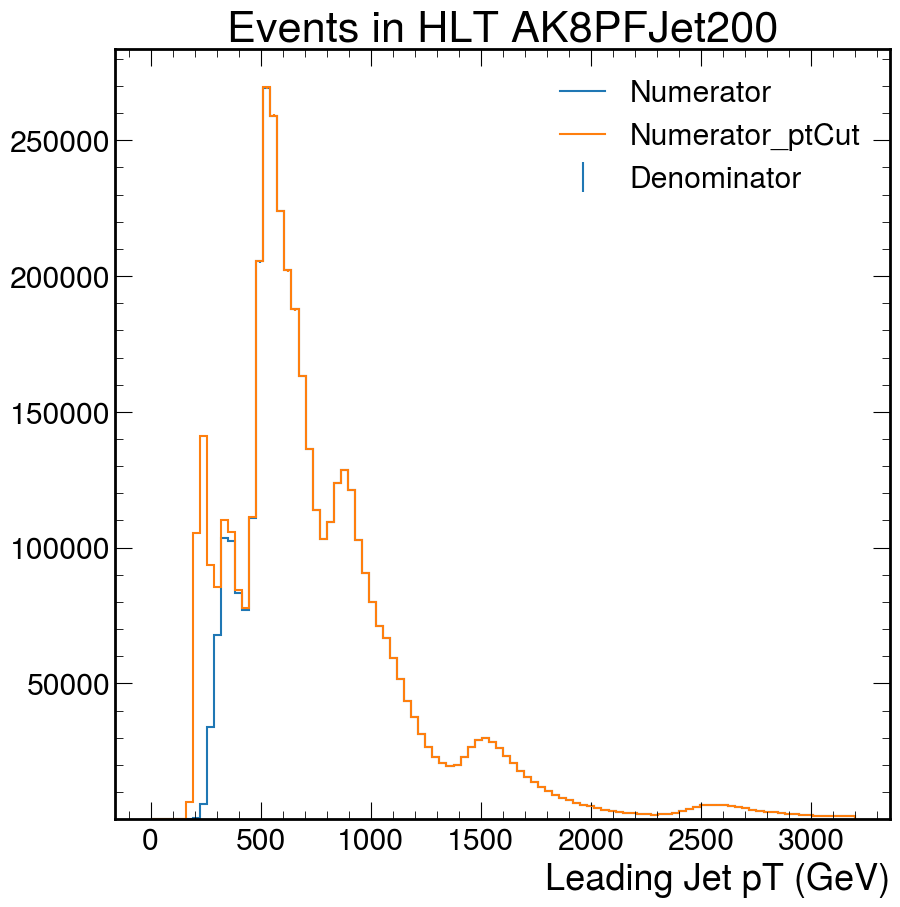

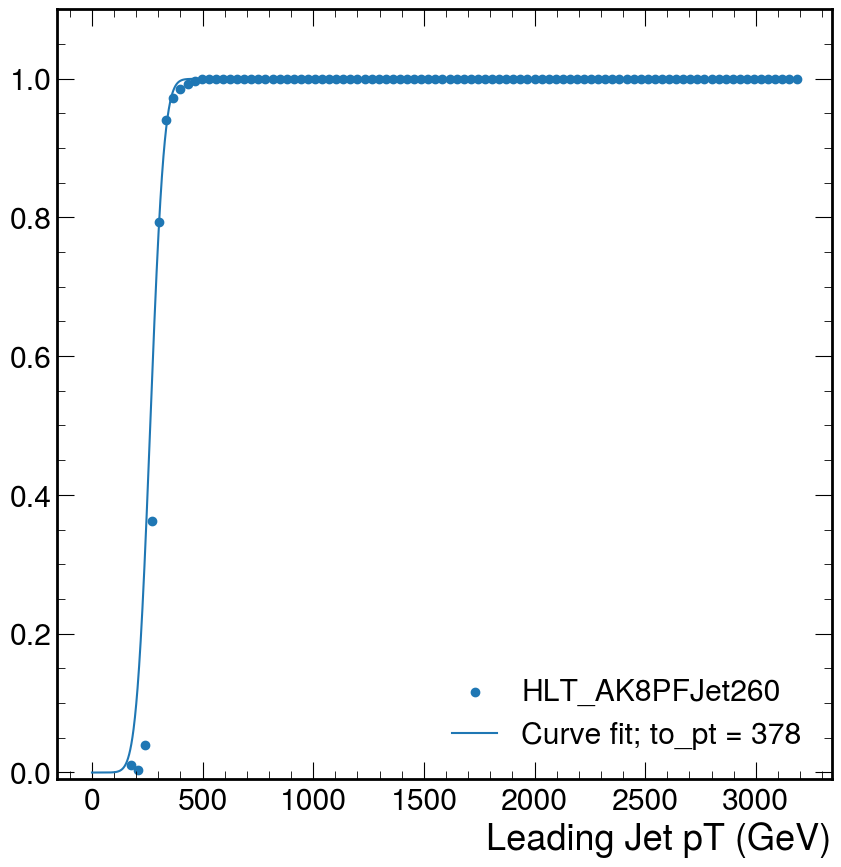

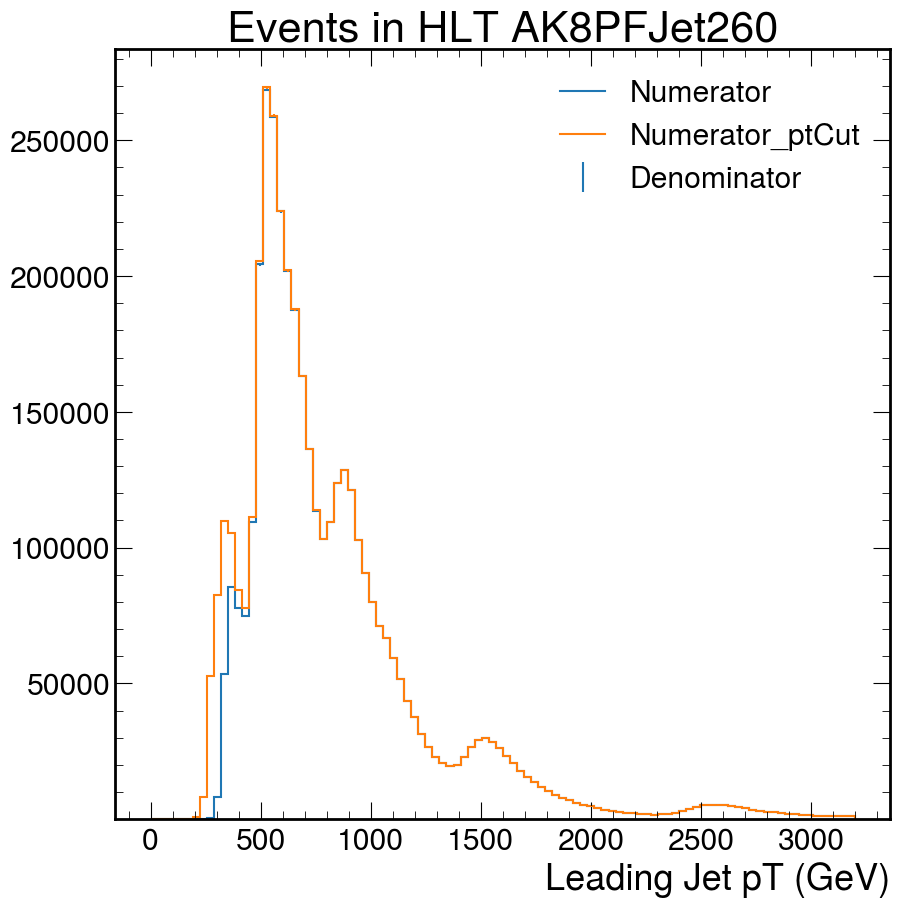

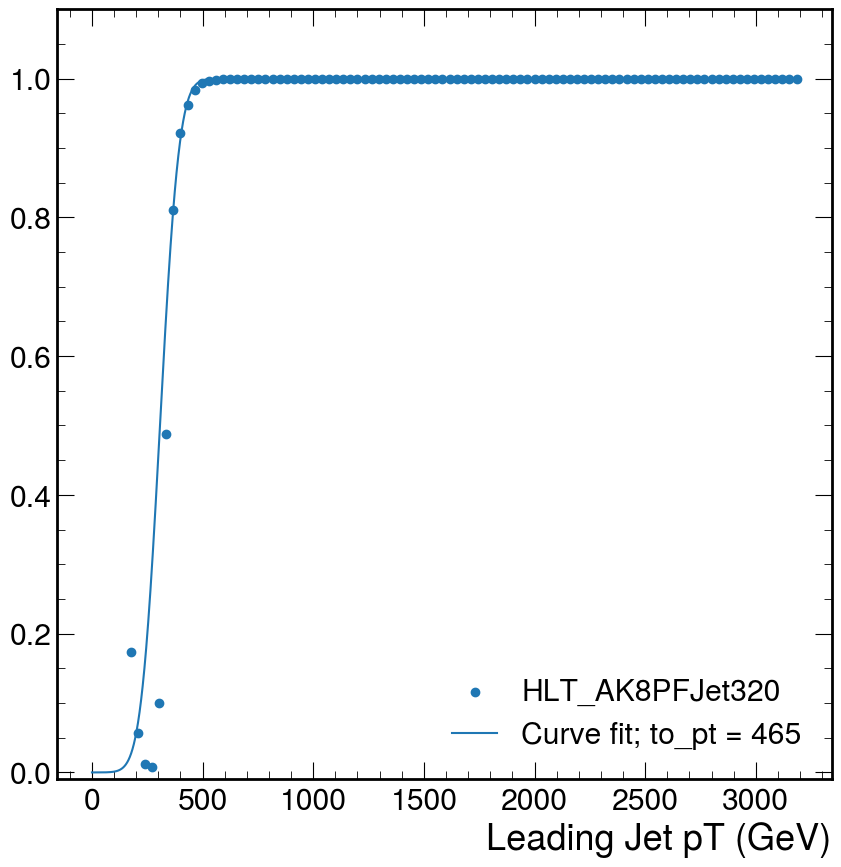

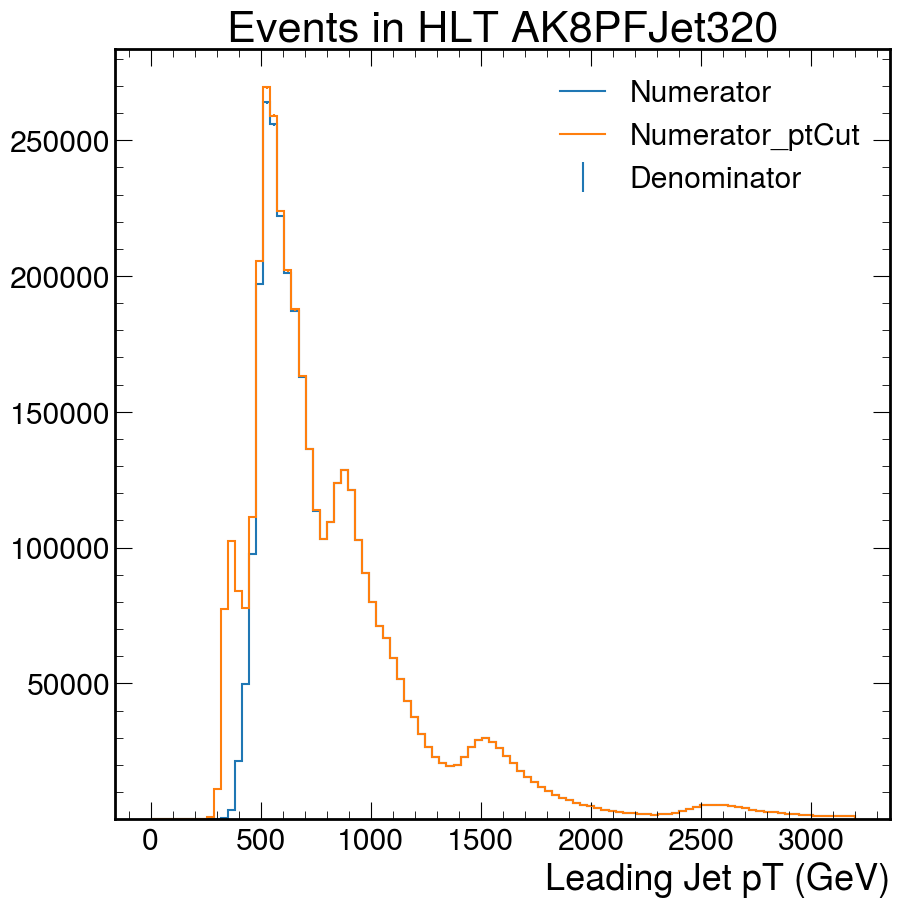

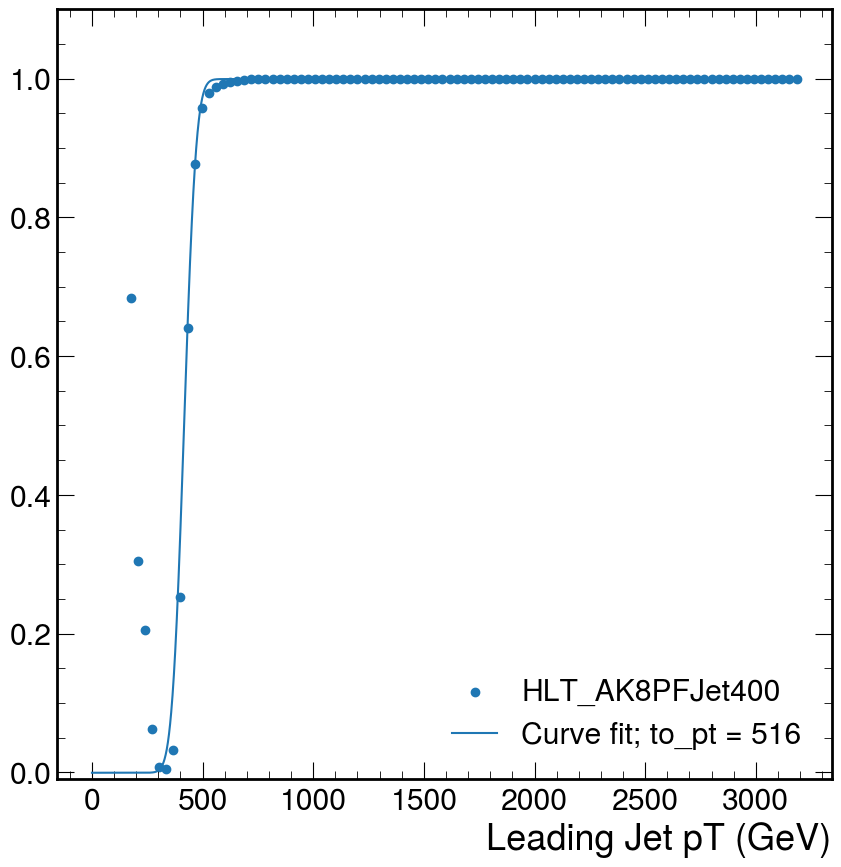

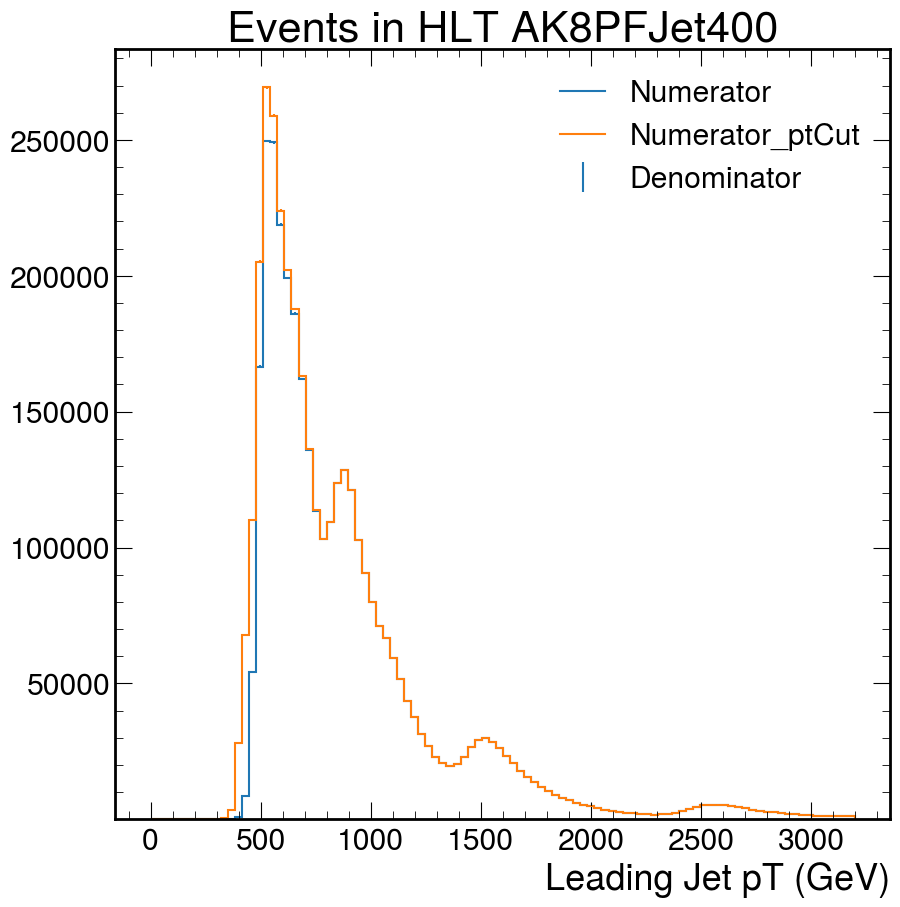

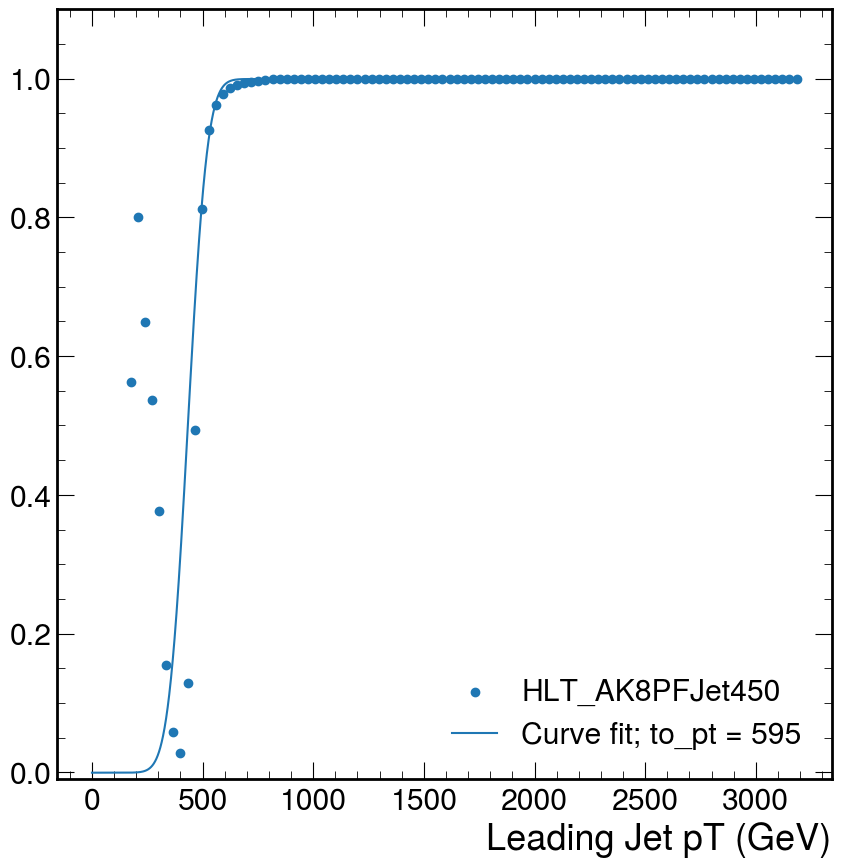

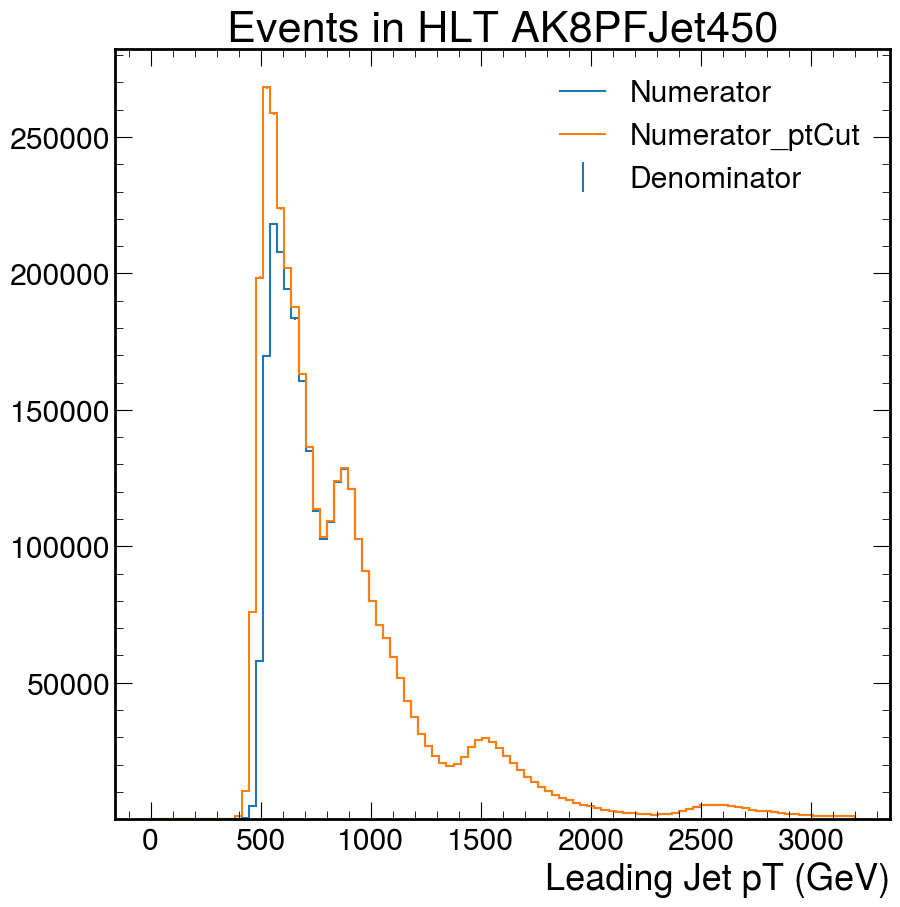

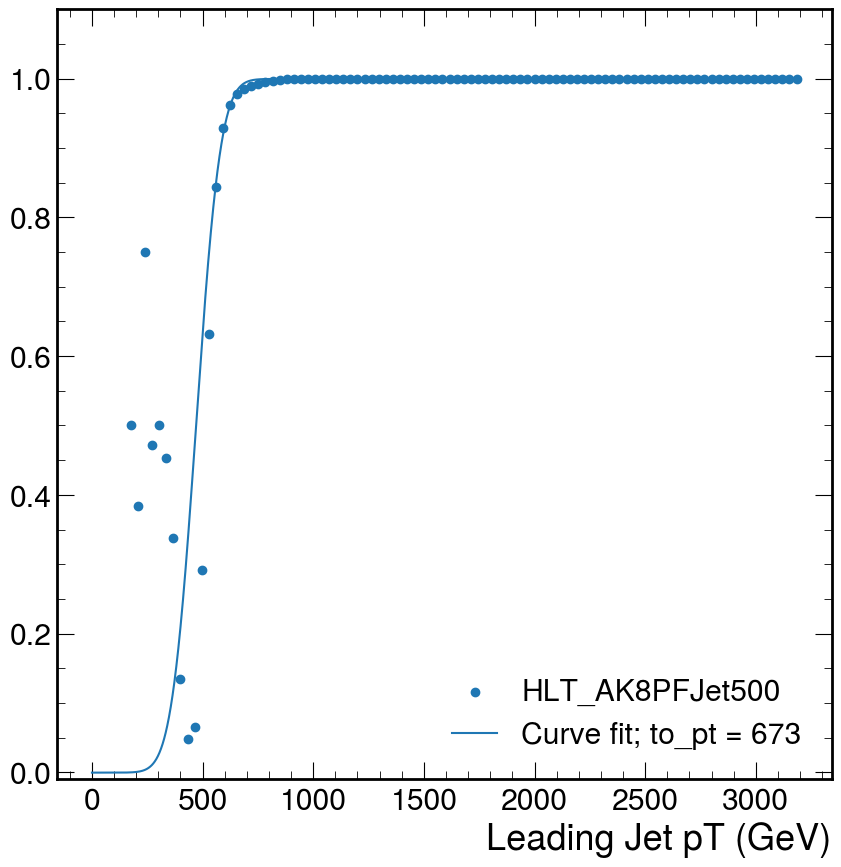

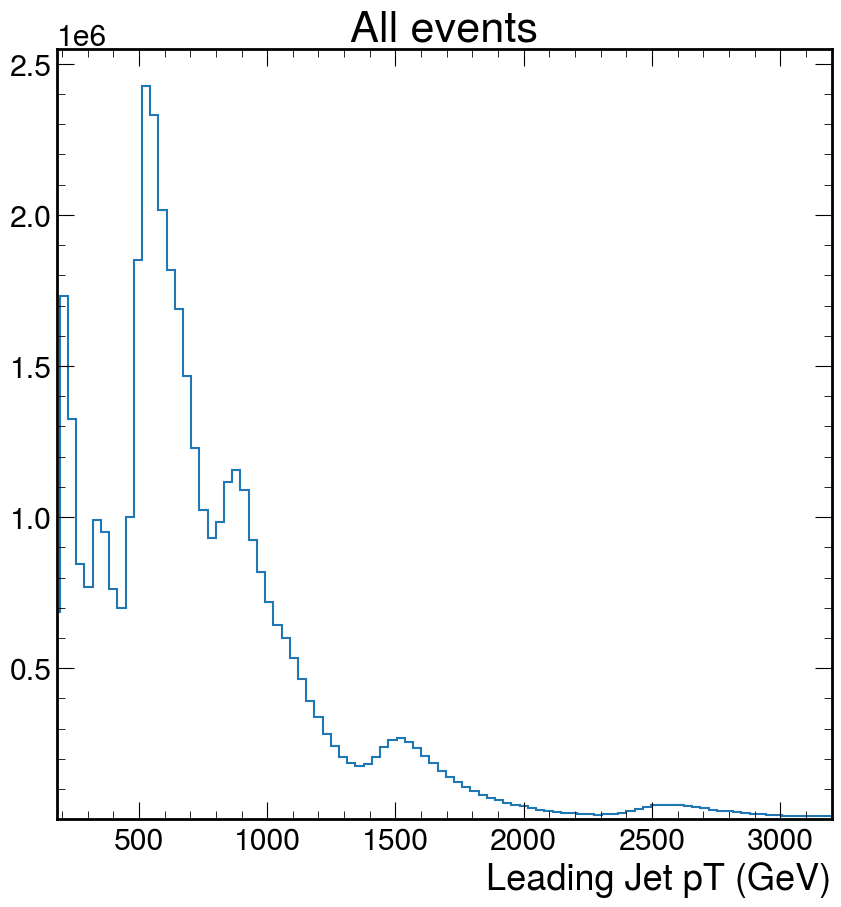

In [55]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_QCDsim_2016_AK8PFJet_test_NewHist.coffea')
turnOnPts = plot_turnOn(result, HLT)
print(turnOnPts)

HLT_paths: ['AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
Path =  AK8PFJet60
dataset:  JetHT2016
Length of efficiency: 8


/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Basic fit results:  [-1199.75248624   219.00005115]
MLE results:  [-1199.7524862425246, 219.00005115293436, 0.0, 1.0]
Path =  AK8PFJet80
dataset:  JetHT2016
Length of efficiency: 12


/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Basic fit results:  [190.05639898   6.05443299]
MLE results:  [190.0563989803072, 6.054432990811923, 0.0, 1.0]
Path =  AK8PFJet140
dataset:  JetHT2016
Length of efficiency: 19
Basic fit results:  [156.43357972  35.01413809]
MLE results:  [0.13342371143426912, 0.04431537232882998, 0.0, 1.0]
Path =  AK8PFJet200
dataset:  JetHT2016
Length of efficiency: 22
Basic fit results:  [225.3407151   35.72969393]
MLE results:  [0.06647809060575295, 0.053232883221198346, 0.0, 1.0]
Path =  AK8PFJet260
dataset:  JetHT2016
Length of efficiency: 37
Basic fit results:  [283.77289764  45.48637085]
MLE results:  [0.035960845682429535, 0.03300499469175788, 0.0, 1.0]
Path =  AK8PFJet320
dataset:  JetHT2016
Length of efficiency: 51
Basic fit results:  [349.70037488  44.40601361]
MLE results:  [0.04431544139909707, 0.032221085475907074, 0.0, 1.0]
Path =  AK8PFJet400
dataset:  JetHT2016
Length of efficiency: 63
Basic fit results:  [418.20658305  66.58946116]
MLE results:  [0.1378082269832358, 0.0031457960570021

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Basic fit results:  [528.74313898  65.53090432]
MLE results:  [0.17423244268484858, 0.0030957880852544584, 0.0, 1.0]
{'AK8PFJet60': -690.2821828280603, 'AK8PFJet80': 204.14111629700525, 'AK8PFJet140': 237.8886454252076, 'AK8PFJet200': 308.460412624044, 'AK8PFJet260': 389.5900197651587, 'AK8PFJet320': 453.00421022986643, 'AK8PFJet400': 573.1168344615611, 'AK8PFJet450': 624.4678699784871, 'AK8PFJet500': 681.1908189237497}


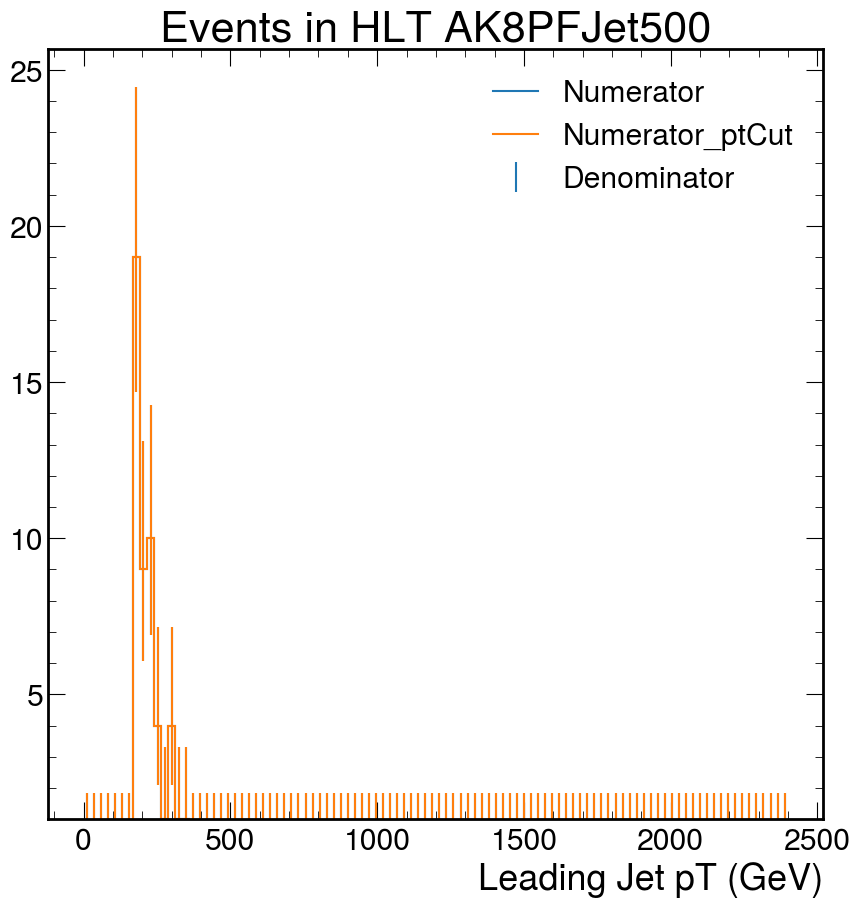

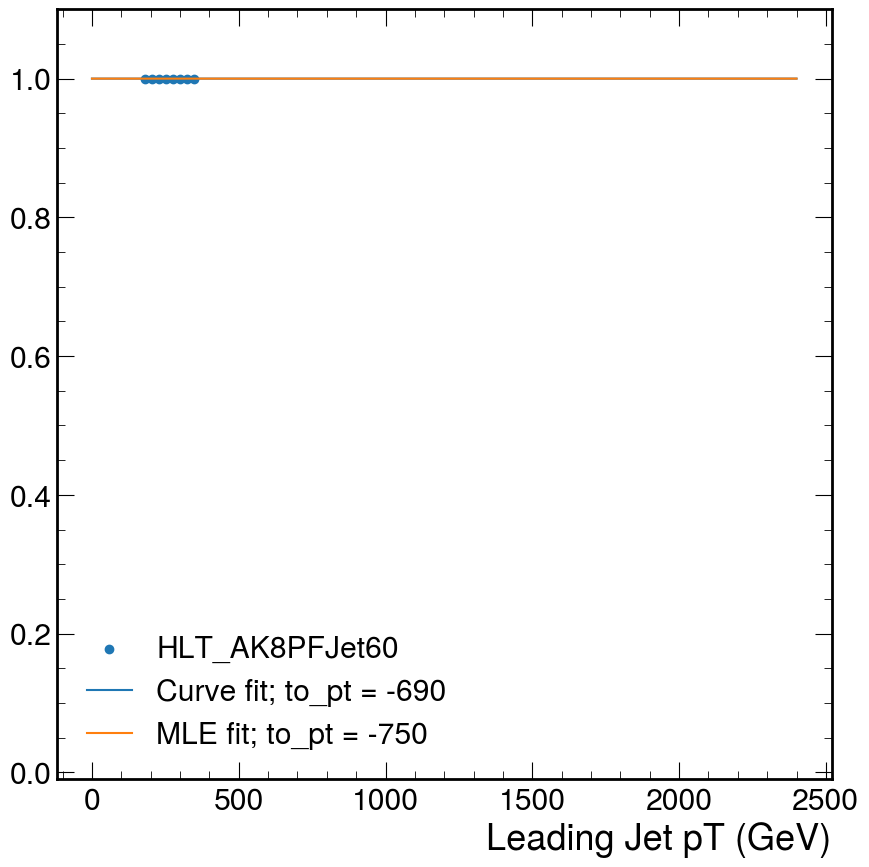

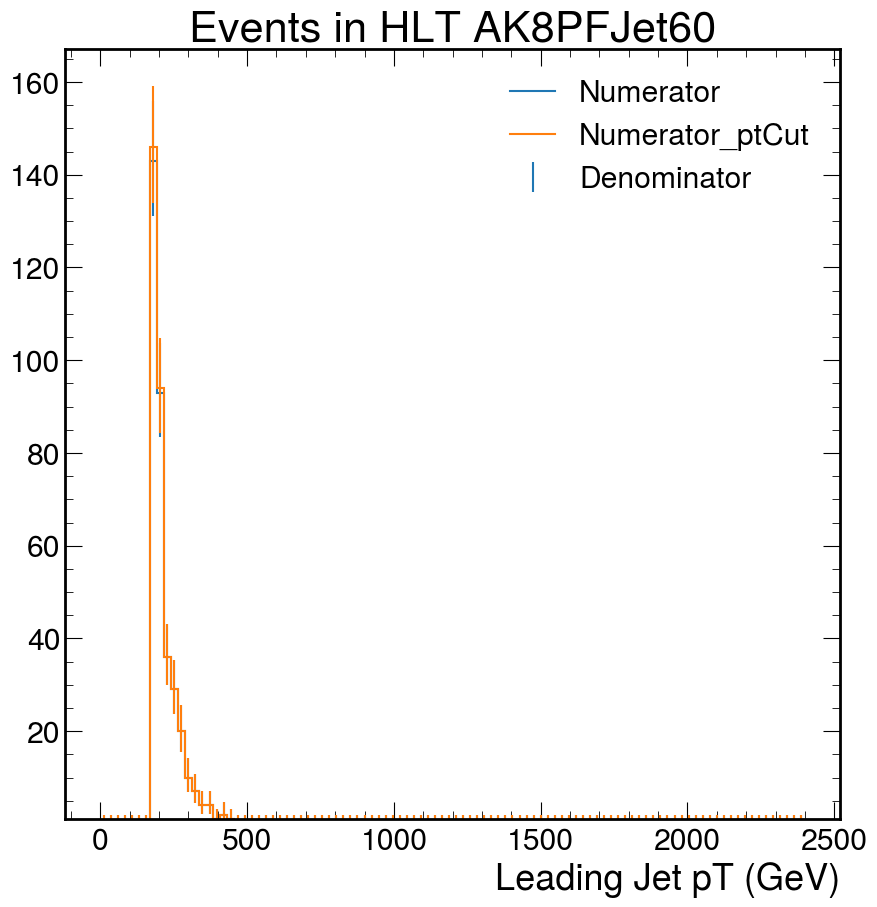

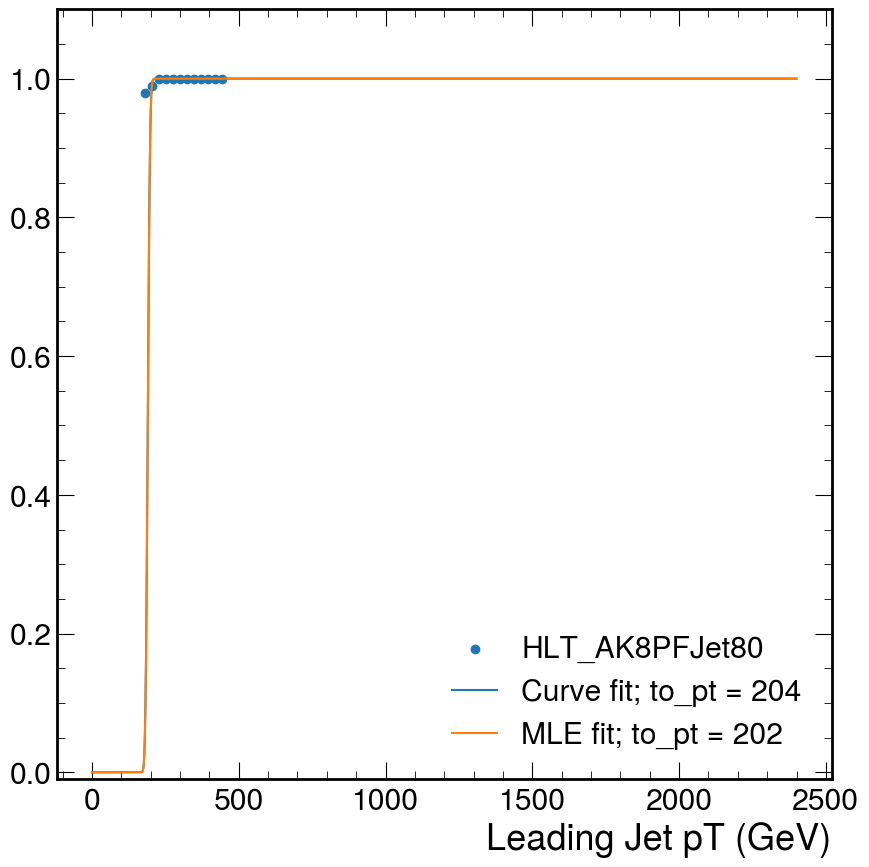

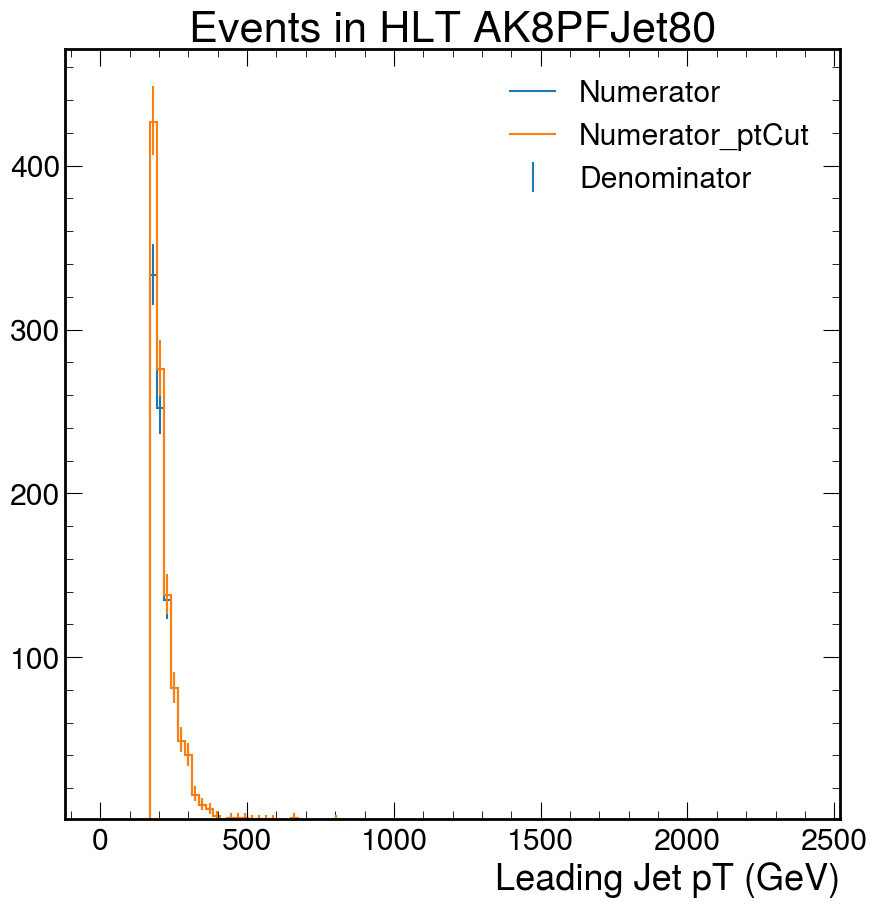

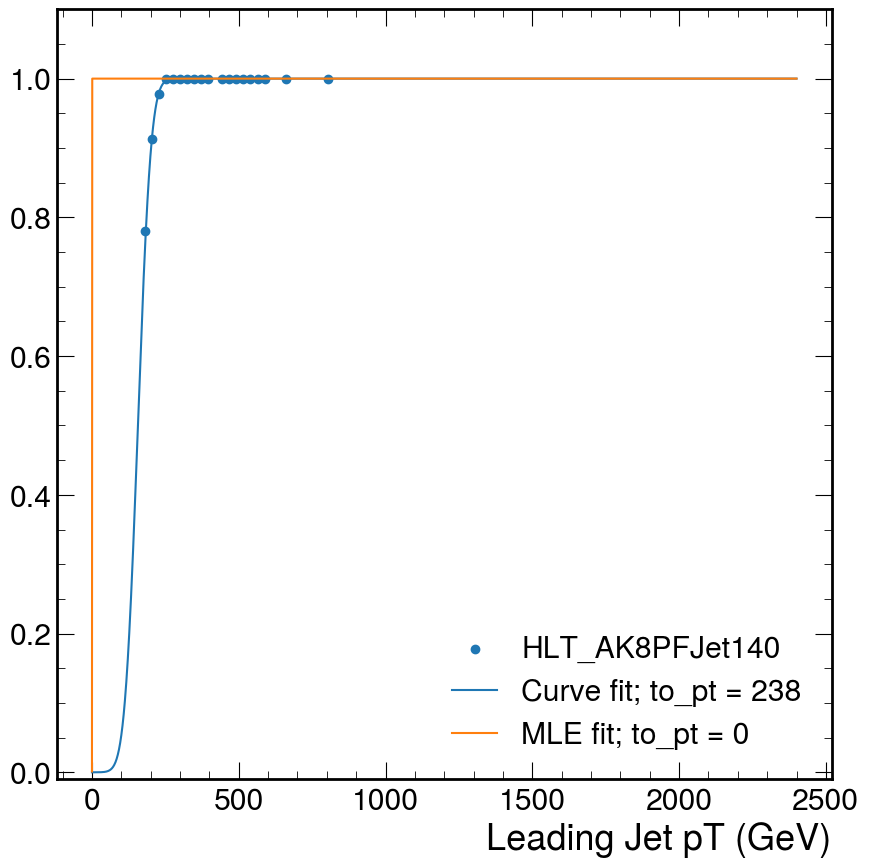

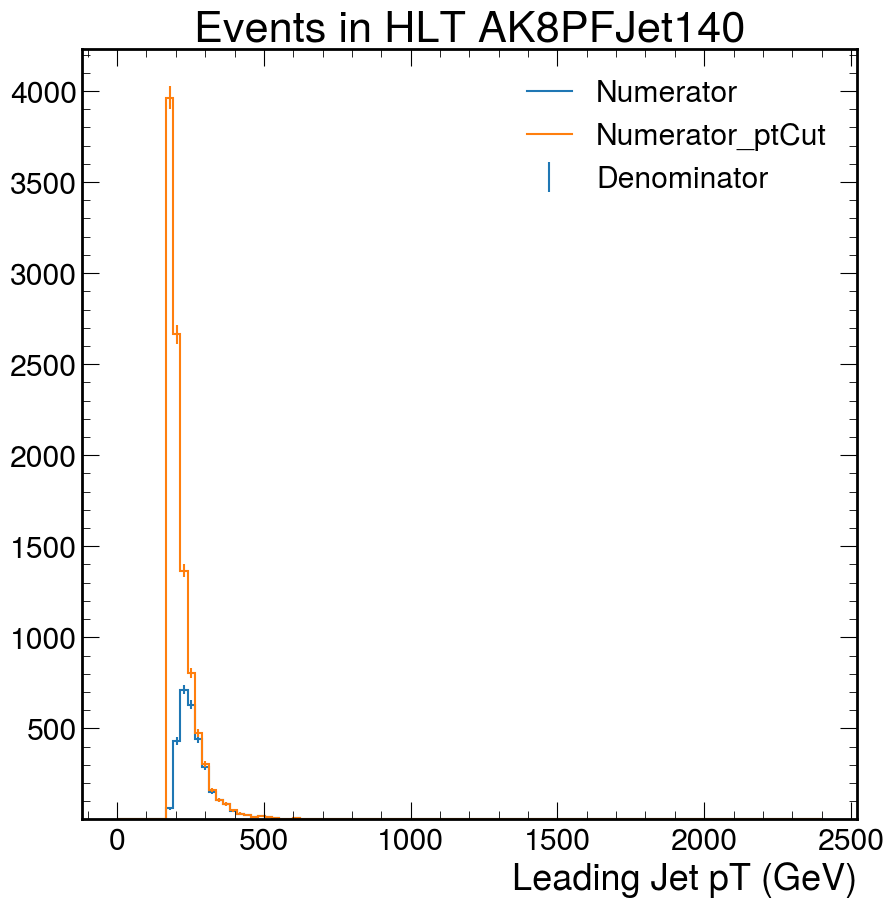

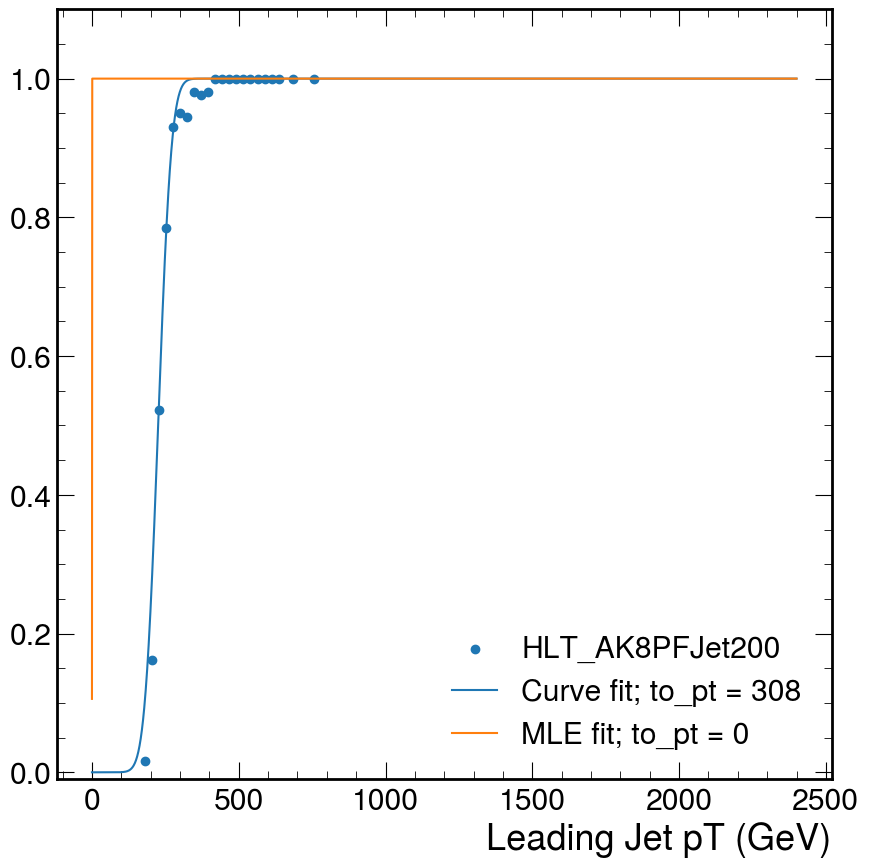

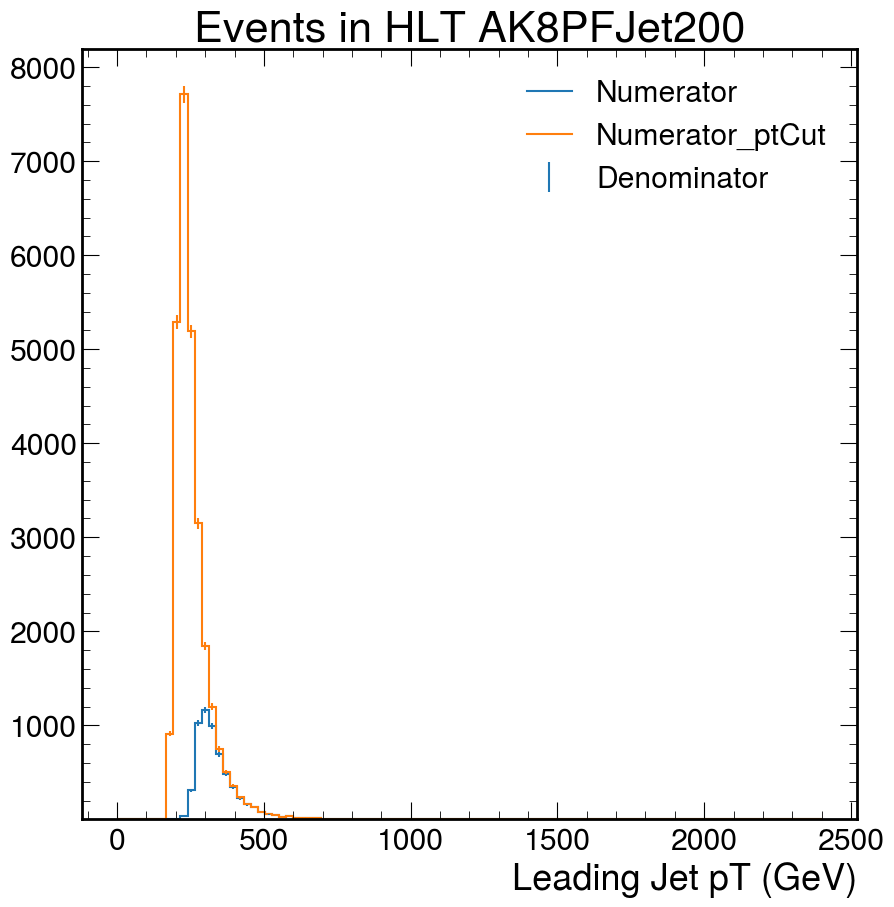

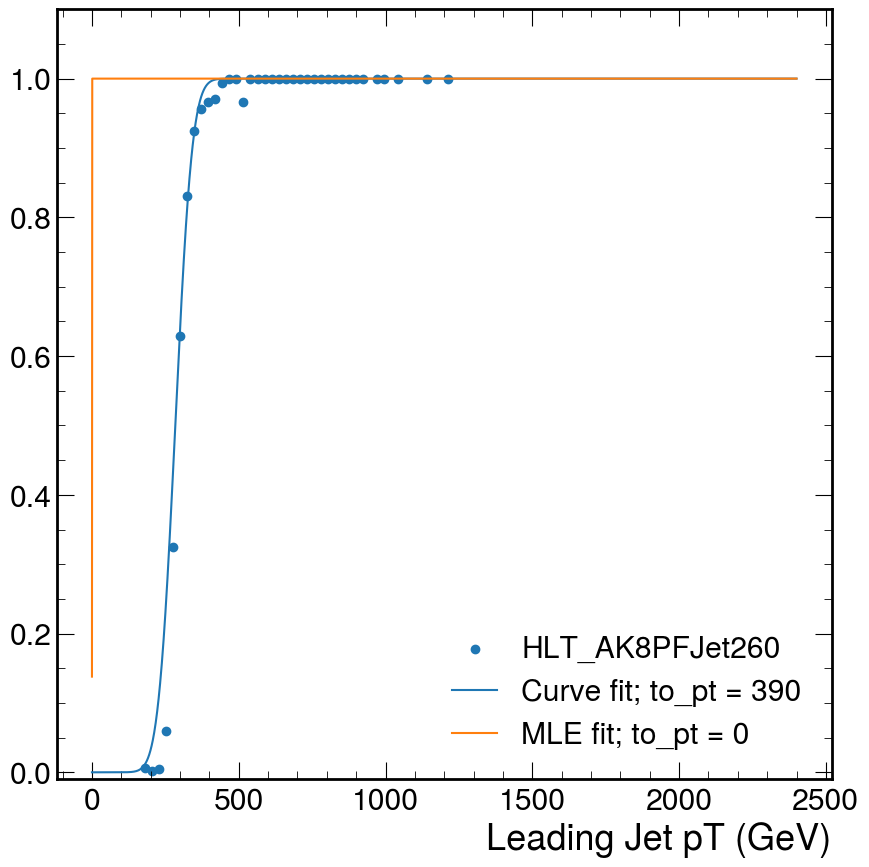

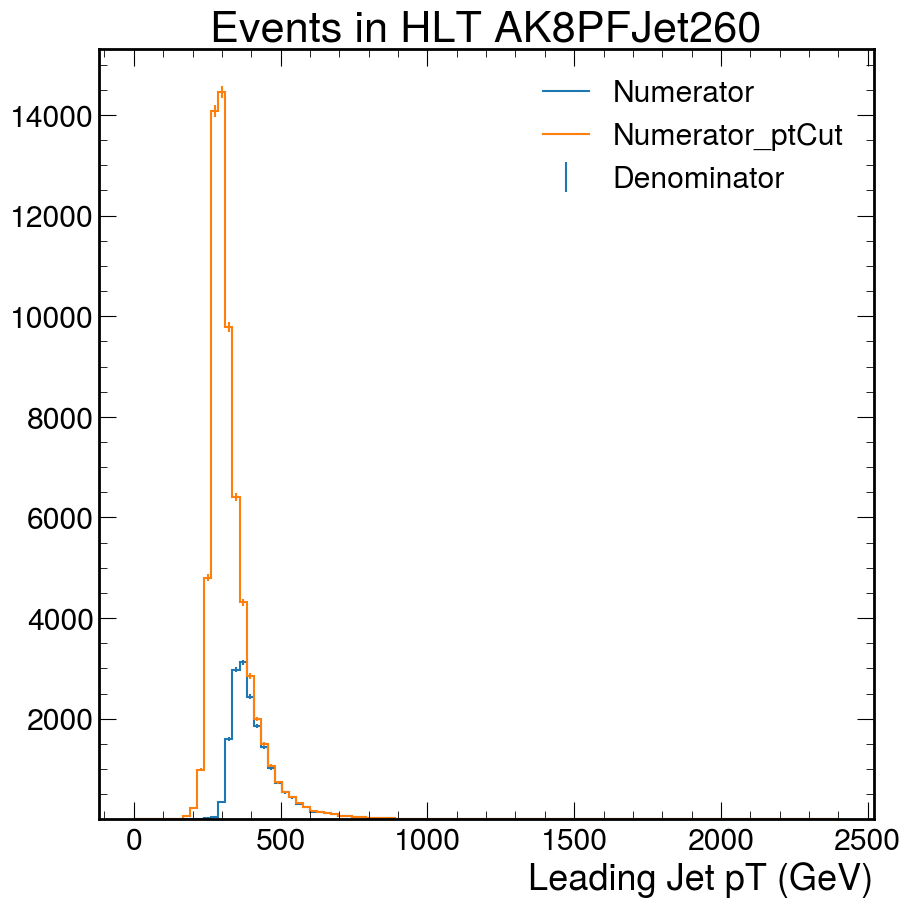

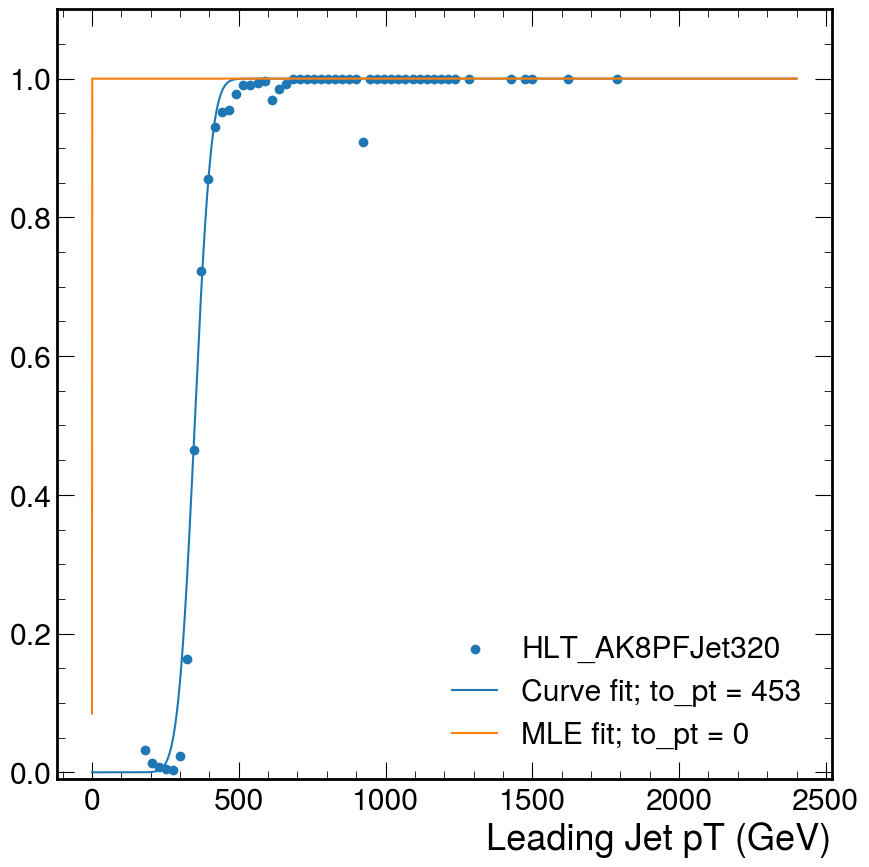

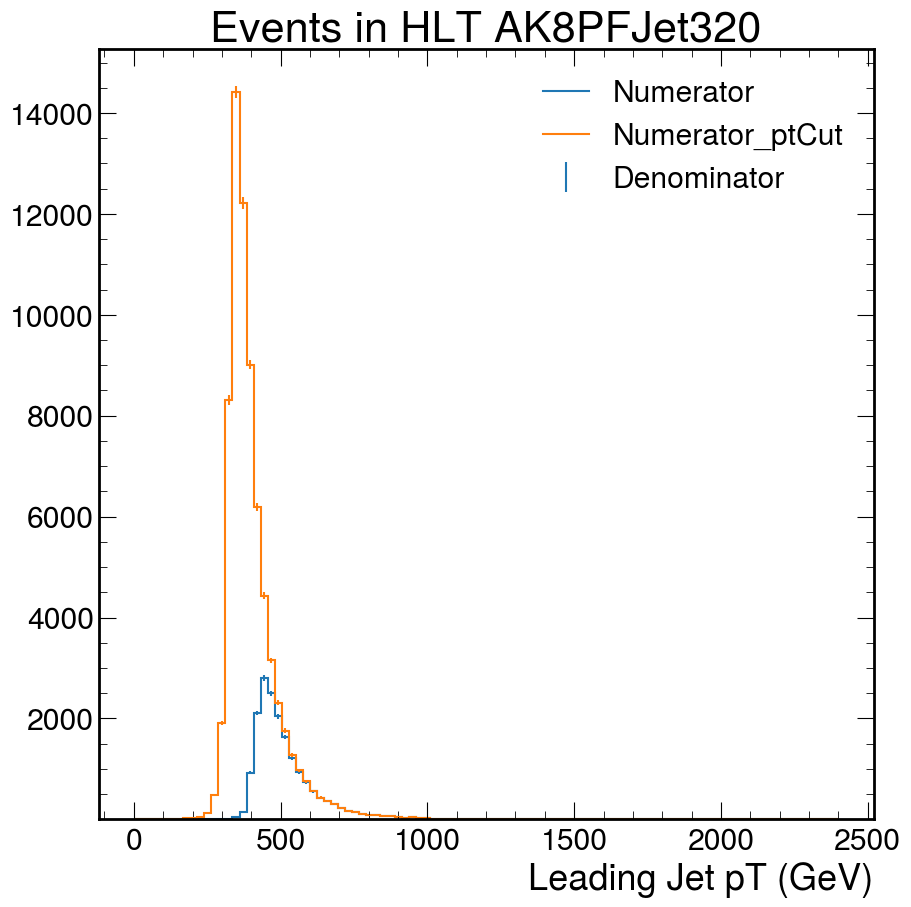

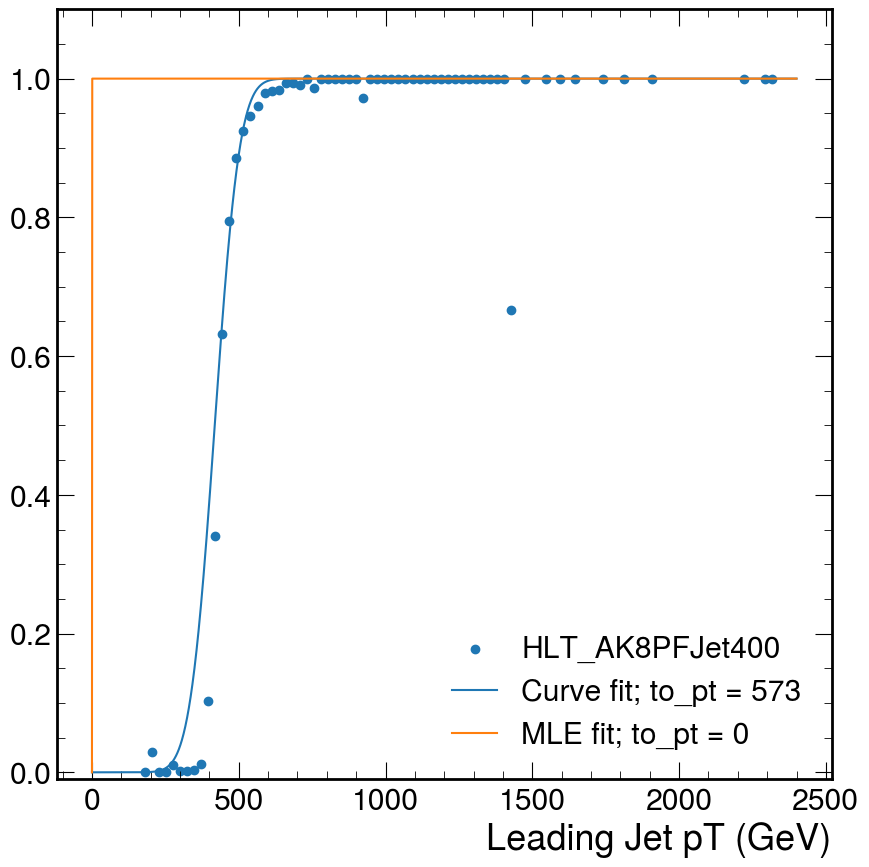

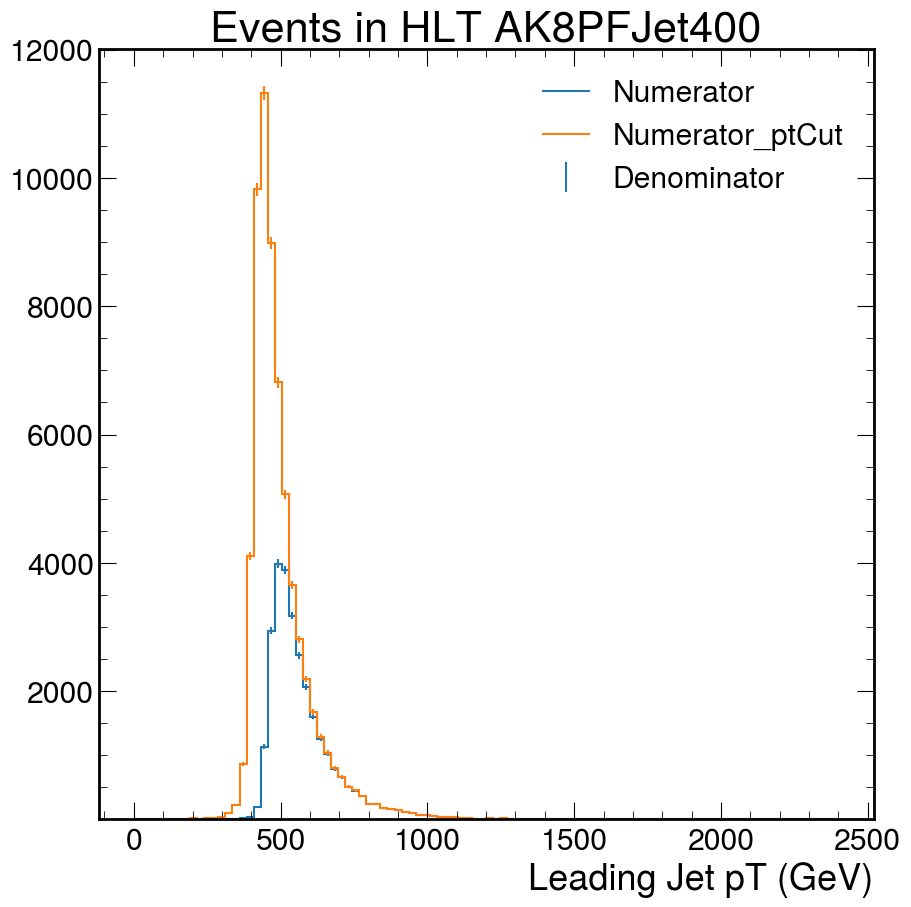

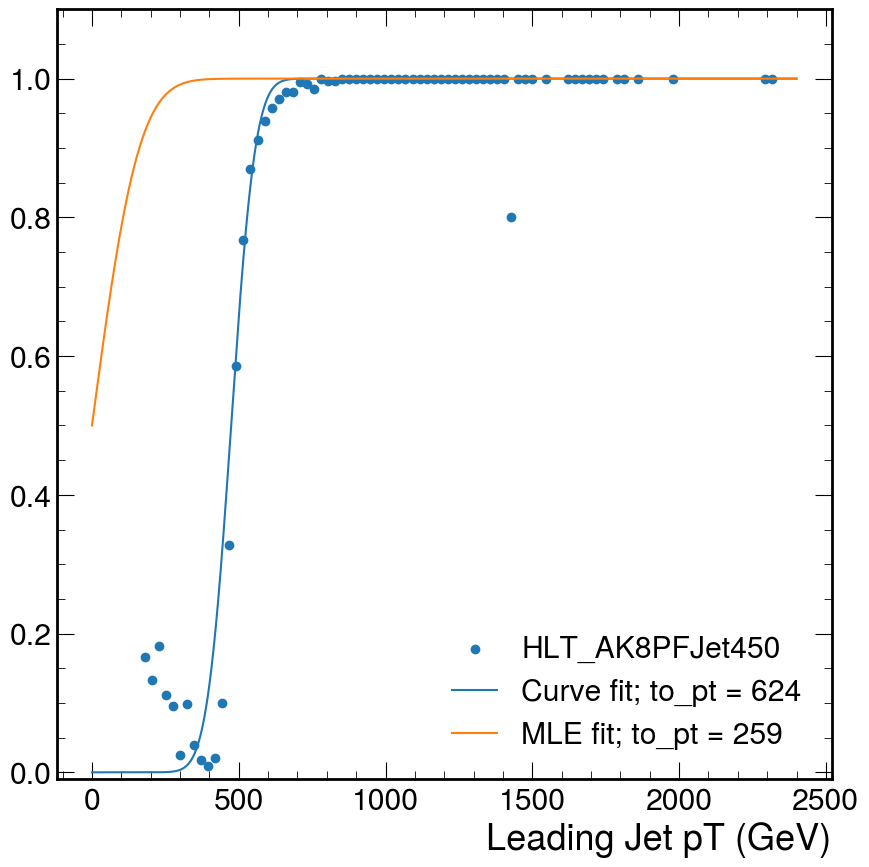

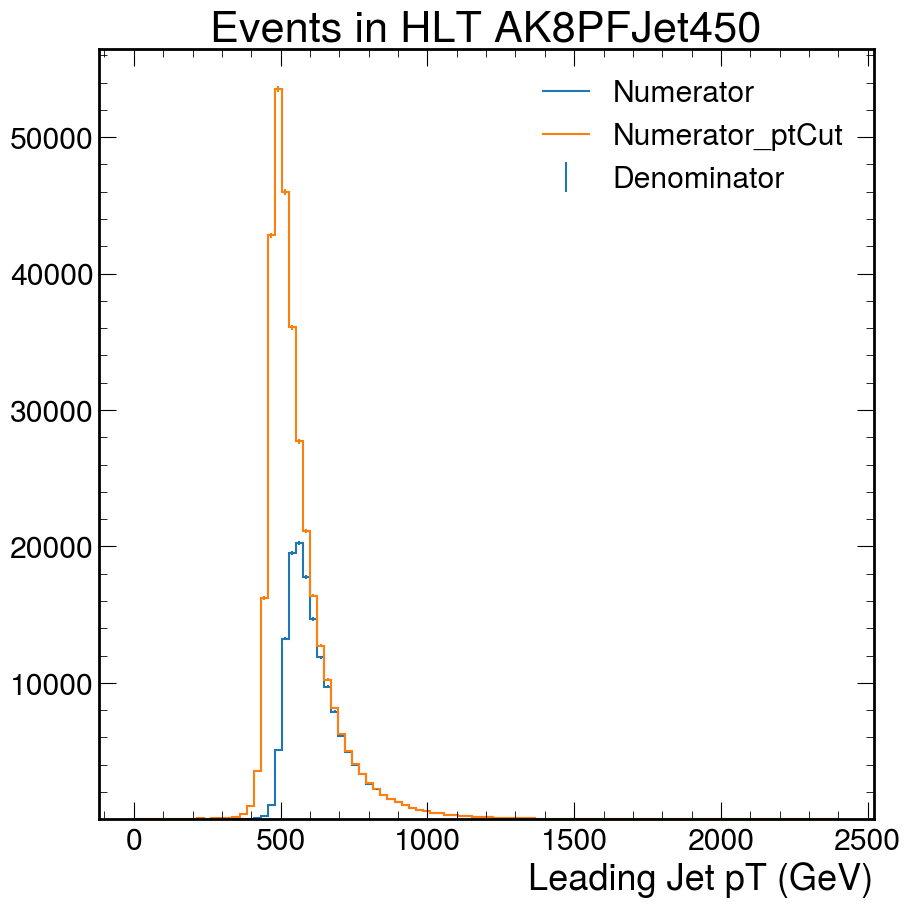

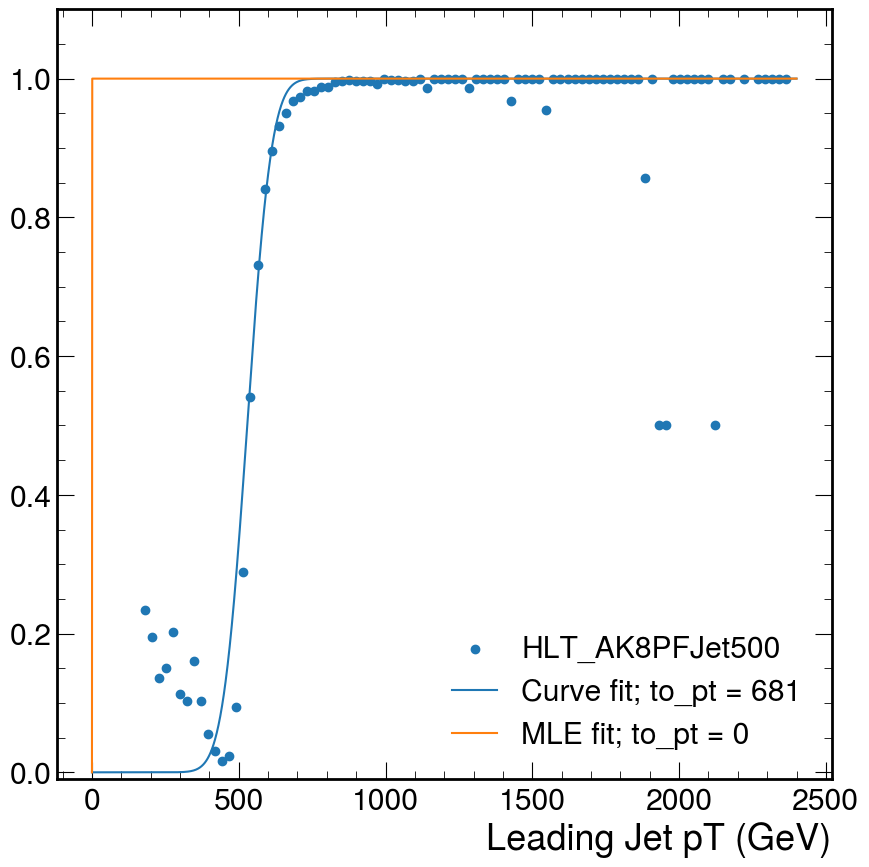

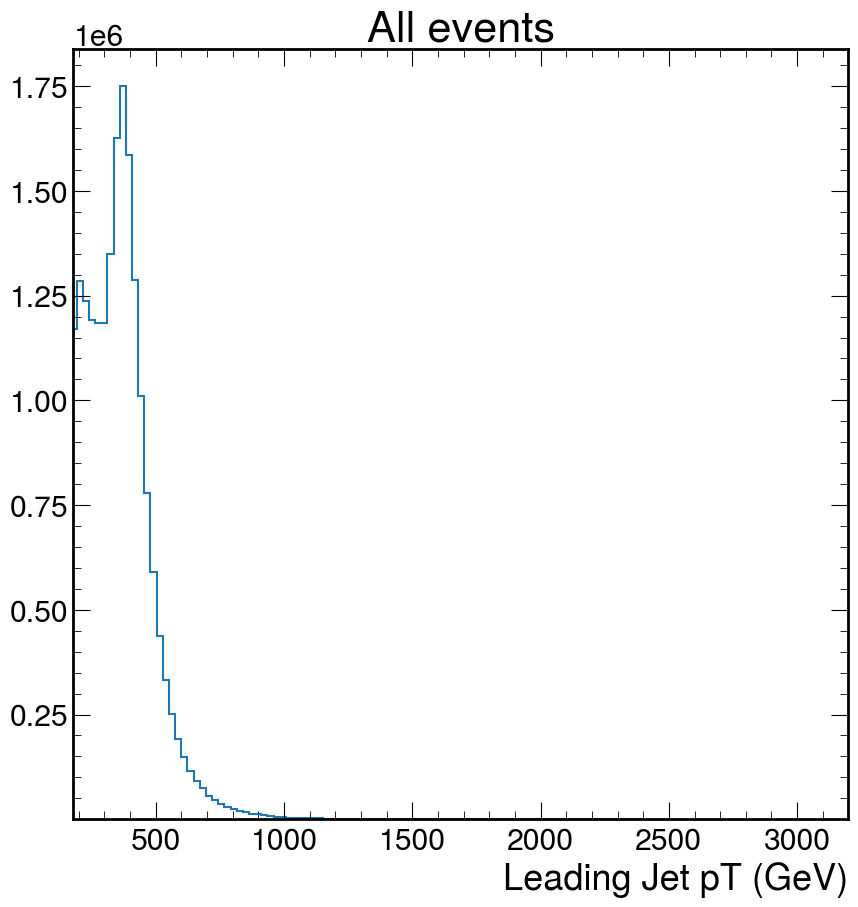

In [93]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_JetHT_2016_AK8PFJet_test_NewHist.coffea')
turnOnPts = plot_turnOn(result, HLT)
print(turnOnPts)

In [94]:
JetHT2016_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 123.74869215024762, 
                 'AK8PFJet80': 186.56007840935342, 
                 'AK8PFJet140': 282.00447348652773, 
                 'AK8PFJet200': 314.92956425770416, 
                 'AK8PFJet260': 400.2994345896792, 
                 'AK8PFJet320': 454.7965847657287, 
                 'AK8PFJet400': 569.3376812308528, 
                 'AK8PFJet450': 625.8112613298829, 
                 'AK8PFJet500': 679.4291743756459}

turnOnPts_2016_JetHT = {'AK8PFJet40':0.,
                        'AK8PFJet60': 128., 
                        'AK8PFJet80': 196., 
                        'AK8PFJet140': 262.,
                        'AK8PFJet200': 296., 
                        'AK8PFJet260': 364., 
                        'AK8PFJet320': 433.,
                        'AK8PFJet400': 524.,
                        'AK8PFJet450': 583.,
                        'AK8PFJet500': 642.}

turnOnPts_2017_JetHT = {'AK8PFJet40':0.,
                        'AK8PFJet60': 89., 
                        'AK8PFJet80': 160.,
                        'AK8PFJet140': 254.,
                        'AK8PFJet200': 309.,
                        'AK8PFJet260': 381.,
                        'AK8PFJet320': 454.,
                        'AK8PFJet400': 546., 
                        'AK8PFJet450': 608.,
                        'AK8PFJet500': 669.,
                        'AK8PFJet550': 731.}
turnOnPts_2018_JetHT = {'AK8PFJet15': 0.,
                        'AK8PFJet25': 0.,
                        'AK8PFJet40': 0.,
                        'AK8PFJet60': 0., 
                        'AK8PFJet80': 164., 
                        'AK8PFJet140': 252.,
                        'AK8PFJet200': 305.,
                        'AK8PFJet260': 379.,
                        'AK8PFJet320': 451.,
                        'AK8PFJet400': 544.,
                        'AK8PFJet450': 609.,
                        'AK8PFJet500': 668.,
                        'AK8PFJet550': 727.}

turnOnPts_2016_QCDSim = {'AK8PFJet40':0.,
                         'AK8PFJet60': 0.,
                         'AK8PFJet80': 103.7431245681197,
                         'AK8PFJet140': 250.23583948077737,
                         'AK8PFJet200': 301.2418029415817,
                         'AK8PFJet260': 357.96787539254467,
                         'AK8PFJet320': 435.2061611936324,
                         'AK8PFJet400': 516.5390073904625,
                         'AK8PFJet450': 562.8044746691382,
                         'AK8PFJet500': 629.5738066119139}

turnOnPts_2017_QCDSim = {'AK8PFJet60': 0.,
                         'AK8PFJet80': 106.04213984155606,
                         'AK8PFJet140': 245.63662455880666,
                         'AK8PFJet200': 305.7948712092066,
                         'AK8PFJet260': 361.2655624387622,
                         'AK8PFJet320': 447.21717573414594,
                         'AK8PFJet400': 530.4549735674909,
                         'AK8PFJet450': 587.3825806338202,
                         'AK8PFJet500': 654.0716446127442,
                         'AK8PFJet550': 705.9374327651158 }

turnOnPts_2018_QCDSim = {'AK8PFJet15': 0.,
                        'AK8PFJet25': 0.,
                        'AK8PFJet40': 0.,
                        'AK8PFJet60': 0., 
                        'AK8PFJet80': 0., 
                        'AK8PFJet140': 0.,
                        'AK8PFJet200': 0.,
                        'AK8PFJet260': 0.,
                        'AK8PFJet320': 0.,
                        'AK8PFJet400': 0.,
                        'AK8PFJet450': 0.,
                        'AK8PFJet500': 0.,
                        'AK8PFJet550': 0.}


In [97]:
in_year = 2016
data_bool = False
processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = list(JetHT2016_new.values()), data = data_bool)
dataname = "JetHT" if processor.data == True else "QCDsim"
filename = "datasets_UL_NANOAOD.json" if processor.data == True else "fileset_QCD.json"
result = runCoffeaJob(processor, jsonFile = filename, casa = True, dask = False, testing = True, year = processor.year, data = processor.data)
util.save(result, 'coffeaOutput/applyPrescales_{}_{}_{}_test_NewHist.coffea'.format(datastring, processor.year, processor.trigger))

UL16
Running locally


Output()

Index i:  9  for path:  AK8PFJet500
last index


concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 1640, in _work_function
    out = processor_instance.process(events)
  File "/home/cms-jovyan/GluonJetMass/triggerProcessor.py", line 158, in process
    pt_cut = (pt0 >= turnOnPt[i]) & events.HLT[path]
IndexError: list index out of range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/concurrent/futures/process.py", line 239, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 221, in __call__
    out = self.function(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 1353, in automatic_retries
    raise e
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor

Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  for path:  AK8PFJet500
last index
Index i:  9  

Exception: Failed processing file: WorkItem(dataset='/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/RunIISummer20UL16NanoAODv9-106X_mcRun2_asymptotic_v17-v1/NANOAODSIM', filename='root://xcache//store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/280000/D5331807-4243-5743-8BFE-BE3B4B3E4E2A.root', treename='Events', entrystart=0, entrystop=26000, fileuuid=b'79f\n\xea\xd8\x11\xeb\x8c\x9fg\xa1\xa9\x83\xbe\xef', usermeta={})

In [99]:
#TO DO: if statement to add prefix "HLT_" if using uproot --> 
###now switch to just coffea
#### THESE ARE NOT FINAL VALUES - NEED TO MAKE TURNON PLOTS
year = 2018
trigger = 'AK8PFJet'

if year == 2016:
    # HLT_paths = ['AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
    trigThresh = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500]
    pt_bins = [0.0, 20., 40., 60., 80., 100., 110., 128.0, 150., 170., 180., 196.0, 220., 240., 250., 262.0, 280., 296.0, 320., 340., 350.,364.0, 380., 400., 420.,433.0, 450.,470.,490., 510., 524.0, 550., 570., 583.0,600.,620.,630., 642.0,800., 1000.,1200., 1600., 2000.,2400.,]
    HLT_paths = [trigger + str(i) for i in trigThresh]
    turnOnPts = {'AK8PFJet40':0.,
                        'AK8PFJet60': 128., 
                        'AK8PFJet80': 196., 
                        'AK8PFJet140': 262.,
                        'AK8PFJet200': 296., 
                        'AK8PFJet260': 364., 
                        'AK8PFJet320': 433.,
                        'AK8PFJet400': 524.,
                        'AK8PFJet450': 583.,
                        'AK8PFJet500': 642.}
    prescales = {
    'AK8PFJet40'  : 136006.59,
    'AK8PFJet60'  : 50007.75,
    'AK8PFJet80'  : 13163.18,
    'AK8PFJet140' : 1501.12,
    'AK8PFJet200' : 349.82,
    'AK8PFJet260' : 61.17,
    'AK8PFJet320' : 20.49,
    'AK8PFJet400' : 6.99,
    'AK8PFJet450' : 1.00,
    'AK8PFJet500' : 1.00
            }
    tot_lumi = 36.31
    file = "root://xcache//store/data/Run2016H/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/0290F73B-A51C-A441-AEC1-8429F9CC8AA8.root"
elif year == 2017:
    # HLT_paths = ['AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']
    trigThresh = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500, 550]
    pt_bins = list(turnOnPts_2017_JetHT.values())
    HLT_paths = [trigger + str(i) for i in trigThresh]
    prescales = {'AK8PFJet40'  : 86061.17, 
                 'AK8PFJet60'  : 36420.75,    
                 'AK8PFJet80'  : 9621.74,    
                 'AK8PFJet140' : 1040.40,  
                 'AK8PFJet200' : 189.54,      
                 'AK8PFJet260' : 74.73,     
                 'AK8PFJet320' : 29.49,      
                 'AK8PFJet400' : 9.85,       
                 'AK8PFJet450' : 3.97,       
                 'AK8PFJet500' : 1.00,       
                 'AK8PFJet550' : 1.00,
    }
    turnOnPts = {'AK8PFJet40':0.,
                 'AK8PFJet60': 89., 
                 'AK8PFJet80': 160.,
                 'AK8PFJet140': 254.,
                 'AK8PFJet200': 309.,
                 'AK8PFJet260': 381.,
                 'AK8PFJet320': 454.,
                 'AK8PFJet400': 546., 
                 'AK8PFJet450': 608.,
                 'AK8PFJet500': 669.,
                 'AK8PFJet550': 731.}
    tot_lumi = 41.48
    file = 'root://xcache//store/data/Run2017D/JetHT/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/120000/018D975F-EA22-8F4B-84AC-796AF259675A.root'
elif year == 2018:
    # HLT_paths = ['AK8PFJet15', 'AK8PFJet25', 'AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']
    trigThresh = [15, 25, 40, 60, 80, 140, 200, 260, 320, 400, 450, 500, 550]
    pt_bins = list(turnOnPts_2018_JetHT.values())
    HLT_paths = [trigger + str(i) for i in trigThresh]
    prescales = {'AK8PFJet15'  : 318346231.66,
                 'AK8PFJet25'  : 318346231.66,
                 'AK8PFJet40'  : 248642.75,
                 'AK8PFJet60'  : 74330.16,  
                 'AK8PFJet80'  : 11616.52,   
                 'AK8PFJet140' : 1231.88, 
                 'AK8PFJet200' : 286.14,    
                 'AK8PFJet260' : 125.78,   
                 'AK8PFJet320' : 32.66,   
                 'AK8PFJet400' : 15.83,      
                 'AK8PFJet450' : 7.96,      
                 'AK8PFJet500' : 1.00,  
                 'AK8PFJet550' : 1.00,   
    }
    tot_lumi = 59.83
    turnOnPts = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 164., 
                 'AK8PFJet140': 252.,
                 'AK8PFJet200': 305.,
                 'AK8PFJet260': 379.,
                 'AK8PFJet320': 451.,
                 'AK8PFJet400': 544.,
                 'AK8PFJet450': 609.,
                 'AK8PFJet500': 668.,
                 'AK8PFJet550': 727.}
    file = 'root://xcache//store/data/Run2018A/JetHT/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/100000/00AA9A90-57AA-D147-B4FA-54D6D8DA0D4A.root'
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
print(HLT_paths)

['AK8PFJet15', 'AK8PFJet25', 'AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']


In [100]:
# import triggerProcessor
# from triggerProcessor import applyPrescales
# prescaleResult = runCoffeaJob(applyPrescales(), jsonFile = "fileset_QCD.json", casa = True, dask = True, testing = True, year = 2018)

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt


######### NEED TO UPDATE TO NEW HIST


events = events[ak.num(events.FatJet) >= 1]
print(len(events))
dataset_cat = hist.Cat("dataset", "Dataset")         
HLT_cat = hist.Cat("HLT_cat", "")
# pt_bin = hist.Bin("pt", "Jet pT (GeV)", pt_bins)
pt_bin = hist.Bin("pt", "Jet pT (GeV)", 500, 0, 2400)
hist_pt = hist.Hist("Events", dataset_cat, HLT_cat, pt_bin)
hist_pt_byHLTpath = hist.Hist("Events", dataset_cat, HLT_cat, pt_bin)

for i in np.arange(len(HLT_paths))[::-1]:
    path = HLT_paths[i]
    if path in events.HLT.fields:
        print("Index i: ", i, " for path: ", path)
        pt0 = events.FatJet[:,0].pt
        hist_pt.fill(dataset = "datastring", HLT_cat = path, pt = pt0[events.HLT[path]])
        if i == (len(HLT_paths) - 1):
            print('last index')
            pt_cut = (pt0 >= turnOnPts[HLT_paths[i]]) & events.HLT[path]
            hist_pt_byHLTpath.fill(dataset = "datastring", HLT_cat = path, pt = pt0[pt_cut])
        else:
            pt_cut = (pt0 >= turnOnPts[HLT_paths[i]]) & (pt0 < turnOnPts[HLT_paths[i+1]]) & events.HLT[path]
            hist_pt_byHLTpath.fill(dataset = "datastring", HLT_cat = path, pt = pt0[pt_cut])

HLT_masks = {}

def plotPrescales(result, year):
    hist_pt = result['hist_pt']
    hist_pt_byHLTpath = result['hist_pt_byHLTpath']
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams["figure.figsize"] = (30,20)
    fig, axs = plt.subplots(2, 2)      
        
    hist.plot1d(hist_pt.sum('dataset'), ax = axs[0,0], overlay='HLT_cat')
    axs[0,0].set_yscale('log')
    axs[0,0].set_ylim([0.0, 1.0e9])
    axs[0,0].set_title('Events sorted by HLT')

    hist_pt.scale(prescales, axis = 'HLT_cat')

    hist.plot1d(hist_pt.sum('dataset'), ax = axs[0,1], overlay='HLT_cat')
    axs[0,1].set_yscale('log')
    axs[0,1].set_ylim([0.0, 1.0e10])
    axs[0,1].set_title('Events sorted by HLT w/ prescale applied')

    hist.plot1d(hist_pt_byHLTpath.sum('dataset'), ax = axs[1,0], overlay='HLT_cat')
    axs[1,0].set_yscale('log')
    axs[1,0].set_ylim([0.0, 1.0e9])
    axs[1,0].set_title('Doubles removed')
    
    hist_pt_byHLTpath.scale(prescales, axis = 'HLT_cat')

    hist.plot1d(hist_pt_byHLTpath.sum('dataset'), ax = axs[1,1], overlay='HLT_cat')
    axs[1,1].set_yscale('log')
    axs[1,1].set_ylim([1.0e-1, 1.0e10])
    axs[1,1].set_title('Doubles removed w/ prescale applied')

    fig.suptitle('Apply Prescales ' + str(year), fontsize="large")

    plt.rc('legend',fontsize='small')
    dataset = 'JetHT' + str(year)
    os_path = 'plots/triggerStudies'+ dataset + '/'
    checkdir(os_path)
    plt.savefig(os_path + 'applyPrescales' + str(year) + ".png")


1081091


AttributeError: module hist has no attribute Cat

In [102]:
result = util.load('coffeaOutput/applyPrescales_JetHT_2016_AK8PFJet_test_NewHist.coffea')
print(result['hist_pt'].sum('HLT_cat').sum('pt').values().keys())
plotPrescales(result, 2016)

TypeError: sum(): incompatible function arguments. The following argument types are supported:
    1. (self: boost_histogram._core.hist.any_weight, flow: bool = False) -> accumulators::weighted_sum<double>

Invoked with: histogram(
  category("JetHT", metadata={'name': 'dataset', 'label': 'Dataset'}, options=growth)
  category("AK8PFJet500", "AK8PFJet450", "AK8PFJet400", "AK8PFJet320", "AK8PFJet260", "AK8PFJet200", "AK8PFJet140", "AK8PFJet80", "AK8PFJet60", "AK8PFJet40", metadata={'name': 'HLT_cat', 'label': ''}, options=growth)
  regular(100, 0, 2400, metadata={'name': 'pt', 'label': 'Jet pT (GeV)'}, options=underflow | overflow)
  (0 0  -1): 0   (0 1  -1): 0   (0 2  -1): 0   (0 3  -1): 0  
  (0 4  -1): 0   (0 5  -1): 0   (0 6  -1): 0   (0 7  -1): 0  
  (0 8  -1): 0   (0 9  -1): 0   (0 0   0): 0   (0 1   0): 0  
  (0 2   0): 0   (0 3   0): 0   (0 4   0): 0   (0 5   0): 0  
  (0 6   0): 0   (0 7   0): 0   (0 8   0): 0   (0 9   0): 0  
  (0 0   1): 0   (0 1   1): 0   (0 2   1): 0   (0 3   1): 0  
  (0 4   1): 0   (0 5   1): 0   (0 6   1): 0   (0 7   1): 0  
  (0 8   1): 0   (0 9   1): 0   (0 0   2): 0   (0 1   2): 0  
  (0 2   2): 0   (0 3   2): 0   (0 4   2): 0   (0 5   2): 0  
  (0 6   2): 0   (0 7   2): 0   (0 8   2): 0   (0 9   2): 0  
  (0 0   3): 0   (0 1   3): 0   (0 2   3): 0   (0 3   3): 0  
  (0 4   3): 0   (0 5   3): 0   (0 6   3): 0   (0 7   3): 0  
  (0 8   3): 0   (0 9   3): 0   (0 0   4): 0   (0 1   4): 0  
  (0 2   4): 0   (0 3   4): 0   (0 4   4): 0   (0 5   4): 0  
  (0 6   4): 0   (0 7   4): 0   (0 8   4): 0   (0 9   4): 0  
  (0 0   5): 0   (0 1   5): 0   (0 2   5): 0   (0 3   5): 0  
  (0 4   5): 0   (0 5   5): 0   (0 6   5): 0   (0 7   5): 0  
  (0 8   5): 0   (0 9   5): 0   (0 0   6): 0   (0 1   6): 0  
  (0 2   6): 0   (0 3   6): 0   (0 4   6): 0   (0 5   6): 0  
  (0 6   6): 0   (0 7   6): 0   (0 8   6): 0   (0 9   6): 0  
  (0 0   7): 0   (0 1   7): 0   (0 2   7): 0   (0 3   7): 0  
  (0 4   7): 0   (0 5   7): 0   (0 6   7): 0   (0 7   7): 0  
  (0 8   7): 0   (0 9   7): 0   (0 0   8): 0   (0 1   8): 0  
  (0 2   8): 0   (0 3   8): 0   (0 4   8): 0   (0 5   8): 0  
  (0 6   8): 0   (0 7   8): 0   (0 8   8): 0   (0 9   8): 0  
  (0 0   9): 0   (0 1   9): 0   (0 2   9): 0   (0 3   9): 0  
  (0 4   9): 0   (0 5   9): 0   (0 6   9): 0   (0 7   9): 0  
  (0 8   9): 0   (0 9   9): 0   (0 0  10): 0   (0 1  10): 0  
  (0 2  10): 0   (0 3  10): 0   (0 4  10): 0   (0 5  10): 0  
  (0 6  10): 0   (0 7  10): 0   (0 8  10): 0   (0 9  10): 0  
  (0 0  11): 0   (0 1  11): 0   (0 2  11): 0   (0 3  11): 0  
  (0 4  11): 0   (0 5  11): 0   (0 6  11): 0   (0 7  11): 0  
  (0 8  11): 0   (0 9  11): 0   (0 0  12): 0   (0 1  12): 0  
  (0 2  12): 0   (0 3  12): 0   (0 4  12): 0   (0 5  12): 0  
  (0 6  12): 0   (0 7  12): 0   (0 8  12): 0   (0 9  12): 0  
  (0 0  13): 0   (0 1  13): 0   (0 2  13): 0   (0 3  13): 0  
  (0 4  13): 0   (0 5  13): 0   (0 6  13): 0   (0 7  13): 0  
  (0 8  13): 0   (0 9  13): 0   (0 0  14): 0   (0 1  14): 0  
  (0 2  14): 0   (0 3  14): 0   (0 4  14): 0   (0 5  14): 0  
  (0 6  14): 0   (0 7  14): 0   (0 8  14): 0   (0 9  14): 0  
  (0 0  15): 0   (0 1  15): 0   (0 2  15): 0   (0 3  15): 0  
  (0 4  15): 0   (0 5  15): 0   (0 6  15): 0   (0 7  15): 0  
  (0 8  15): 0   (0 9  15): 0   (0 0  16): 0   (0 1  16): 0  
  (0 2  16): 0   (0 3  16): 0   (0 4  16): 0   (0 5  16): 0  
  (0 6  16): 0   (0 7  16): 0   (0 8  16): 0   (0 9  16): 0  
  (0 0  17): 0   (0 1  17): 0   (0 2  17): 0   (0 3  17): 0  
  (0 4  17): 0   (0 5  17): 0   (0 6  17): 0   (0 7  17): 0  
  (0 8  17): 0   (0 9  17): 0   (0 0  18): 0   (0 1  18): 0  
  (0 2  18): 0   (0 3  18): 0   (0 4  18): 0   (0 5  18): 0  
  (0 6  18): 0   (0 7  18): 0   (0 8  18): 0   (0 9  18): 0  
  (0 0  19): 0   (0 1  19): 0   (0 2  19): 0   (0 3  19): 0  
  (0 4  19): 0   (0 5  19): 0   (0 6  19): 0   (0 7  19): 0  
  (0 8  19): 0   (0 9  19): 0   (0 0  20): 0   (0 1  20): 0  
  (0 2  20): 0   (0 3  20): 0   (0 4  20): 0   (0 5  20): 0  
  (0 6  20): 0   (0 7  20): 0   (0 8  20): 0   (0 9  20): 0  
  (0 0  21): 0   (0 1  21): 0   (0 2  21): 0   (0 3  21): 0  
  (0 4  21): 0   (0 5  21): 0   (0 6  21): 0   (0 7  21): 0  
  (0 8  21): 0   (0 9  21): 0   (0 0  22): 0   (0 1  22): 0  
  (0 2  22): 0   (0 3  22): 0   (0 4  22): 0   (0 5  22): 0  
  (0 6  22): 0   (0 7  22): 0   (0 8  22): 0   (0 9  22): 0  
  (0 0  23): 0   (0 1  23): 0   (0 2  23): 0   (0 3  23): 0  
  (0 4  23): 0   (0 5  23): 0   (0 6  23): 0   (0 7  23): 0  
  (0 8  23): 0   (0 9  23): 0   (0 0  24): 0   (0 1  24): 0  
  (0 2  24): 0   (0 3  24): 0   (0 4  24): 0   (0 5  24): 0  
  (0 6  24): 0   (0 7  24): 0   (0 8  24): 0   (0 9  24): 0  
  (0 0  25): 0   (0 1  25): 0   (0 2  25): 0   (0 3  25): 0  
  (0 4  25): 0   (0 5  25): 0   (0 6  25): 0   (0 7  25): 0  
  (0 8  25): 0   (0 9  25): 0   (0 0  26): 0   (0 1  26): 0  
  (0 2  26): 0   (0 3  26): 0   (0 4  26): 0   (0 5  26): 0  
  (0 6  26): 0   (0 7  26): 0   (0 8  26): 0   (0 9  26): 0  
  (0 0  27): 0   (0 1  27): 0   (0 2  27): 0   (0 3  27): 0  
  (0 4  27): 0   (0 5  27): 0   (0 6  27): 0   (0 7  27): 0  
  (0 8  27): 0   (0 9  27): 0   (0 0  28): 0   (0 1  28): 0  
  (0 2  28): 0   (0 3  28): 0   (0 4  28): 0   (0 5  28): 0  
  (0 6  28): 0   (0 7  28): 0   (0 8  28): 0   (0 9  28): 0  
  (0 0  29): 0   (0 1  29): 0   (0 2  29): 0   (0 3  29): 0  
  (0 4  29): 0   (0 5  29): 0   (0 6  29): 0   (0 7  29): 0  
  (0 8  29): 0   (0 9  29): 0   (0 0  30): 0   (0 1  30): 0  
  (0 2  30): 0   (0 3  30): 0   (0 4  30): 0   (0 5  30): 0  
  (0 6  30): 0   (0 7  30): 0   (0 8  30): 0   (0 9  30): 0  
  (0 0  31): 0   (0 1  31): 0   (0 2  31): 0   (0 3  31): 0  
  (0 4  31): 0   (0 5  31): 0   (0 6  31): 0   (0 7  31): 0  
  (0 8  31): 0   (0 9  31): 0   (0 0  32): 0   (0 1  32): 0  
  (0 2  32): 0   (0 3  32): 0   (0 4  32): 0   (0 5  32): 0  
  (0 6  32): 0   (0 7  32): 0   (0 8  32): 0   (0 9  32): 0  
  (0 0  33): 0   (0 1  33): 0   (0 2  33): 0   (0 3  33): 0  
  (0 4  33): 0   (0 5  33): 0   (0 6  33): 0   (0 7  33): 0  
  (0 8  33): 0   (0 9  33): 0   (0 0  34): 0   (0 1  34): 0  
  (0 2  34): 0   (0 3  34): 0   (0 4  34): 0   (0 5  34): 0  
  (0 6  34): 0   (0 7  34): 0   (0 8  34): 0   (0 9  34): 0  
  (0 0  35): 1   (0 1  35): 1   (0 2  35): 1   (0 3  35): 1  
  (0 4  35): 1   (0 5  35): 1   (0 6  35): 1   (0 7  35): 1  
  (0 8  35): 1   (0 9  35): 1   (0 0  36): 0   (0 1  36): 0  
  (0 2  36): 0   (0 3  36): 0   (0 4  36): 0   (0 5  36): 0  
  (0 6  36): 0   (0 7  36): 0   (0 8  36): 0   (0 9  36): 0  
  (0 0  37): 0   (0 1  37): 0   (0 2  37): 0   (0 3  37): 0  
  (0 4  37): 0   (0 5  37): 0   (0 6  37): 0   (0 7  37): 0  
  (0 8  37): 0   (0 9  37): 0   (0 0  38): 0   (0 1  38): 0  
  (0 2  38): 0   (0 3  38): 0   (0 4  38): 0   (0 5  38): 0  
  (0 6  38): 0   (0 7  38): 0   (0 8  38): 0   (0 9  38): 0  
  (0 0  39): 1   (0 1  39): 1   (0 2  39): 1   (0 3  39): 1  
  (0 4  39): 1   (0 5  39): 1   (0 6  39): 1   (0 7  39): 1  
  (0 8  39): 1   (0 9  39): 1   (0 0  40): 0   (0 1  40): 0  
  (0 2  40): 0   (0 3  40): 0   (0 4  40): 0   (0 5  40): 0  
  (0 6  40): 0   (0 7  40): 0   (0 8  40): 0   (0 9  40): 0  
  (0 0  41): 0   (0 1  41): 0   (0 2  41): 0   (0 3  41): 0  
  (0 4  41): 0   (0 5  41): 0   (0 6  41): 0   (0 7  41): 0  
  (0 8  41): 0   (0 9  41): 0   (0 0  42): 1   (0 1  42): 1  
  (0 2  42): 1   (0 3  42): 1   (0 4  42): 1   (0 5  42): 1  
  (0 6  42): 1   (0 7  42): 1   (0 8  42): 1   (0 9  42): 1  
  (0 0  43): 1   (0 1  43): 1   (0 2  43): 1   (0 3  43): 1  
  (0 4  43): 1   (0 5  43): 1   (0 6  43): 1   (0 7  43): 1  
  (0 8  43): 1   (0 9  43): 1   (0 0  44): 1   (0 1  44): 1  
  (0 2  44): 1   (0 3  44): 1   (0 4  44): 1   (0 5  44): 1  
  (0 6  44): 1   (0 7  44): 1   (0 8  44): 1   (0 9  44): 1  
  (0 0  45): 0   (0 1  45): 0   (0 2  45): 0   (0 3  45): 0  
  (0 4  45): 0   (0 5  45): 0   (0 6  45): 0   (0 7  45): 0  
  (0 8  45): 0   (0 9  45): 0   (0 0  46): 1   (0 1  46): 1  
  (0 2  46): 1   (0 3  46): 1   (0 4  46): 1   (0 5  46): 1  
  (0 6  46): 1   (0 7  46): 1   (0 8  46): 1   (0 9  46): 1  
  (0 0  47): 0   (0 1  47): 0   (0 2  47): 0   (0 3  47): 0  
  (0 4  47): 0   (0 5  47): 0   (0 6  47): 0   (0 7  47): 0  
  (0 8  47): 0   (0 9  47): 0   (0 0  48): 3   (0 1  48): 3  
  (0 2  48): 3   (0 3  48): 3   (0 4  48): 3   (0 5  48): 3  
  (0 6  48): 3   (0 7  48): 3   (0 8  48): 3   (0 9  48): 3  
  (0 0  49): 3   (0 1  49): 3   (0 2  49): 3   (0 3  49): 3  
  (0 4  49): 3   (0 5  49): 3   (0 6  49): 3   (0 7  49): 3  
  (0 8  49): 3   (0 9  49): 3   (0 0  50): 3   (0 1  50): 3  
  (0 2  50): 3   (0 3  50): 3   (0 4  50): 3   (0 5  50): 3  
  (0 6  50): 3   (0 7  50): 3   (0 8  50): 3   (0 9  50): 3  
  (0 0  51): 3   (0 1  51): 3   (0 2  51): 3   (0 3  51): 3  
  (0 4  51): 3   (0 5  51): 3   (0 6  51): 3   (0 7  51): 3  
  (0 8  51): 3   (0 9  51): 3   (0 0  52): 2   (0 1  52): 2  
  (0 2  52): 2   (0 3  52): 2   (0 4  52): 2   (0 5  52): 2  
  (0 6  52): 2   (0 7  52): 2   (0 8  52): 2   (0 9  52): 2  
  (0 0  53): 1   (0 1  53): 1   (0 2  53): 1   (0 3  53): 1  
  (0 4  53): 1   (0 5  53): 1   (0 6  53): 1   (0 7  53): 1  
  (0 8  53): 1   (0 9  53): 1   (0 0  54): 2   (0 1  54): 2  
  (0 2  54): 2   (0 3  54): 2   (0 4  54): 2   (0 5  54): 2  
  (0 6  54): 2   (0 7  54): 2   (0 8  54): 2   (0 9  54): 2  
  (0 0  55): 2   (0 1  55): 2   (0 2  55): 2   (0 3  55): 2  
  (0 4  55): 2   (0 5  55): 2   (0 6  55): 2   (0 7  55): 2  
  (0 8  55): 2   (0 9  55): 2   (0 0  56): 0   (0 1  56): 0  
  (0 2  56): 0   (0 3  56): 0   (0 4  56): 0   (0 5  56): 0  
  (0 6  56): 0   (0 7  56): 0   (0 8  56): 0   (0 9  56): 0  
  (0 0  57): 2   (0 1  57): 2   (0 2  57): 2   (0 3  57): 2  
  (0 4  57): 2   (0 5  57): 2   (0 6  57): 2   (0 7  57): 2  
  (0 8  57): 2   (0 9  57): 2   (0 0  58): 4   (0 1  58): 4  
  (0 2  58): 4   (0 3  58): 4   (0 4  58): 4   (0 5  58): 4  
  (0 6  58): 4   (0 7  58): 4   (0 8  58): 4   (0 9  58): 4  
  (0 0  59): 3   (0 1  59): 3   (0 2  59): 3   (0 3  59): 3  
  (0 4  59): 3   (0 5  59): 3   (0 6  59): 3   (0 7  59): 3  
  (0 8  59): 3   (0 9  59): 3   (0 0  60): 7   (0 1  60): 7  
  (0 2  60): 7   (0 3  60): 7   (0 4  60): 7   (0 5  60): 7  
  (0 6  60): 7   (0 7  60): 7   (0 8  60): 7   (0 9  60): 7  
  (0 0  61): 4   (0 1  61): 4   (0 2  61): 4   (0 3  61): 4  
  (0 4  61): 4   (0 5  61): 4   (0 6  61): 4   (0 7  61): 4  
  (0 8  61): 4   (0 9  61): 4   (0 0  62): 4   (0 1  62): 4  
  (0 2  62): 4   (0 3  62): 4   (0 4  62): 4   (0 5  62): 4  
  (0 6  62): 4   (0 7  62): 4   (0 8  62): 4   (0 9  62): 4  
  (0 0  63): 9   (0 1  63): 9   (0 2  63): 9   (0 3  63): 9  
  (0 4  63): 9   (0 5  63): 9   (0 6  63): 9   (0 7  63): 9  
  (0 8  63): 9   (0 9  63): 9   (0 0  64): 5   (0 1  64): 5  
  (0 2  64): 5   (0 3  64): 5   (0 4  64): 5   (0 5  64): 5  
  (0 6  64): 5   (0 7  64): 5   (0 8  64): 5   (0 9  64): 5  
  (0 0  65): 14  (0 1  65): 14  (0 2  65): 14  (0 3  65): 14 
  (0 4  65): 14  (0 5  65): 14  (0 6  65): 14  (0 7  65): 14 
  (0 8  65): 14  (0 9  65): 14  (0 0  66): 17  (0 1  66): 17 
  (0 2  66): 17  (0 3  66): 17  (0 4  66): 17  (0 5  66): 17 
  (0 6  66): 17  (0 7  66): 17  (0 8  66): 17  (0 9  66): 17 
  (0 0  67): 11  (0 1  67): 11  (0 2  67): 11  (0 3  67): 11 
  (0 4  67): 11  (0 5  67): 11  (0 6  67): 11  (0 7  67): 11 
  (0 8  67): 11  (0 9  67): 11  (0 0  68): 24  (0 1  68): 24 
  (0 2  68): 24  (0 3  68): 24  (0 4  68): 24  (0 5  68): 24 
  (0 6  68): 24  (0 7  68): 24  (0 8  68): 24  (0 9  68): 24 
  (0 0  69): 23  (0 1  69): 23  (0 2  69): 23  (0 3  69): 23 
  (0 4  69): 23  (0 5  69): 23  (0 6  69): 23  (0 7  69): 23 
  (0 8  69): 23  (0 9  69): 23  (0 0  70): 33  (0 1  70): 33 
  (0 2  70): 33  (0 3  70): 33  (0 4  70): 33  (0 5  70): 33 
  (0 6  70): 33  (0 7  70): 33  (0 8  70): 33  (0 9  70): 33 
  (0 0  71): 37  (0 1  71): 37  (0 2  71): 37  (0 3  71): 37 
  (0 4  71): 37  (0 5  71): 37  (0 6  71): 37  (0 7  71): 37 
  (0 8  71): 37  (0 9  71): 37  (0 0  72): 71  (0 1  72): 71 
  (0 2  72): 71  (0 3  72): 71  (0 4  72): 71  (0 5  72): 71 
  (0 6  72): 71  (0 7  72): 71  (0 8  72): 71  (0 9  72): 71 
  (0 0  73): 101 (0 1  73): 101 (0 2  73): 101 (0 3  73): 101
  (0 4  73): 101 (0 5  73): 101 (0 6  73): 101 (0 7  73): 101
  (0 8  73): 101 (0 9  73): 101 (0 0  74): 137 (0 1  74): 137
  (0 2  74): 137 (0 3  74): 137 (0 4  74): 137 (0 5  74): 137
  (0 6  74): 137 (0 7  74): 137 (0 8  74): 137 (0 9  74): 137
  (0 0  75): 226 (0 1  75): 226 (0 2  75): 226 (0 3  75): 226
  (0 4  75): 226 (0 5  75): 226 (0 6  75): 226 (0 7  75): 226
  (0 8  75): 226 (0 9  75): 226 (0 0  76): 266 (0 1  76): 266
  (0 2  76): 266 (0 3  76): 266 (0 4  76): 266 (0 5  76): 266
  (0 6  76): 266 (0 7  76): 266 (0 8  76): 266 (0 9  76): 266
  (0 0  77): 341 (0 1  77): 341 (0 2  77): 341 (0 3  77): 341
  (0 4  77): 341 (0 5  77): 341 (0 6  77): 341 (0 7  77): 341
  (0 8  77): 341 (0 9  77): 341 (0 0  78): 420 (0 1  78): 420
  (0 2  78): 420 (0 3  78): 420 (0 4  78): 420 (0 5  78): 420
  (0 6  78): 420 (0 7  78): 420 (0 8  78): 420 (0 9  78): 420
  (0 0  79): 459 (0 1  79): 459 (0 2  79): 459 (0 3  79): 459
  (0 4  79): 459 (0 5  79): 459 (0 6  79): 459 (0 7  79): 459
  (0 8  79): 459 (0 9  79): 459 (0 0  80): 492 (0 1  80): 492
  (0 2  80): 492 (0 3  80): 492 (0 4  80): 492 (0 5  80): 492
  (0 6  80): 492 (0 7  80): 492 (0 8  80): 492 (0 9  80): 492
  (0 0  81): 526 (0 1  81): 526 (0 2  81): 526 (0 3  81): 526
  (0 4  81): 526 (0 5  81): 526 (0 6  81): 526 (0 7  81): 526
  (0 8  81): 526 (0 9  81): 526 (0 0  82): 531 (0 1  82): 531
  (0 2  82): 531 (0 3  82): 531 (0 4  82): 531 (0 5  82): 531
  (0 6  82): 531 (0 7  82): 531 (0 8  82): 531 (0 9  82): 531
  (0 0  83): 540 (0 1  83): 540 (0 2  83): 540 (0 3  83): 540
  (0 4  83): 540 (0 5  83): 540 (0 6  83): 540 (0 7  83): 540
  (0 8  83): 540 (0 9  83): 540 (0 0  84): 461 (0 1  84): 461
  (0 2  84): 461 (0 3  84): 461 (0 4  84): 461 (0 5  84): 461
  (0 6  84): 461 (0 7  84): 461 (0 8  84): 461 (0 9  84): 461
  (0 0  85): 428 (0 1  85): 428 (0 2  85): 428 (0 3  85): 428
  (0 4  85): 428 (0 5  85): 428 (0 6  85): 428 (0 7  85): 428
  (0 8  85): 428 (0 9  85): 428 (0 0  86): 426 (0 1  86): 426
  (0 2  86): 426 (0 3  86): 426 (0 4  86): 426 (0 5  86): 426
  (0 6  86): 426 (0 7  86): 426 (0 8  86): 426 (0 9  86): 426
  (0 0  87): 367 (0 1  87): 367 (0 2  87): 367 (0 3  87): 367
  (0 4  87): 367 (0 5  87): 367 (0 6  87): 367 (0 7  87): 367
  (0 8  87): 367 (0 9  87): 367 (0 0  88): 319 (0 1  88): 319
  (0 2  88): 319 (0 3  88): 319 (0 4  88): 319 (0 5  88): 319
  (0 6  88): 319 (0 7  88): 319 (0 8  88): 319 (0 9  88): 319
  (0 0  89): 314 (0 1  89): 314 (0 2  89): 314 (0 3  89): 314
  (0 4  89): 314 (0 5  89): 314 (0 6  89): 314 (0 7  89): 314
  (0 8  89): 314 (0 9  89): 314 (0 0  90): 309 (0 1  90): 309
  (0 2  90): 309 (0 3  90): 309 (0 4  90): 309 (0 5  90): 309
  (0 6  90): 309 (0 7  90): 309 (0 8  90): 309 (0 9  90): 309
  (0 0  91): 243 (0 1  91): 243 (0 2  91): 243 (0 3  91): 243
  (0 4  91): 243 (0 5  91): 243 (0 6  91): 243 (0 7  91): 243
  (0 8  91): 243 (0 9  91): 243 (0 0  92): 246 (0 1  92): 246
  (0 2  92): 246 (0 3  92): 246 (0 4  92): 246 (0 5  92): 246
  (0 6  92): 246 (0 7  92): 246 (0 8  92): 246 (0 9  92): 246
  (0 0  93): 219 (0 1  93): 219 (0 2  93): 219 (0 3  93): 219
  (0 4  93): 219 (0 5  93): 219 (0 6  93): 219 (0 7  93): 219
  (0 8  93): 219 (0 9  93): 219 (0 0  94): 182 (0 1  94): 182
  (0 2  94): 182 (0 3  94): 182 (0 4  94): 182 (0 5  94): 182
  (0 6  94): 182 (0 7  94): 182 (0 8  94): 182 (0 9  94): 182
  (0 0  95): 172 (0 1  95): 172 (0 2  95): 172 (0 3  95): 172
  (0 4  95): 172 (0 5  95): 172 (0 6  95): 172 (0 7  95): 172
  (0 8  95): 172 (0 9  95): 172 (0 0  96): 157 (0 1  96): 157
  (0 2  96): 157 (0 3  96): 157 (0 4  96): 157 (0 5  96): 157
  (0 6  96): 157 (0 7  96): 157 (0 8  96): 157 (0 9  96): 157
  (0 0  97): 134 (0 1  97): 134 (0 2  97): 134 (0 3  97): 134
  (0 4  97): 134 (0 5  97): 134 (0 6  97): 134 (0 7  97): 134
  (0 8  97): 134 (0 9  97): 134 (0 0  98): 105 (0 1  98): 105
  (0 2  98): 105 (0 3  98): 105 (0 4  98): 105 (0 5  98): 105
  (0 6  98): 105 (0 7  98): 105 (0 8  98): 105 (0 9  98): 105
  (0 0  99): 112 (0 1  99): 112 (0 2  99): 112 (0 3  99): 112
  (0 4  99): 112 (0 5  99): 112 (0 6  99): 112 (0 7  99): 112
  (0 8  99): 112 (0 9  99): 112 (0 0 100): 474 (0 1 100): 474
  (0 2 100): 474 (0 3 100): 474 (0 4 100): 474 (0 5 100): 474
  (0 6 100): 474 (0 7 100): 474 (0 8 100): 474 (0 9 100): 474
), 'HLT_cat'

In [103]:
result = util.load('coffeaOutput/applyPrescales_QCDsim_2016_AK8PFJet_test_NewHist.coffea')
print(result['hist_pt'].sum('HLT_cat').sum('pt').values().keys())
plotPrescales(result, 2017)

TypeError: sum(): incompatible function arguments. The following argument types are supported:
    1. (self: boost_histogram._core.hist.any_weight, flow: bool = False) -> accumulators::weighted_sum<double>

Invoked with: histogram(
  category("QCDsim", metadata={'name': 'dataset', 'label': 'Dataset'}, options=growth)
  category("AK8PFJet500", "AK8PFJet450", "AK8PFJet400", "AK8PFJet320", "AK8PFJet260", "AK8PFJet200", "AK8PFJet140", "AK8PFJet80", "AK8PFJet60", "AK8PFJet40", metadata={'name': 'HLT_cat', 'label': ''}, options=growth)
  regular(100, 0, 2400, metadata={'name': 'pt', 'label': 'Jet pT (GeV)'}, options=underflow | overflow)
  (0 0  -1): 0   (0 1  -1): 0   (0 2  -1): 0   (0 3  -1): 0  
  (0 4  -1): 0   (0 5  -1): 0   (0 6  -1): 0   (0 7  -1): 0  
  (0 8  -1): 0   (0 9  -1): 0   (0 0   0): 0   (0 1   0): 0  
  (0 2   0): 0   (0 3   0): 0   (0 4   0): 0   (0 5   0): 0  
  (0 6   0): 0   (0 7   0): 0   (0 8   0): 0   (0 9   0): 0  
  (0 0   1): 0   (0 1   1): 0   (0 2   1): 0   (0 3   1): 0  
  (0 4   1): 0   (0 5   1): 0   (0 6   1): 0   (0 7   1): 0  
  (0 8   1): 0   (0 9   1): 0   (0 0   2): 0   (0 1   2): 0  
  (0 2   2): 0   (0 3   2): 0   (0 4   2): 0   (0 5   2): 0  
  (0 6   2): 0   (0 7   2): 0   (0 8   2): 0   (0 9   2): 0  
  (0 0   3): 0   (0 1   3): 0   (0 2   3): 0   (0 3   3): 0  
  (0 4   3): 0   (0 5   3): 0   (0 6   3): 0   (0 7   3): 0  
  (0 8   3): 0   (0 9   3): 0   (0 0   4): 0   (0 1   4): 0  
  (0 2   4): 0   (0 3   4): 0   (0 4   4): 0   (0 5   4): 0  
  (0 6   4): 0   (0 7   4): 0   (0 8   4): 0   (0 9   4): 0  
  (0 0   5): 0   (0 1   5): 0   (0 2   5): 0   (0 3   5): 0  
  (0 4   5): 0   (0 5   5): 0   (0 6   5): 0   (0 7   5): 0  
  (0 8   5): 0   (0 9   5): 0   (0 0   6): 0   (0 1   6): 0  
  (0 2   6): 0   (0 3   6): 0   (0 4   6): 0   (0 5   6): 0  
  (0 6   6): 0   (0 7   6): 0   (0 8   6): 0   (0 9   6): 0  
  (0 0   7): 0   (0 1   7): 0   (0 2   7): 0   (0 3   7): 0  
  (0 4   7): 0   (0 5   7): 0   (0 6   7): 0   (0 7   7): 0  
  (0 8   7): 0   (0 9   7): 0   (0 0   8): 0   (0 1   8): 0  
  (0 2   8): 0   (0 3   8): 0   (0 4   8): 0   (0 5   8): 0  
  (0 6   8): 0   (0 7   8): 0   (0 8   8): 0   (0 9   8): 0  
  (0 0   9): 0   (0 1   9): 0   (0 2   9): 0   (0 3   9): 0  
  (0 4   9): 0   (0 5   9): 0   (0 6   9): 0   (0 7   9): 0  
  (0 8   9): 0   (0 9   9): 0   (0 0  10): 0   (0 1  10): 0  
  (0 2  10): 0   (0 3  10): 0   (0 4  10): 0   (0 5  10): 0  
  (0 6  10): 0   (0 7  10): 0   (0 8  10): 0   (0 9  10): 0  
  (0 0  11): 0   (0 1  11): 0   (0 2  11): 0   (0 3  11): 0  
  (0 4  11): 0   (0 5  11): 0   (0 6  11): 0   (0 7  11): 0  
  (0 8  11): 0   (0 9  11): 0   (0 0  12): 0   (0 1  12): 0  
  (0 2  12): 0   (0 3  12): 0   (0 4  12): 0   (0 5  12): 0  
  (0 6  12): 0   (0 7  12): 0   (0 8  12): 0   (0 9  12): 0  
  (0 0  13): 0   (0 1  13): 0   (0 2  13): 0   (0 3  13): 0  
  (0 4  13): 0   (0 5  13): 0   (0 6  13): 0   (0 7  13): 0  
  (0 8  13): 0   (0 9  13): 0   (0 0  14): 0   (0 1  14): 0  
  (0 2  14): 0   (0 3  14): 0   (0 4  14): 0   (0 5  14): 0  
  (0 6  14): 0   (0 7  14): 0   (0 8  14): 0   (0 9  14): 0  
  (0 0  15): 0   (0 1  15): 0   (0 2  15): 0   (0 3  15): 0  
  (0 4  15): 0   (0 5  15): 0   (0 6  15): 0   (0 7  15): 0  
  (0 8  15): 0   (0 9  15): 0   (0 0  16): 0   (0 1  16): 0  
  (0 2  16): 0   (0 3  16): 0   (0 4  16): 0   (0 5  16): 0  
  (0 6  16): 0   (0 7  16): 0   (0 8  16): 0   (0 9  16): 0  
  (0 0  17): 0   (0 1  17): 0   (0 2  17): 0   (0 3  17): 0  
  (0 4  17): 0   (0 5  17): 0   (0 6  17): 0   (0 7  17): 0  
  (0 8  17): 0   (0 9  17): 0   (0 0  18): 0   (0 1  18): 0  
  (0 2  18): 0   (0 3  18): 0   (0 4  18): 0   (0 5  18): 0  
  (0 6  18): 0   (0 7  18): 0   (0 8  18): 0   (0 9  18): 0  
  (0 0  19): 0   (0 1  19): 0   (0 2  19): 0   (0 3  19): 0  
  (0 4  19): 0   (0 5  19): 0   (0 6  19): 0   (0 7  19): 0  
  (0 8  19): 0   (0 9  19): 0   (0 0  20): 0   (0 1  20): 0  
  (0 2  20): 0   (0 3  20): 0   (0 4  20): 0   (0 5  20): 0  
  (0 6  20): 0   (0 7  20): 0   (0 8  20): 0   (0 9  20): 0  
  (0 0  21): 0   (0 1  21): 0   (0 2  21): 0   (0 3  21): 0  
  (0 4  21): 0   (0 5  21): 0   (0 6  21): 0   (0 7  21): 0  
  (0 8  21): 0   (0 9  21): 0   (0 0  22): 0   (0 1  22): 0  
  (0 2  22): 0   (0 3  22): 0   (0 4  22): 0   (0 5  22): 0  
  (0 6  22): 0   (0 7  22): 0   (0 8  22): 0   (0 9  22): 0  
  (0 0  23): 0   (0 1  23): 0   (0 2  23): 0   (0 3  23): 0  
  (0 4  23): 0   (0 5  23): 0   (0 6  23): 0   (0 7  23): 0  
  (0 8  23): 0   (0 9  23): 0   (0 0  24): 0   (0 1  24): 0  
  (0 2  24): 0   (0 3  24): 0   (0 4  24): 0   (0 5  24): 0  
  (0 6  24): 0   (0 7  24): 0   (0 8  24): 0   (0 9  24): 0  
  (0 0  25): 0   (0 1  25): 0   (0 2  25): 0   (0 3  25): 0  
  (0 4  25): 0   (0 5  25): 0   (0 6  25): 0   (0 7  25): 0  
  (0 8  25): 0   (0 9  25): 0   (0 0  26): 0   (0 1  26): 0  
  (0 2  26): 0   (0 3  26): 0   (0 4  26): 0   (0 5  26): 0  
  (0 6  26): 0   (0 7  26): 0   (0 8  26): 0   (0 9  26): 0  
  (0 0  27): 0   (0 1  27): 0   (0 2  27): 0   (0 3  27): 0  
  (0 4  27): 0   (0 5  27): 0   (0 6  27): 0   (0 7  27): 0  
  (0 8  27): 0   (0 9  27): 0   (0 0  28): 0   (0 1  28): 0  
  (0 2  28): 0   (0 3  28): 0   (0 4  28): 0   (0 5  28): 0  
  (0 6  28): 0   (0 7  28): 0   (0 8  28): 0   (0 9  28): 0  
  (0 0  29): 0   (0 1  29): 0   (0 2  29): 0   (0 3  29): 0  
  (0 4  29): 0   (0 5  29): 0   (0 6  29): 0   (0 7  29): 0  
  (0 8  29): 0   (0 9  29): 0   (0 0  30): 0   (0 1  30): 0  
  (0 2  30): 0   (0 3  30): 0   (0 4  30): 0   (0 5  30): 0  
  (0 6  30): 0   (0 7  30): 0   (0 8  30): 0   (0 9  30): 0  
  (0 0  31): 0   (0 1  31): 0   (0 2  31): 0   (0 3  31): 0  
  (0 4  31): 0   (0 5  31): 0   (0 6  31): 0   (0 7  31): 0  
  (0 8  31): 0   (0 9  31): 0   (0 0  32): 0   (0 1  32): 0  
  (0 2  32): 0   (0 3  32): 0   (0 4  32): 0   (0 5  32): 0  
  (0 6  32): 0   (0 7  32): 0   (0 8  32): 0   (0 9  32): 0  
  (0 0  33): 0   (0 1  33): 0   (0 2  33): 0   (0 3  33): 0  
  (0 4  33): 0   (0 5  33): 0   (0 6  33): 0   (0 7  33): 0  
  (0 8  33): 0   (0 9  33): 0   (0 0  34): 0   (0 1  34): 0  
  (0 2  34): 0   (0 3  34): 0   (0 4  34): 0   (0 5  34): 0  
  (0 6  34): 0   (0 7  34): 0   (0 8  34): 0   (0 9  34): 0  
  (0 0  35): 1   (0 1  35): 1   (0 2  35): 1   (0 3  35): 1  
  (0 4  35): 1   (0 5  35): 1   (0 6  35): 1   (0 7  35): 1  
  (0 8  35): 1   (0 9  35): 1   (0 0  36): 0   (0 1  36): 0  
  (0 2  36): 0   (0 3  36): 0   (0 4  36): 0   (0 5  36): 0  
  (0 6  36): 0   (0 7  36): 0   (0 8  36): 0   (0 9  36): 0  
  (0 0  37): 0   (0 1  37): 0   (0 2  37): 0   (0 3  37): 0  
  (0 4  37): 0   (0 5  37): 0   (0 6  37): 0   (0 7  37): 0  
  (0 8  37): 0   (0 9  37): 0   (0 0  38): 0   (0 1  38): 0  
  (0 2  38): 0   (0 3  38): 0   (0 4  38): 0   (0 5  38): 0  
  (0 6  38): 0   (0 7  38): 0   (0 8  38): 0   (0 9  38): 0  
  (0 0  39): 1   (0 1  39): 1   (0 2  39): 1   (0 3  39): 1  
  (0 4  39): 1   (0 5  39): 1   (0 6  39): 1   (0 7  39): 1  
  (0 8  39): 1   (0 9  39): 1   (0 0  40): 0   (0 1  40): 0  
  (0 2  40): 0   (0 3  40): 0   (0 4  40): 0   (0 5  40): 0  
  (0 6  40): 0   (0 7  40): 0   (0 8  40): 0   (0 9  40): 0  
  (0 0  41): 0   (0 1  41): 0   (0 2  41): 0   (0 3  41): 0  
  (0 4  41): 0   (0 5  41): 0   (0 6  41): 0   (0 7  41): 0  
  (0 8  41): 0   (0 9  41): 0   (0 0  42): 1   (0 1  42): 1  
  (0 2  42): 1   (0 3  42): 1   (0 4  42): 1   (0 5  42): 1  
  (0 6  42): 1   (0 7  42): 1   (0 8  42): 1   (0 9  42): 1  
  (0 0  43): 1   (0 1  43): 1   (0 2  43): 1   (0 3  43): 1  
  (0 4  43): 1   (0 5  43): 1   (0 6  43): 1   (0 7  43): 1  
  (0 8  43): 1   (0 9  43): 1   (0 0  44): 1   (0 1  44): 1  
  (0 2  44): 1   (0 3  44): 1   (0 4  44): 1   (0 5  44): 1  
  (0 6  44): 1   (0 7  44): 1   (0 8  44): 1   (0 9  44): 1  
  (0 0  45): 0   (0 1  45): 0   (0 2  45): 0   (0 3  45): 0  
  (0 4  45): 0   (0 5  45): 0   (0 6  45): 0   (0 7  45): 0  
  (0 8  45): 0   (0 9  45): 0   (0 0  46): 1   (0 1  46): 1  
  (0 2  46): 1   (0 3  46): 1   (0 4  46): 1   (0 5  46): 1  
  (0 6  46): 1   (0 7  46): 1   (0 8  46): 1   (0 9  46): 1  
  (0 0  47): 0   (0 1  47): 0   (0 2  47): 0   (0 3  47): 0  
  (0 4  47): 0   (0 5  47): 0   (0 6  47): 0   (0 7  47): 0  
  (0 8  47): 0   (0 9  47): 0   (0 0  48): 3   (0 1  48): 3  
  (0 2  48): 3   (0 3  48): 3   (0 4  48): 3   (0 5  48): 3  
  (0 6  48): 3   (0 7  48): 3   (0 8  48): 3   (0 9  48): 3  
  (0 0  49): 3   (0 1  49): 3   (0 2  49): 3   (0 3  49): 3  
  (0 4  49): 3   (0 5  49): 3   (0 6  49): 3   (0 7  49): 3  
  (0 8  49): 3   (0 9  49): 3   (0 0  50): 3   (0 1  50): 3  
  (0 2  50): 3   (0 3  50): 3   (0 4  50): 3   (0 5  50): 3  
  (0 6  50): 3   (0 7  50): 3   (0 8  50): 3   (0 9  50): 3  
  (0 0  51): 3   (0 1  51): 3   (0 2  51): 3   (0 3  51): 3  
  (0 4  51): 3   (0 5  51): 3   (0 6  51): 3   (0 7  51): 3  
  (0 8  51): 3   (0 9  51): 3   (0 0  52): 2   (0 1  52): 2  
  (0 2  52): 2   (0 3  52): 2   (0 4  52): 2   (0 5  52): 2  
  (0 6  52): 2   (0 7  52): 2   (0 8  52): 2   (0 9  52): 2  
  (0 0  53): 1   (0 1  53): 1   (0 2  53): 1   (0 3  53): 1  
  (0 4  53): 1   (0 5  53): 1   (0 6  53): 1   (0 7  53): 1  
  (0 8  53): 1   (0 9  53): 1   (0 0  54): 2   (0 1  54): 2  
  (0 2  54): 2   (0 3  54): 2   (0 4  54): 2   (0 5  54): 2  
  (0 6  54): 2   (0 7  54): 2   (0 8  54): 2   (0 9  54): 2  
  (0 0  55): 2   (0 1  55): 2   (0 2  55): 2   (0 3  55): 2  
  (0 4  55): 2   (0 5  55): 2   (0 6  55): 2   (0 7  55): 2  
  (0 8  55): 2   (0 9  55): 2   (0 0  56): 0   (0 1  56): 0  
  (0 2  56): 0   (0 3  56): 0   (0 4  56): 0   (0 5  56): 0  
  (0 6  56): 0   (0 7  56): 0   (0 8  56): 0   (0 9  56): 0  
  (0 0  57): 2   (0 1  57): 2   (0 2  57): 2   (0 3  57): 2  
  (0 4  57): 2   (0 5  57): 2   (0 6  57): 2   (0 7  57): 2  
  (0 8  57): 2   (0 9  57): 2   (0 0  58): 4   (0 1  58): 4  
  (0 2  58): 4   (0 3  58): 4   (0 4  58): 4   (0 5  58): 4  
  (0 6  58): 4   (0 7  58): 4   (0 8  58): 4   (0 9  58): 4  
  (0 0  59): 3   (0 1  59): 3   (0 2  59): 3   (0 3  59): 3  
  (0 4  59): 3   (0 5  59): 3   (0 6  59): 3   (0 7  59): 3  
  (0 8  59): 3   (0 9  59): 3   (0 0  60): 7   (0 1  60): 7  
  (0 2  60): 7   (0 3  60): 7   (0 4  60): 7   (0 5  60): 7  
  (0 6  60): 7   (0 7  60): 7   (0 8  60): 7   (0 9  60): 7  
  (0 0  61): 4   (0 1  61): 4   (0 2  61): 4   (0 3  61): 4  
  (0 4  61): 4   (0 5  61): 4   (0 6  61): 4   (0 7  61): 4  
  (0 8  61): 4   (0 9  61): 4   (0 0  62): 4   (0 1  62): 4  
  (0 2  62): 4   (0 3  62): 4   (0 4  62): 4   (0 5  62): 4  
  (0 6  62): 4   (0 7  62): 4   (0 8  62): 4   (0 9  62): 4  
  (0 0  63): 9   (0 1  63): 9   (0 2  63): 9   (0 3  63): 9  
  (0 4  63): 9   (0 5  63): 9   (0 6  63): 9   (0 7  63): 9  
  (0 8  63): 9   (0 9  63): 9   (0 0  64): 5   (0 1  64): 5  
  (0 2  64): 5   (0 3  64): 5   (0 4  64): 5   (0 5  64): 5  
  (0 6  64): 5   (0 7  64): 5   (0 8  64): 5   (0 9  64): 5  
  (0 0  65): 14  (0 1  65): 14  (0 2  65): 14  (0 3  65): 14 
  (0 4  65): 14  (0 5  65): 14  (0 6  65): 14  (0 7  65): 14 
  (0 8  65): 14  (0 9  65): 14  (0 0  66): 17  (0 1  66): 17 
  (0 2  66): 17  (0 3  66): 17  (0 4  66): 17  (0 5  66): 17 
  (0 6  66): 17  (0 7  66): 17  (0 8  66): 17  (0 9  66): 17 
  (0 0  67): 11  (0 1  67): 11  (0 2  67): 11  (0 3  67): 11 
  (0 4  67): 11  (0 5  67): 11  (0 6  67): 11  (0 7  67): 11 
  (0 8  67): 11  (0 9  67): 11  (0 0  68): 24  (0 1  68): 24 
  (0 2  68): 24  (0 3  68): 24  (0 4  68): 24  (0 5  68): 24 
  (0 6  68): 24  (0 7  68): 24  (0 8  68): 24  (0 9  68): 24 
  (0 0  69): 23  (0 1  69): 23  (0 2  69): 23  (0 3  69): 23 
  (0 4  69): 23  (0 5  69): 23  (0 6  69): 23  (0 7  69): 23 
  (0 8  69): 23  (0 9  69): 23  (0 0  70): 33  (0 1  70): 33 
  (0 2  70): 33  (0 3  70): 33  (0 4  70): 33  (0 5  70): 33 
  (0 6  70): 33  (0 7  70): 33  (0 8  70): 33  (0 9  70): 33 
  (0 0  71): 37  (0 1  71): 37  (0 2  71): 37  (0 3  71): 37 
  (0 4  71): 37  (0 5  71): 37  (0 6  71): 37  (0 7  71): 37 
  (0 8  71): 37  (0 9  71): 37  (0 0  72): 71  (0 1  72): 71 
  (0 2  72): 71  (0 3  72): 71  (0 4  72): 71  (0 5  72): 71 
  (0 6  72): 71  (0 7  72): 71  (0 8  72): 71  (0 9  72): 71 
  (0 0  73): 101 (0 1  73): 101 (0 2  73): 101 (0 3  73): 101
  (0 4  73): 101 (0 5  73): 101 (0 6  73): 101 (0 7  73): 101
  (0 8  73): 101 (0 9  73): 101 (0 0  74): 137 (0 1  74): 137
  (0 2  74): 137 (0 3  74): 137 (0 4  74): 137 (0 5  74): 137
  (0 6  74): 137 (0 7  74): 137 (0 8  74): 137 (0 9  74): 137
  (0 0  75): 226 (0 1  75): 226 (0 2  75): 226 (0 3  75): 226
  (0 4  75): 226 (0 5  75): 226 (0 6  75): 226 (0 7  75): 226
  (0 8  75): 226 (0 9  75): 226 (0 0  76): 266 (0 1  76): 266
  (0 2  76): 266 (0 3  76): 266 (0 4  76): 266 (0 5  76): 266
  (0 6  76): 266 (0 7  76): 266 (0 8  76): 266 (0 9  76): 266
  (0 0  77): 341 (0 1  77): 341 (0 2  77): 341 (0 3  77): 341
  (0 4  77): 341 (0 5  77): 341 (0 6  77): 341 (0 7  77): 341
  (0 8  77): 341 (0 9  77): 341 (0 0  78): 420 (0 1  78): 420
  (0 2  78): 420 (0 3  78): 420 (0 4  78): 420 (0 5  78): 420
  (0 6  78): 420 (0 7  78): 420 (0 8  78): 420 (0 9  78): 420
  (0 0  79): 459 (0 1  79): 459 (0 2  79): 459 (0 3  79): 459
  (0 4  79): 459 (0 5  79): 459 (0 6  79): 459 (0 7  79): 459
  (0 8  79): 459 (0 9  79): 459 (0 0  80): 492 (0 1  80): 492
  (0 2  80): 492 (0 3  80): 492 (0 4  80): 492 (0 5  80): 492
  (0 6  80): 492 (0 7  80): 492 (0 8  80): 492 (0 9  80): 492
  (0 0  81): 526 (0 1  81): 526 (0 2  81): 526 (0 3  81): 526
  (0 4  81): 526 (0 5  81): 526 (0 6  81): 526 (0 7  81): 526
  (0 8  81): 526 (0 9  81): 526 (0 0  82): 531 (0 1  82): 531
  (0 2  82): 531 (0 3  82): 531 (0 4  82): 531 (0 5  82): 531
  (0 6  82): 531 (0 7  82): 531 (0 8  82): 531 (0 9  82): 531
  (0 0  83): 540 (0 1  83): 540 (0 2  83): 540 (0 3  83): 540
  (0 4  83): 540 (0 5  83): 540 (0 6  83): 540 (0 7  83): 540
  (0 8  83): 540 (0 9  83): 540 (0 0  84): 461 (0 1  84): 461
  (0 2  84): 461 (0 3  84): 461 (0 4  84): 461 (0 5  84): 461
  (0 6  84): 461 (0 7  84): 461 (0 8  84): 461 (0 9  84): 461
  (0 0  85): 428 (0 1  85): 428 (0 2  85): 428 (0 3  85): 428
  (0 4  85): 428 (0 5  85): 428 (0 6  85): 428 (0 7  85): 428
  (0 8  85): 428 (0 9  85): 428 (0 0  86): 426 (0 1  86): 426
  (0 2  86): 426 (0 3  86): 426 (0 4  86): 426 (0 5  86): 426
  (0 6  86): 426 (0 7  86): 426 (0 8  86): 426 (0 9  86): 426
  (0 0  87): 367 (0 1  87): 367 (0 2  87): 367 (0 3  87): 367
  (0 4  87): 367 (0 5  87): 367 (0 6  87): 367 (0 7  87): 367
  (0 8  87): 367 (0 9  87): 367 (0 0  88): 319 (0 1  88): 319
  (0 2  88): 319 (0 3  88): 319 (0 4  88): 319 (0 5  88): 319
  (0 6  88): 319 (0 7  88): 319 (0 8  88): 319 (0 9  88): 319
  (0 0  89): 314 (0 1  89): 314 (0 2  89): 314 (0 3  89): 314
  (0 4  89): 314 (0 5  89): 314 (0 6  89): 314 (0 7  89): 314
  (0 8  89): 314 (0 9  89): 314 (0 0  90): 309 (0 1  90): 309
  (0 2  90): 309 (0 3  90): 309 (0 4  90): 309 (0 5  90): 309
  (0 6  90): 309 (0 7  90): 309 (0 8  90): 309 (0 9  90): 309
  (0 0  91): 243 (0 1  91): 243 (0 2  91): 243 (0 3  91): 243
  (0 4  91): 243 (0 5  91): 243 (0 6  91): 243 (0 7  91): 243
  (0 8  91): 243 (0 9  91): 243 (0 0  92): 246 (0 1  92): 246
  (0 2  92): 246 (0 3  92): 246 (0 4  92): 246 (0 5  92): 246
  (0 6  92): 246 (0 7  92): 246 (0 8  92): 246 (0 9  92): 246
  (0 0  93): 219 (0 1  93): 219 (0 2  93): 219 (0 3  93): 219
  (0 4  93): 219 (0 5  93): 219 (0 6  93): 219 (0 7  93): 219
  (0 8  93): 219 (0 9  93): 219 (0 0  94): 182 (0 1  94): 182
  (0 2  94): 182 (0 3  94): 182 (0 4  94): 182 (0 5  94): 182
  (0 6  94): 182 (0 7  94): 182 (0 8  94): 182 (0 9  94): 182
  (0 0  95): 172 (0 1  95): 172 (0 2  95): 172 (0 3  95): 172
  (0 4  95): 172 (0 5  95): 172 (0 6  95): 172 (0 7  95): 172
  (0 8  95): 172 (0 9  95): 172 (0 0  96): 157 (0 1  96): 157
  (0 2  96): 157 (0 3  96): 157 (0 4  96): 157 (0 5  96): 157
  (0 6  96): 157 (0 7  96): 157 (0 8  96): 157 (0 9  96): 157
  (0 0  97): 134 (0 1  97): 134 (0 2  97): 134 (0 3  97): 134
  (0 4  97): 134 (0 5  97): 134 (0 6  97): 134 (0 7  97): 134
  (0 8  97): 134 (0 9  97): 134 (0 0  98): 105 (0 1  98): 105
  (0 2  98): 105 (0 3  98): 105 (0 4  98): 105 (0 5  98): 105
  (0 6  98): 105 (0 7  98): 105 (0 8  98): 105 (0 9  98): 105
  (0 0  99): 112 (0 1  99): 112 (0 2  99): 112 (0 3  99): 112
  (0 4  99): 112 (0 5  99): 112 (0 6  99): 112 (0 7  99): 112
  (0 8  99): 112 (0 9  99): 112 (0 0 100): 474 (0 1 100): 474
  (0 2 100): 474 (0 3 100): 474 (0 4 100): 474 (0 5 100): 474
  (0 6 100): 474 (0 7 100): 474 (0 8 100): 474 (0 9 100): 474
), 'HLT_cat'

In [ ]:
result = util.load('coffeaOutput/applyPrescales_2018_all.coffea')
print(result['hist_pt'].sum('HLT_cat').sum('pt').values().keys())
plotPrescales(result, 2018)